In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pandas as pd

import glob, os

#To serialize and save the models after training them for the first time, then load them from memory afterwards to save time
from joblib import dump, load
#import dill 

## Load and parse the data downloaded from Etsy and preselected-cleaned in the 'data_downloading' notebook


In [2]:
csv_filename_pattern = f'./Git_exclude/Data/all_paintings*.csv'

all_paintings_csv_files = glob.glob(csv_filename_pattern)
all_paintings_csv_files

['./Git_exclude/Data\\all_paintings_from_USD250_cleaned_listings.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_listings_with_style_and_image_info.csv',
 './Git_exclude/Data\\all_paintings_from_USD250_listings_with_style_tags.csv']

In [3]:
# #Option 1: load all paintings in the $250-650 range, even if they don't have style and image information (~50000 entries)

# min_price = 250.0

# csv_all_cleaned_listings = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_cleaned_listings.csv'

# all_paintings_df = pd.read_csv(csv_all_cleaned_listings)

# print(f'Loaded listings file {csv_all_cleaned_listings} with all the cleaned listings (multiple taxonomies, with or without style data).')

In [4]:
#Option 2: load only the paintings in the $250-650 range that have style information (~20000 entries)

# min_price = 250.0

# csv_all_cleaned_listings_w_style = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_tags.csv'
# paintings_with_style_tags_df = pd.read_csv(csv_all_cleaned_listings_w_style)
# print(f'Loaded all listings file {csv_all_cleaned_listings_w_style} with some style-related tags, after cleaning up the data.')

In [5]:
#Option 3: load only the paintings in the $250-650 range that have style and also some image information (~20000 entries, just ~300 fewer than option 2)

min_price = 250.0

csv_combined_filename_w_style_n_image_info = f'./Git_exclude/Data/all_paintings_from_USD{int(min_price)}_listings_with_style_and_image_info.csv'
paintings_with_style_tags_and_image_info_df = pd.read_csv(csv_combined_filename_w_style_n_image_info)
print(f'Loaded all listings file {csv_combined_filename_w_style_n_image_info} with style-related tags and some image info, after cleaning up the data.')


Loaded all listings file ./Git_exclude/Data/all_paintings_from_USD250_listings_with_style_and_image_info.csv with style-related tags and some image info, after cleaning up the data.


In [6]:
paintings_with_style_tags_and_image_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19459 entries, 0 to 19458
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   19459 non-null  int64  
 1   user_id                      19459 non-null  int64  
 2   shop_id                      19459 non-null  int64  
 3   title                        19459 non-null  object 
 4   description                  19459 non-null  object 
 5   shop_section_id              12972 non-null  float64
 6   featured_rank                19459 non-null  int64  
 7   url                          19459 non-null  object 
 8   num_favorers                 19459 non-null  int64  
 9   is_customizable              19459 non-null  bool   
 10  tags                         19459 non-null  object 
 11  materials                    19459 non-null  object 
 12  shipping_profile_id          13401 non-null  float64
 13  when_made       

Keep the labels to be predicted, in this case the prices, in a separate data structure than the features. 

In [7]:
prices = paintings_with_style_tags_and_image_info_df['price'].values

In [8]:
len(prices)

19459

In [9]:
#Note that this is a numpy array rather than a list (as in the ML miniproject) but it should be ok
prices[:5]

array([250., 250., 250., 250., 250.])

In [10]:
#How many different sellers are there?
paintings_with_style_tags_and_image_info_df['shop_id'].nunique()

5711

In [11]:
paintings_with_style_tags_and_image_info_df['user_id'].nunique()

5711

In [12]:
#So in average every seller has 3-4 paintings in this list.. it might be important to add the shop_id as a categorical feature later on

In [13]:
#check how many paintings have invalid 'mean_image' information - and impute nan values if any 

In [14]:
paintings_with_style_tags_and_image_info_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].describe()

,image_red,image_blue,image_green,image_saturation,image_hue,image_brightness
count,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000,19458.000000
mean,133.205263,116.372186,125.724484,21.336160,99.277367,54.596259
std,30.874357,33.274949,28.519228,15.554925,98.015625,10.972636
min,17.000000,4.000000,19.000000,0.000000,0.000000,14.000000
25%,113.000000,94.000000,107.000000,9.000000,29.000000,47.000000
50%,133.000000,115.000000,125.000000,18.000000,46.000000,54.000000
75%,153.000000,138.000000,143.000000,30.000000,180.000000,61.000000
max,249.000000,249.000000,247.000000,96.000000,359.000000,97.000000


In [15]:
np.where(paintings_with_style_tags_and_image_info_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].isna()==True)

(array([8070, 8070, 8070, 8070, 8070, 8070], dtype=int64),
 array([0, 1, 2, 3, 4, 5], dtype=int64))

In [16]:
paintings_with_style_tags_and_image_info_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].iloc[8070]

image_red          NaN
image_blue         NaN
image_green        NaN
image_saturation   NaN
image_hue          NaN
image_brightness   NaN
Name: 8070, dtype: float64

In [17]:
#impute the missing values with the mean colors across all paintings:
paintings_with_style_tags_and_image_info_df['image_red'].fillna(value=paintings_with_style_tags_and_image_info_df['image_red'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_green'].fillna(value=paintings_with_style_tags_and_image_info_df['image_green'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_blue'].fillna(value=paintings_with_style_tags_and_image_info_df['image_blue'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_saturation'].fillna(value=paintings_with_style_tags_and_image_info_df['image_saturation'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_hue'].fillna(value=paintings_with_style_tags_and_image_info_df['image_hue'].mean(),inplace=True)
paintings_with_style_tags_and_image_info_df['image_brightness'].fillna(value=paintings_with_style_tags_and_image_info_df['image_brightness'].mean(),inplace=True)

In [18]:
paintings_with_style_tags_and_image_info_df[['image_red','image_blue','image_green','image_saturation','image_hue','image_brightness']].iloc[8070]

image_red           133.205263
image_blue          116.372186
image_green         125.724484
image_saturation     21.336160
image_hue            99.277367
image_brightness     54.596259
Name: 8070, dtype: float64

# Models


### Set aside 20% of the data for testing the model at the end - this also shuffles the dataframe (which is good since listings were ordered by price)

In [19]:
from sklearn.model_selection import train_test_split

paintings_df_train, paintings_df_test = train_test_split(paintings_with_style_tags_and_image_info_df, test_size=0.2, random_state=1)

In [20]:
len(paintings_df_test)

3892

In [21]:
len(paintings_df_train)

15567

In [22]:
paintings_df_train.head()

,listing_id,user_id,shop_id,title,description,shop_section_id,featured_rank,url,num_favorers,is_customizable,...,image_brightness,image_is_black_and_white,image_creation_tsz,image_rank,image_url_75x75,image_url_170x135,image_url_570xN,image_url_fullxfull,image_full_height,image_full_width
4930,764408086,13034808,8946559,Granny Art Vintage Muted water scene on light ...,Vintage Muted seascape water scene on light oa...,17504291.0,-1,https://www.etsy.com/listing/764408086/granny-...,13,False,...,45.0,False,1581521804,1,https://i.etsystatic.com/8946559/r/il/3dd33f/2...,https://i.etsystatic.com/8946559/r/il/3dd33f/2...,https://i.etsystatic.com/8946559/r/il/3dd33f/2...,https://i.etsystatic.com/8946559/r/il/3dd33f/2...,1240,1360
8561,838240660,348464339,24594447,Jazz Saxophone Abstract 24x18 Original Oil Pai...,This unique original oil painting was inspired...,29940187.0,-1,https://www.etsy.com/listing/838240660/jazz-sa...,0,False,...,56.0,False,1615942394,1,https://i.etsystatic.com/24594447/r/il/e67e5e/...,https://i.etsystatic.com/24594447/r/il/e67e5e/...,https://i.etsystatic.com/24594447/r/il/e67e5e/...,https://i.etsystatic.com/24594447/r/il/e67e5e/...,1507,1500
3516,692697340,63771712,19532572,Yosemite Half Dome with Ariel the Airstream,Our Airstream parked in one of my favorite and...,NaN,0,https://www.etsy.com/listing/692697340/yosemit...,5,False,...,40.0,False,1586474349,1,https://i.etsystatic.com/19532572/r/il/c6d0e8/...,https://i.etsystatic.com/19532572/r/il/c6d0e8/...,https://i.etsystatic.com/19532572/r/il/c6d0e8/...,https://i.etsystatic.com/19532572/r/il/c6d0e8/...,3000,2250
5679,616076710,9358682,5817337,"Lemon Painting, Original Oil Artwork, Still Li...",Original oil painting on a square 10 x 10 inch...,6861999.0,-1,https://www.etsy.com/listing/616076710/lemon-p...,35,False,...,60.0,False,1532024416,1,https://i.etsystatic.com/5817337/r/il/a3bb67/1...,https://i.etsystatic.com/5817337/r/il/a3bb67/1...,https://i.etsystatic.com/5817337/r/il/a3bb67/1...,https://i.etsystatic.com/5817337/r/il/a3bb67/1...,1000,1000
16632,658664886,59410411,10475229,Beyond In Love,"Beyond In Love\n\nWatercolor, Gouache and Ink ...",23281398.0,-1,https://www.etsy.com/listing/658664886/beyond-...,7,True,...,53.0,False,1633897841,1,https://i.etsystatic.com/10475229/r/il/c2ce0b/...,https://i.etsystatic.com/10475229/r/il/c2ce0b/...,https://i.etsystatic.com/10475229/r/il/c2ce0b/...,https://i.etsystatic.com/10475229/r/il/c2ce0b/...,1814,2610


In [23]:
paintings_df_test.head()

,listing_id,user_id,shop_id,title,description,shop_section_id,featured_rank,url,num_favorers,is_customizable,...,image_brightness,image_is_black_and_white,image_creation_tsz,image_rank,image_url_75x75,image_url_170x135,image_url_570xN,image_url_fullxfull,image_full_height,image_full_width
14269,1020376182,7171595,30323084,Moose Family,"Springtime in Steamboat Springs, Colorado offe...",NaN,-1,https://www.etsy.com/listing/1020376182/moose-...,0,False,...,45.0,False,1628794732,1,https://i.etsystatic.com/30323084/c/1500/1192/...,https://i.etsystatic.com/30323084/c/1500/1192/...,https://i.etsystatic.com/30323084/r/il/83860f/...,https://i.etsystatic.com/30323084/r/il/83860f/...,2499,3000
16952,564549959,107586113,16213887,Acrylic painting- Mystery woman with red lips,Acrylic painting.\n\nDETAILS:\n\n* TITLE: &quo...,NaN,-1,https://www.etsy.com/listing/564549959/acrylic...,1,False,...,49.0,False,1507916923,1,https://i.etsystatic.com/16213887/r/il/451e2c/...,https://i.etsystatic.com/16213887/r/il/451e2c/...,https://i.etsystatic.com/16213887/r/il/451e2c/...,https://i.etsystatic.com/16213887/r/il/451e2c/...,2250,3000
9759,1033593766,116323951,15411704,Early Mid Century California Plein Air Tide Po...,Frame 17 3/4 x 14 3/4&quot;\nMasonite : 11 x 1...,28276743.0,279,https://www.etsy.com/listing/1033593766/early-...,7,False,...,53.0,False,1625620520,1,https://i.etsystatic.com/15411704/r/il/eeeb02/...,https://i.etsystatic.com/15411704/r/il/eeeb02/...,https://i.etsystatic.com/15411704/r/il/eeeb02/...,https://i.etsystatic.com/15411704/r/il/eeeb02/...,2250,3000
620,685627441,116419745,15473440,Binary,"This piece is titled, &quot;Binary&quot;. It i...",25715334.0,-1,https://www.etsy.com/listing/685627441/binary,3,False,...,43.0,False,1629945422,1,https://i.etsystatic.com/15473440/r/il/e5f21d/...,https://i.etsystatic.com/15473440/r/il/e5f21d/...,https://i.etsystatic.com/15473440/r/il/e5f21d/...,https://i.etsystatic.com/15473440/r/il/e5f21d/...,606,675
11395,953792299,20295098,8628312,Du Barry Fashion Studios (active 1940s to 1960s),DU BARRY FASHION STUDIOS (active 1940s to 1960s),NaN,-1,https://www.etsy.com/listing/953792299/du-barr...,0,False,...,58.0,False,1612122913,1,https://i.etsystatic.com/8628312/r/il/f16236/2...,https://i.etsystatic.com/8628312/r/il/f16236/2...,https://i.etsystatic.com/8628312/r/il/f16236/2...,https://i.etsystatic.com/8628312/r/il/f16236/2...,2992,2244


In [24]:
paintings_df_test.index[:5]

Int64Index([14269, 16952, 9759, 620, 11395], dtype='int64')

In [25]:
#Make sure the test set has all 4 painting types represented
paintings_df_test['painting_type'].value_counts()

acrylic          1698
oil              1479
watercolor        447
more_than_one     268
Name: painting_type, dtype: int64

In [26]:
paintings_df_train['painting_type'].value_counts()

acrylic          6747
oil              6014
watercolor       1674
more_than_one    1132
Name: painting_type, dtype: int64

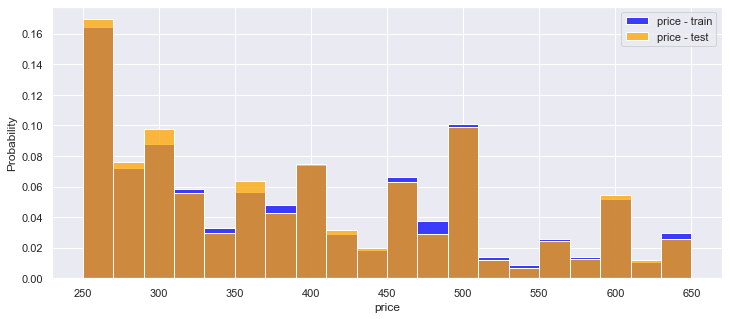

In [27]:
#check that the price distribution is also consistent:
plt.figure(figsize=(12,5))
sns.histplot(data=paintings_df_train,x='price',stat='probability',bins=20,color='blue')
sns.histplot(data=paintings_df_test,x='price',stat='probability',bins=20,color='orange')
#paintings_df_train['price'].plot(kind='hist')
#paintings_df_test['price'].plot(kind='hist')
plt.legend(['price - train','price - test'])

In [28]:
#I need to also rearrange the 'prices' numpy array, so that I can later trace back the corresponding rows in the dataframe
prices_train = prices[paintings_df_train.index]
prices_test = prices[paintings_df_test.index]

In [29]:
len(prices_train)

15567

In [30]:
#sanity check
prices_train[:5]

array([295., 350., 275., 300., 525.])

In [31]:
paintings_df_train['price'].iloc[:5]

4930     295.0
8561     350.0
3516     275.0
5679     300.0
16632    525.0
Name: price, dtype: float64

In [32]:
#sanity check
prices_test[-5:]

array([295.  , 399.99, 450.  , 275.  , 500.  ])

In [33]:
paintings_df_test['price'].iloc[-5:]

5056     295.00
10907    399.99
13123    450.00
3946     275.00
15285    500.00
Name: price, dtype: float64

### Feature types

In [34]:
#Let's divide the columns (features) into different groups, as I will test different models with different combinations of features
numerical_columns = ['num_favorers','featured_rank','max_dimension','aspect_ratio','area','weight','days_from_original_creation','days_from_last_modification'] 

categorical_columns = ['painting_type','when_made'] #,'made_by_seller','is_customizable','has_variations']

boolean_columns = ['made_by_seller','is_customizable','has_variations']

image_columns = ['image_red','image_green','image_blue','image_hue','image_saturation','image_brightness']

#the following are textual 'tags' that may have some predictive power (likely 'style_tags_new', perhaps 'tags' - not sure about 'materials')
tag_columns = ['style_tags_new','tags','materials']

#The following are 'free text' that are unlikely to be very predictive, but I could try to add them
text_columns = ['title','description']

#Finally, this is the identifier of the seller/artist:
user_column = ['shop_id']


### Baseline results picking the mean price of the paintings in the training set as my predictions

In [35]:
trivial_price_pred_train = np.ones(len(prices_train)) * np.mean(prices_train)

In [36]:
trivial_price_pred_test = np.ones(len(prices_test)) * np.mean(prices_train)

In [37]:
from sklearn import metrics

def print_all_scores_train_test(y_train,y_train_pred,y_test,y_test_pred,model_name='Results'):
    print(model_name+':')
    print("Training R^2:", metrics.r2_score(y_train, y_train_pred))
    print("Testing R^2:", metrics.r2_score(y_test, y_test_pred))
    print("Training RMSE: USD", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    print("Testing RMSE: USD", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
    print("Training MAE: USD", metrics.mean_absolute_error(y_train, y_train_pred))
    print("Testing MAE: USD", metrics.mean_absolute_error(y_test, y_test_pred))

print_all_scores_train_test(prices_train,trivial_price_pred_train,prices_test,trivial_price_pred_test,model_name='Trivial model using the mean price of the training set paintings')

Trivial model using the mean price of the training set paintings:
Training R^2: 0.0
Testing R^2: -0.0011129435654106956
Training RMSE: USD 115.65203927194021
Testing RMSE: USD 115.5684146996469
Training MAE: USD 98.77566847195826
Testing MAE: USD 98.81188688275215


## 1) Models using only numerical features

To select only the numerical features, I use scikit-learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), which works with Pandas data frames (or alternatively with NumPy arrays).

I will scale each of the numerical variables using a StandardScaler so they are all comparable to each other

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#I could select and scale at the same time:
numerical_scaler_selector = ColumnTransformer([
    ('numerical scaled (std)', StandardScaler(), numerical_columns),
], remainder='drop')

In [39]:
#Let's test it out - note that it returns a numpy array, with mean equal to zero :
test = numerical_scaler_selector.fit_transform(paintings_with_style_tags_and_image_info_df)

In [40]:
test[0]

array([ 0.58513566, -0.10930993,  0.41210228, -0.35295979,  0.89841081,
        0.27424499,  5.09195353,  0.0992361 ])

In [41]:
np.mean(test,axis=0)

array([-9.49386460e-18, -1.46059455e-18, -3.62227449e-16,  1.33279253e-17,
        1.16847564e-16, -7.59509168e-17,  1.82574319e-17,  3.89978746e-16])

In [42]:
np.std(test,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [43]:
#But it's probably cleaner to keep the selector and the scaling separately, e.g. 
numerical_selector = ColumnTransformer([
    ('numerical', 'passthrough', numerical_columns),
], remainder='drop')

In [44]:
#and then do the scaling of part of a Pipeline, e.g.
from sklearn.pipeline import Pipeline

numerical_preproc_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('standard scaling', StandardScaler()),
])

In [45]:
#Let's check that I get the same results as before:
test2 = numerical_preproc_pipe.fit_transform(paintings_with_style_tags_and_image_info_df)

In [46]:
test2[0]

array([ 0.58513566, -0.10930993,  0.41210228, -0.35295979,  0.89841081,
        0.27424499,  5.09195353,  0.0992361 ])

### Model 1a) Linear regression using only numerical features

In [47]:
#This is a good start since it has no parameters to fit, and the solution should be really fast to compute (no cross-validation, etc.)
from sklearn.linear_model import LinearRegression

numerical_linreg_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('linear reg', LinearRegression())])

In [48]:
#Let's visualize this pipeline:
from sklearn import set_config
set_config(display='diagram')

numerical_linreg_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation',
                                                                    'days_from_last_modification'])])),
                                 ('standard scaling', StandardScaler())])),
                ('linear reg', LinearRegression())])

In [49]:
#Train the model
numerical_linreg_pipe.fit(paintings_df_train,prices_train);

In [50]:
#Predict prices on training set:
prices_train_pred = numerical_linreg_pipe.predict(paintings_df_train)

In [51]:
#And return the R2 score as follows:
numerical_linreg_pipe.score(paintings_df_train,prices_train)

0.06578759944869916

In [52]:
#Predict prices on test set:
prices_test_pred = numerical_linreg_pipe.predict(paintings_df_test)

In [53]:
#And return the R2 score as follows:
numerical_linreg_pipe.score(paintings_df_test,prices_test)

0.0788971295497991

In [54]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only numerical features')

#Note that I am not overfitting the training data, since the model actually does better on test data

Linear regression model using only numerical features:
Training R^2: 0.06578759944869916
Testing R^2: 0.0788971295497991
Training RMSE: USD 111.78308956396623
Testing RMSE: USD 110.85408089777948
Training MAE: USD 94.86939480487499
Testing MAE: USD 94.18784831024173


Text(0, 0.5, 'predicted prices (test)')

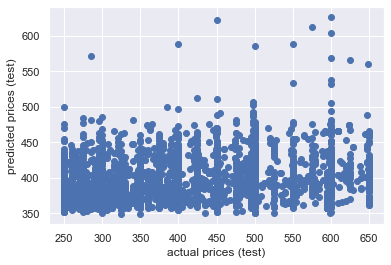

In [55]:
plt.scatter(prices_test,prices_test_pred)
plt.xlabel('actual prices (test)')
plt.ylabel('predicted prices (test)')

C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


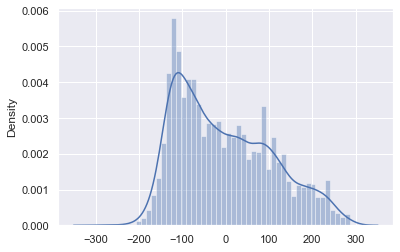

In [56]:
#Plot residuals:
sns.distplot((prices_test-prices_test_pred),bins=50);

In [57]:
#Let's look at the coefficients of the model
# intercept
print(numerical_linreg_pipe['linear reg'].intercept_)

394.353173379585


In [58]:
#coefficients for each variable:
coeff_df = pd.DataFrame(numerical_linreg_pipe['linear reg'].coef_,numerical_columns,columns=['Lin Reg Coeff'])
coeff_df

,Lin Reg Coeff
num_favorers,1.554021
featured_rank,2.069825
max_dimension,0.122143
aspect_ratio,12.318451
area,23.225107
weight,8.439767
days_from_original_creation,-0.335826
days_from_last_modification,1.729450


In [59]:
#looks like area and aspect_ratio are the most informative numerical variables

### Model 1b) Polynomial regression using only numerical features

In [60]:
from sklearn.preprocessing import PolynomialFeatures

numerical_polyreg_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('linear reg', LinearRegression())])

In [61]:
#Train the model
numerical_polyreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation',
                                                                    'days_from_last_modification'])])),
                                 ('standard scaling', StandardScaler())])),
                ('polynomial_trans',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('linear reg', LinearRegression())])

In [62]:
#Predict prices on training set:
prices_train_pred = numerical_polyreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_polyreg_pipe.score(paintings_df_train,prices_train)

0.0983159678208011

In [63]:
#Predict prices on test set:
prices_test_pred = numerical_polyreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_polyreg_pipe.score(paintings_df_test,prices_test)

0.04567696996191417

In [64]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial regression model using only numerical features')


Polynomial regression model using only numerical features:
Training R^2: 0.0983159678208011
Testing R^2: 0.04567696996191417
Training RMSE: USD 109.81975852825491
Testing RMSE: USD 112.83538625949616
Training MAE: USD 92.06916866633601
Testing MAE: USD 93.17433793546634


In [65]:
#It looks like I am already overfitting the training data, so let's try to replace the linear regression with a ridge regression or LASSO model

In [66]:
from sklearn.linear_model import Ridge

numerical_polyreg_ridge_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

numerical_polyreg_ridge_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation',
                                                                    'days_from_last_modification'])])),
                                 ('standard scaling', StandardScaler())])),
                ('polynomial_trans',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('ridge', Ridge(alpha=10))])

In [67]:
numerical_polyreg_ridge_pipe.get_params()

{'memory': None,
 'steps': [('numerical preproc',
   Pipeline(steps=[('numerical selector',
                    ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                     ['num_favorers',
                                                      'featured_rank',
                                                      'max_dimension',
                                                      'aspect_ratio', 'area',
                                                      'weight',
                                                      'days_from_original_creation',
                                                      'days_from_last_modification'])])),
                   ('standard scaling', StandardScaler())])),
  ('polynomial_trans', PolynomialFeatures(degree=3, include_bias=False)),
  ('ridge', Ridge(alpha=10))],
 'verbose': False,
 'numerical preproc': Pipeline(steps=[('numerical selector',
                  ColumnTransformer(transformers=[(

In [68]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
numerical_polyreg_ridge_CVmodel = GridSearchCV(numerical_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [69]:
numerical_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   12.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical preproc',
                                        Pipeline(steps=[('numerical selector',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          'passthrough',
                                                                                          ['num_favorers',
                                                                                           'featured_rank',
                                                                                           'max_dimension',
                                                                                           'aspect_ratio',
                                                                                           'area',
                                                                                           'weight',
                                                                                           'days_from_original_creation',
                                                                                           'days_from_last_modification'])])),
                                                        ('standard scaling',
                                                         StandardScaler())])),
                                       ('poly...
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [70]:
numerical_polyreg_ridge_CVmodel.best_params_

{'ridge__alpha': 112883.78916846884}

In [71]:
#Predict prices on training set:
prices_train_pred = numerical_polyreg_ridge_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.054777721398355794

In [72]:
#Predict prices on test set:
prices_test_pred = numerical_polyreg_ridge_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

0.05370241101252504

In [73]:
print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial Ridge regression model using only numerical features')

Polynomial Ridge regression model using only numerical features:
Training R^2: 0.054777721398355794
Testing R^2: 0.05370241101252504
Training RMSE: USD 112.43985312756409
Testing RMSE: USD 112.35993633953481
Training MAE: USD 95.70448509932582
Testing MAE: USD 95.69392863236232


In [74]:
#Now I am not overfitting, but the performance is worse than normal linear regression

In [75]:
numerical_polyreg_ridge_CVmodel.cv_results_

{'mean_fit_time': array([0.07155113, 0.06944809, 0.06002922, 0.07076383, 0.06364121,
        0.06630902, 0.06792221, 0.06837182, 0.06657968, 0.06147361,
        0.0648685 , 0.06903934, 0.0608398 , 0.05724473, 0.05312123,
        0.05620093, 0.04984417, 0.05618944, 0.05518379, 0.04687147]),
 'std_fit_time': array([1.20007518e-02, 3.33793872e-03, 1.01918032e-02, 7.18721781e-03,
        1.05892527e-02, 2.35271599e-03, 1.47508256e-03, 2.05255316e-03,
        5.72128929e-03, 1.29450901e-02, 3.32620221e-03, 8.51807309e-03,
        7.89638744e-03, 1.10140754e-02, 7.65257272e-03, 7.61879711e-03,
        6.78876855e-03, 7.61017654e-03, 7.05965881e-03, 1.74159836e-06]),
 'mean_score_time': array([0.00608859, 0.01122351, 0.00558114, 0.00936923, 0.01050043,
        0.01016612, 0.00936933, 0.01016641, 0.0137136 , 0.01109867,
        0.0077342 , 0.01290412, 0.00578146, 0.00983772, 0.00334105,
        0.00159478, 0.00624976, 0.00764523, 0.00624971, 0.01249819]),
 'std_score_time': array([0.0040821 , 

In [76]:
#Let's try Lasso next:

In [77]:
from sklearn.linear_model import Lasso

numerical_polyreg_lasso_pipe = Pipeline([('numerical preproc', numerical_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('lasso', Lasso(alpha=1))])

numerical_polyreg_lasso_pipe

Pipeline(steps=[('numerical preproc',
                 Pipeline(steps=[('numerical selector',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   'passthrough',
                                                                   ['num_favorers',
                                                                    'featured_rank',
                                                                    'max_dimension',
                                                                    'aspect_ratio',
                                                                    'area',
                                                                    'weight',
                                                                    'days_from_original_creation',
                                                                    'days_from_last_modification'])])),
                                 ('standard scaling', StandardScaler())])),
                ('polynomial_trans',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lasso', Lasso(alpha=1))])

In [78]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'lasso__alpha': np.linspace(0,10,1)} 
numerical_polyreg_lasso_CVmodel = GridSearchCV(numerical_polyreg_lasso_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [79]:
numerical_polyreg_lasso_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.2s finished
C:\Users\matte\anaconda3\lib\site-packages\sklearn\pipeline.py:335: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\matte\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\matte\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94043860.21990487, tolerance: 20821.476132083513
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical preproc',
                                        Pipeline(steps=[('numerical selector',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          'passthrough',
                                                                                          ['num_favorers',
                                                                                           'featured_rank',
                                                                                           'max_dimension',
                                                                                           'aspect_ratio',
                                                                                           'area',
                                                                                           'weight',
                                                                                           'days_from_original_creation',
                                                                                           'days_from_last_modification'])])),
                                                        ('standard scaling',
                                                         StandardScaler())])),
                                       ('polynomial_trans',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('lasso', Lasso(alpha=1))]),
             n_jobs=2, param_grid={'lasso__alpha': array([0.])}, verbose=1)

In [80]:
numerical_polyreg_lasso_CVmodel.best_params_

{'lasso__alpha': 0.0}

In [81]:
#By picking alpha=0, the model is saying that linear regression (with polynomial features) is the best choice. 
#However, we already know this overfits a bit the training data, and does not improve much the perofrmance w.r.t. pure linear model. 

In [82]:
#Predict prices on training set:
prices_train_pred = numerical_polyreg_lasso_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_polyreg_lasso_CVmodel.score(paintings_df_train,prices_train)

0.09666481258747983

In [83]:
#Predict prices on test set:
prices_test_pred = numerical_polyreg_lasso_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_polyreg_lasso_CVmodel.score(paintings_df_test,prices_test)

0.05811890705196254

In [84]:
print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial Lasso regression model using only numerical features')

Polynomial Lasso regression model using only numerical features:
Training R^2: 0.09666481258747983
Testing R^2: 0.05811890705196254
Training RMSE: USD 109.92026298783618
Testing RMSE: USD 112.09743034993375
Training MAE: USD 92.17825402854534
Testing MAE: USD 92.95426647710445


Text(0, 0.5, 'predicted prices (test)')

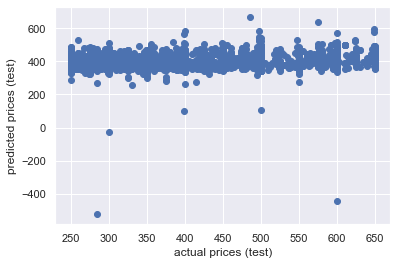

In [85]:
plt.scatter(prices_test,prices_test_pred)
plt.xlabel('actual prices (test)')
plt.ylabel('predicted prices (test)')

C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


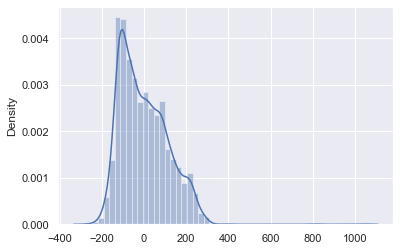

In [86]:
#Plot residuals:
sns.distplot((prices_test-prices_test_pred),bins=50);

In [87]:
#Let's look at the coefficients of the model
# intercept
numerical_polyreg_lasso_CVmodel.best_estimator_['lasso'].intercept_

389.98116926461955

In [88]:
#coefficients for each variable:
coeff_df = pd.DataFrame(numerical_polyreg_lasso_CVmodel.best_estimator_['lasso'].coef_,columns=['Lasso Reg Coeff']) #numerical_columns,
coeff_df.sort_values(by='Lasso Reg Coeff', ascending=False)

,Lasso Reg Coeff
4,29.613393
134,23.217979
61,21.388187
10,20.359942
17,18.993093
...,...
12,-13.647082
19,-14.577884
36,-18.540016
115,-24.515830


In [89]:
### The best linear model using only numerical variables seems to be the basic Linear Regression model, so I save it (unless alread done so)

In [90]:
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

numerical_linreg_pipe_filename = './Git_exclude/models/numerical_linreg_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(numerical_linreg_pipe_filename, 'rb') as f:
        numerical_linreg_pipe = load(f)
        print('Loaded joblib file with numerical-only linear regression.')
except: #if not, actually perform the fit then save the model for next time:
    
    numerical_linreg_pipe.fit(paintings_df_train,prices_train);
    
    with open(numerical_linreg_pipe_filename, 'wb') as f:
        dump(numerical_linreg_pipe, numerical_linreg_pipe_filename) 
    print('Saved joblib file with numerical-only linear regression.')

# #Version with dill

# import dill

# #If the model file already exists, I load it:
# try:
#     with open('lat_long_model.dill', 'rb') as f:
#         lat_long_model = dill.load(f)
#         print('Loaded pickle file with lat-long model.')
# except: #if not, actually perform the fit then save the model for next time:
    
#     lat_long_model.fit(data_shuffled, star_ratings_shuffled)
    
#     with open('lat_long_model.dill', 'wb') as f:
#         dill.dump(lat_long_model, f)
#     print('Saved pickle file with lat-long model.')


Loaded joblib file with numerical-only linear regression.


#### Model 1c) Decision tree using only numerical features

In [92]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [93]:
# #Recall that I already have the numerical selector, which need not change:
# numerical_selector = ColumnTransformer([
#     ('numerical', 'passthrough', numerical_columns),
# ], remainder='drop')

In [94]:
#there's no need to rescale for tree-based algorithms, so I can jump straight to the Pipeline performing the regression
from sklearn.pipeline import Pipeline

numerical_dtree_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [95]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
numerical_dtree_CVmodel = GridSearchCV(numerical_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [96]:
numerical_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    6.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numerical selector',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['num_favorers',
                                                                          'featured_rank',
                                                                          'max_dimension',
                                                                          'aspect_ratio',
                                                                          'area',
                                                                          'weight',
                                                                          'days_from_original_creation',
                                                                          'days_from_last_modification'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [166]:
numerical_dtree_CVmodel.best_params_['dtree__max_depth']

6

In [98]:
#Predict prices on training set:
prices_train_pred = numerical_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_dtree_CVmodel.score(paintings_df_train,prices_train)

0.14475129088693084

In [99]:
#Predict prices on test set:
prices_test_pred = numerical_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_dtree_CVmodel.score(paintings_df_test,prices_test)

0.14142099864554813

In [100]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only numerical features')


Decision Tree model using only numerical features:
Training R^2: 0.14475129088693084
Testing R^2: 0.14142099864554813
Training RMSE: USD 106.95461005940241
Testing RMSE: USD 107.02561915352703
Training MAE: USD 87.81203139432989
Testing MAE: USD 88.01957463081635


In [101]:
#what are the main features used for decision?
numerical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.00894639, 0.01492574, 0.4985683 , 0.02874118, 0.10316532,
       0.22046162, 0.06636191, 0.05882953])

In [241]:
feature_names_num_dtree = numerical_dtree_CVmodel.best_estimator_['numerical selector'].get_feature_names()

numerical_dtree_features_imp_df = pd.DataFrame(numerical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_num_dtree,columns=['Dtree feature importance'])
numerical_dtree_features_imp_df = numerical_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
numerical_dtree_features_imp_df

,Dtree feature importance
max_dimension,0.498568
weight,0.220462
area,0.103165
days_from_original_creation,0.066362
days_from_last_modification,0.058830
aspect_ratio,0.028741
featured_rank,0.014926
num_favorers,0.008946


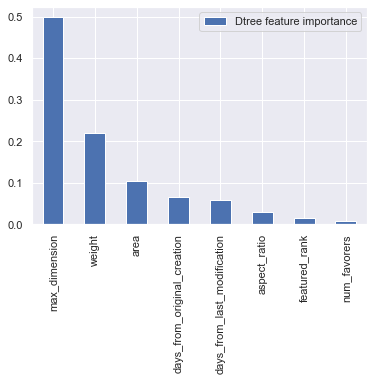

In [242]:
numerical_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

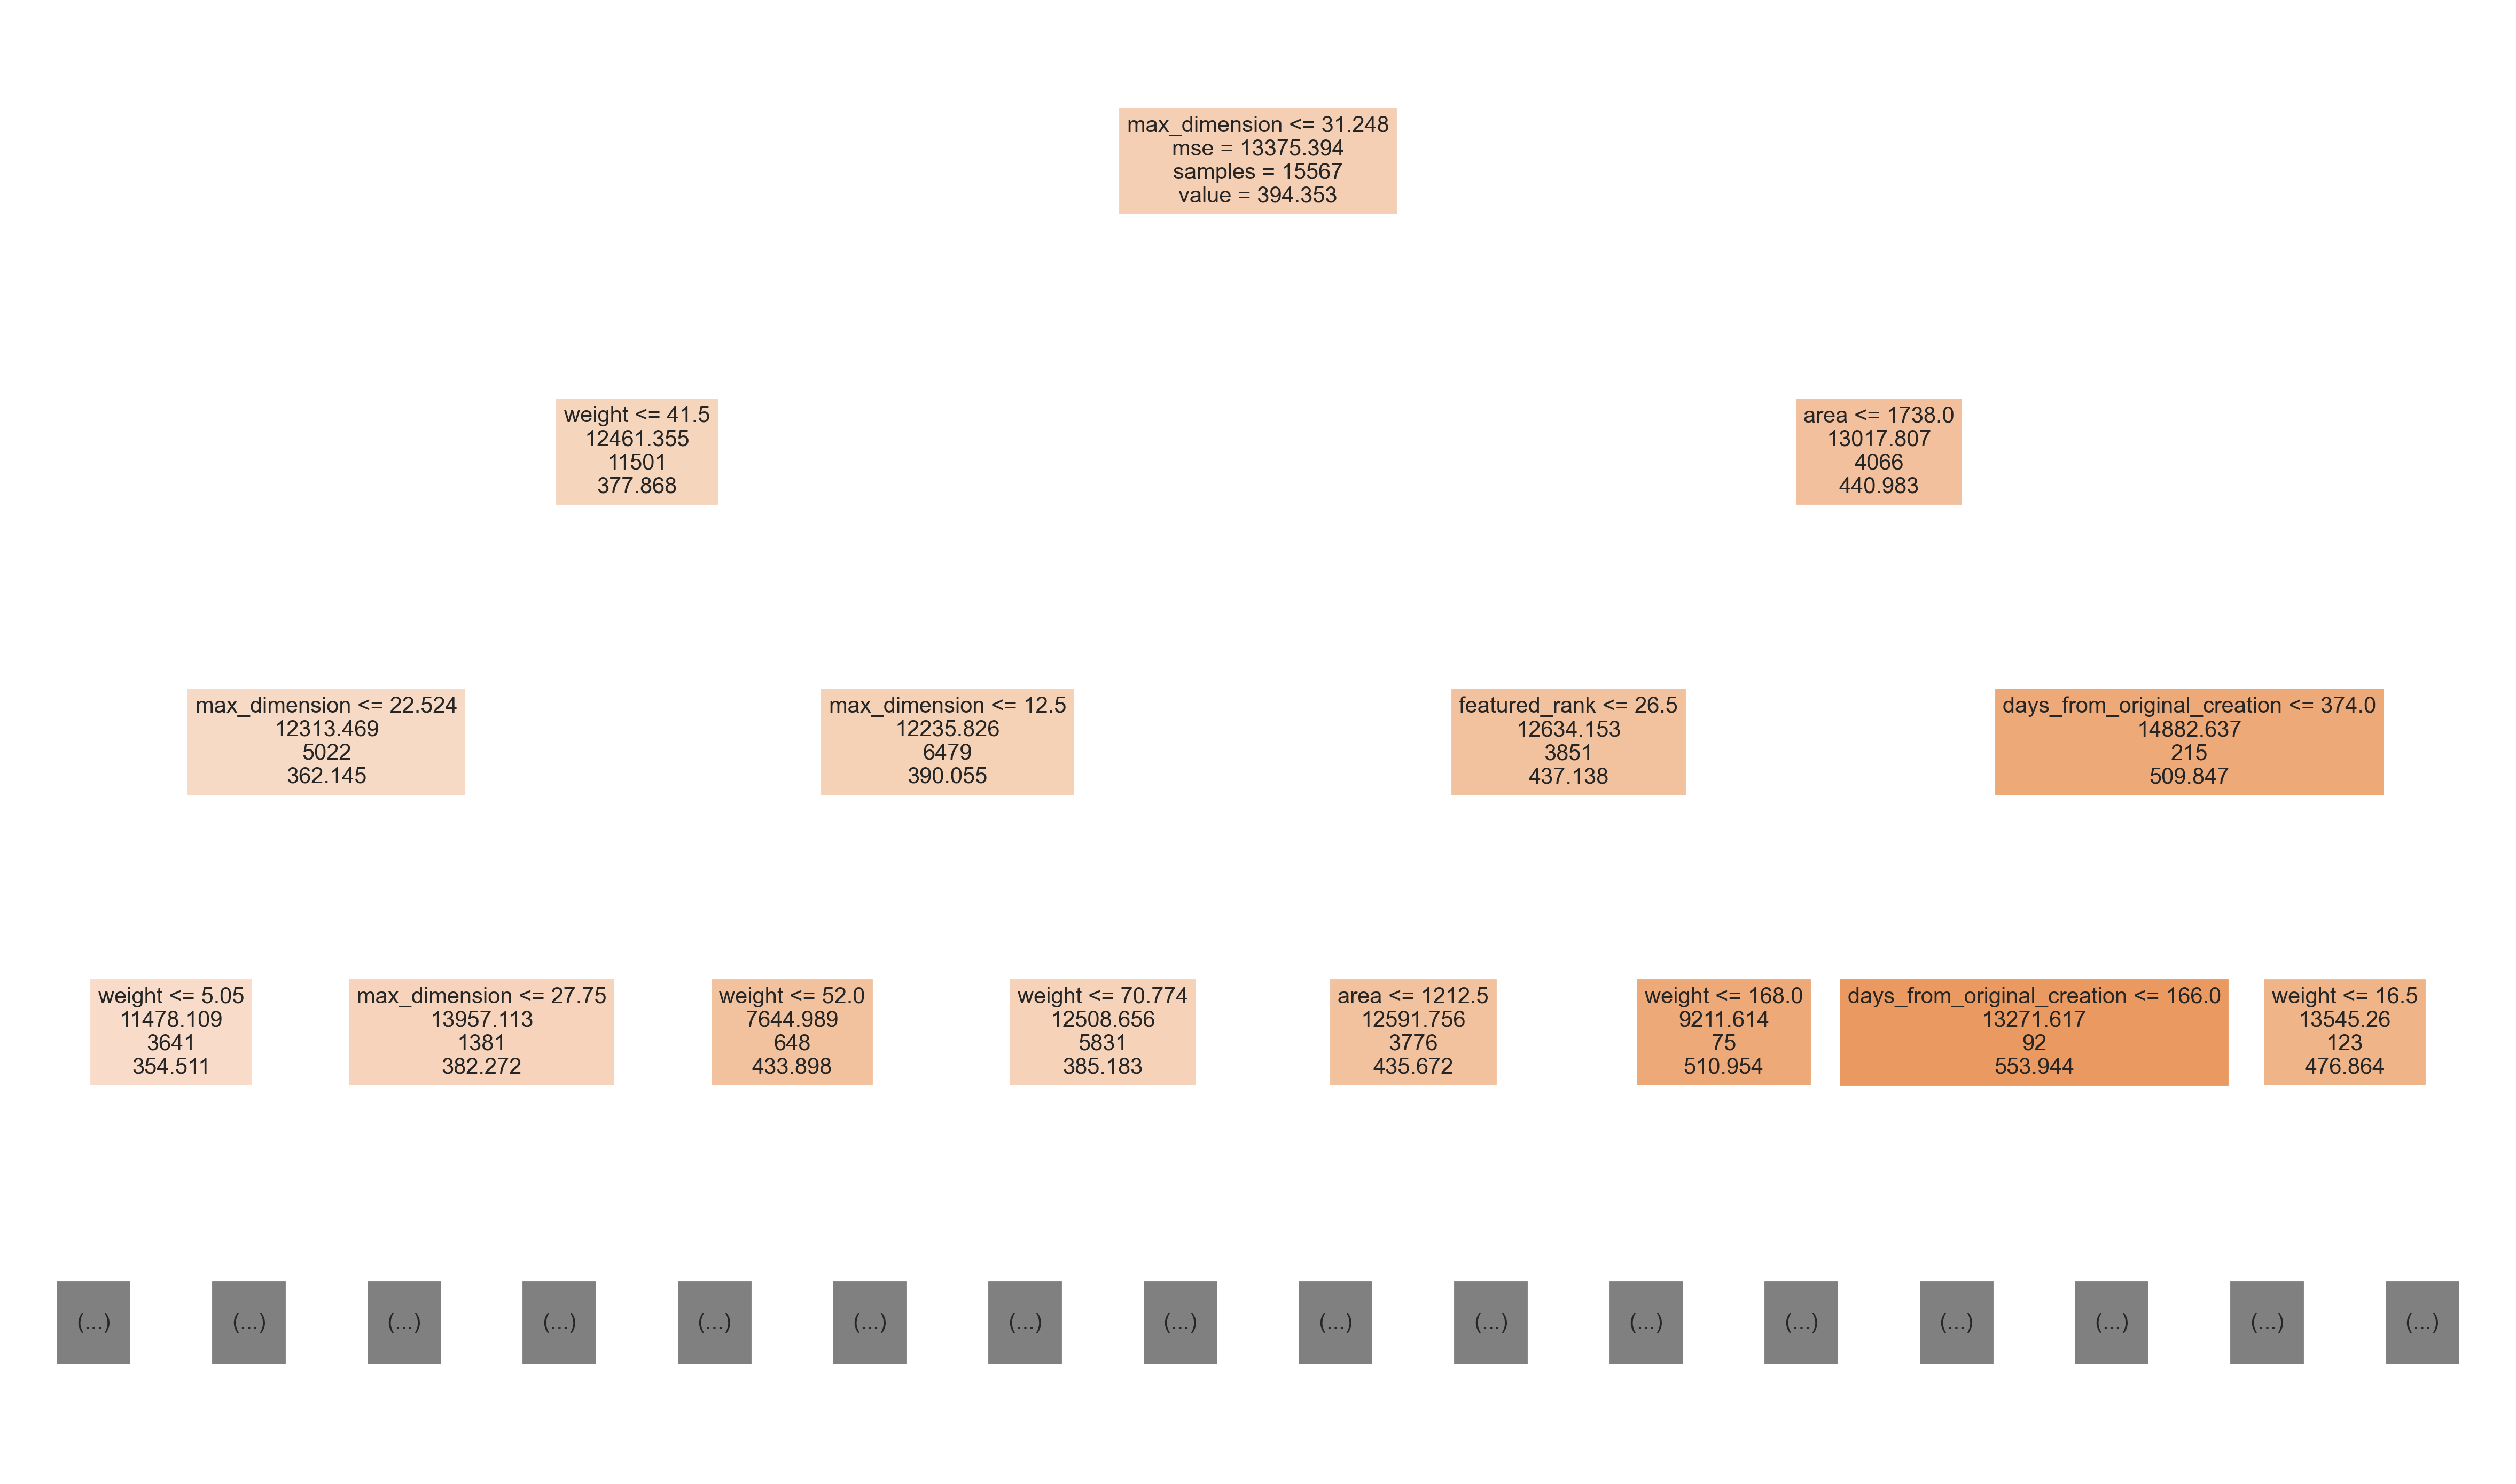

In [115]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
plt.figure(figsize=(20,12), dpi=300)
tree_viz = plot_tree(numerical_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_num_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_numerical_only.png')

# #export_graphviz(categorical_tree_pipe['decision tree'],out_file=None)
#graphviz.Source(export_graphviz(numerical_dtree_CVmodel.best_estimator_['dtree'], out_file=None))

#### Model 1d) Random Forest using only numerical features

In [116]:
from sklearn.ensemble import RandomForestRegressor

In [223]:
numerical_rforest_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('rforest', RandomForestRegressor(n_estimators=20,max_features='sqrt',n_jobs=2,max_depth=numerical_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [224]:
numerical_rforest_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical selector',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=7, max_features='sqrt',
                                       max_samples=0.8, n_estimators=20,
                                       n_jobs=2, random_state=1))])

In [225]:
#Predict prices on training set:
prices_train_pred = numerical_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_rforest_pipe.score(paintings_df_train,prices_train)

0.16784202727827102

In [226]:
#Predict prices on test set:
prices_test_pred = numerical_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_rforest_pipe.score(paintings_df_test,prices_test)

0.1518000664208089

In [227]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using only numerical features')


Random Forest model using only numerical features:
Training R^2: 0.16784202727827102
Testing R^2: 0.15180006642080868
Training RMSE: USD 105.50090479061792
Testing RMSE: USD 106.37675416935903
Training MAE: USD 87.69412602709103
Testing MAE: USD 88.66544291459743


In [230]:
#what are the main features used for decision?
numerical_rforest_pipe['rforest'].feature_importances_

array([0.04203555, 0.01762342, 0.22142353, 0.1045655 , 0.2991992 ,
       0.17553421, 0.08129487, 0.05832372])

In [239]:
feature_names_num_rforest = numerical_rforest_pipe['numerical selector'].get_feature_names()

numerical_rforest_features_imp_df = pd.DataFrame(numerical_rforest_pipe['rforest'].feature_importances_,feature_names_num_rforest,columns=['Rforest feature importance'])
numerical_rforest_features_imp_df = numerical_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
numerical_rforest_features_imp_df

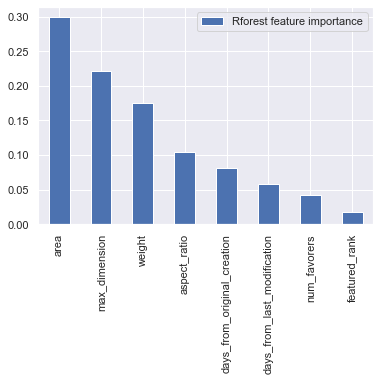

In [240]:
numerical_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 1e) Gradient Boosting Trees using only numerical features¶

In [243]:
from sklearn.ensemble import GradientBoostingRegressor

In [312]:
numerical_gboost_pipe = Pipeline([
    ('numerical selector', numerical_selector),
    ('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=numerical_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [313]:
numerical_gboost_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('numerical selector',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=5, n_estimators=50,
                                           random_state=1, subsample=0.5))])

In [314]:
#Predict prices on training set:
prices_train_pred = numerical_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
numerical_gboost_pipe.score(paintings_df_train,prices_train)

0.20511470555169953

In [315]:
#Predict prices on test set:
prices_test_pred = numerical_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
numerical_gboost_pipe.score(paintings_df_test,prices_test)

0.16787744206496769

In [316]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using only numerical features')


Gradient Boosting model using only numerical features:
Training R^2: 0.20511470555169953
Testing R^2: 0.16787744206496769
Training RMSE: USD 103.1111252353422
Testing RMSE: USD 105.3637612059539
Training MAE: USD 85.30633755808505
Testing MAE: USD 87.30628788158393


In [317]:
#what are the main features used for decision?
numerical_gboost_pipe['gboost'].feature_importances_

array([0.04964733, 0.02472346, 0.28585178, 0.07875351, 0.14345634,
       0.16652941, 0.1442517 , 0.10678647])

In [319]:
feature_names_num_gboost = numerical_gboost_pipe['numerical selector'].get_feature_names()

numerical_gboost_features_imp_df = pd.DataFrame(numerical_gboost_pipe['gboost'].feature_importances_,feature_names_num_gboost,columns=['Gboost feature importance'])
numerical_gboost_features_imp_df = numerical_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
numerical_gboost_features_imp_df

,Gboost feature importance
max_dimension,0.285852
weight,0.166529
days_from_original_creation,0.144252
area,0.143456
days_from_last_modification,0.106786
aspect_ratio,0.078754
num_favorers,0.049647
featured_rank,0.024723


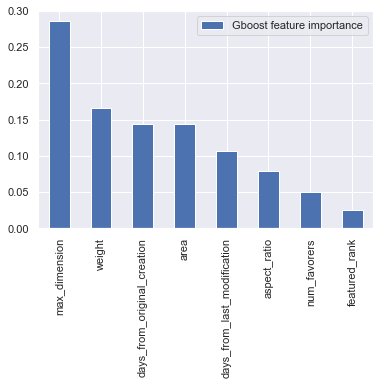

In [320]:
numerical_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 2) Models using only categorical (and boolean) features

In [321]:
#I create a custom regressor to assess some 'baseline' model based on the 'painting_type' categorical feature: 
#how good is a model where I just return the mean price for all paintings of that category (e.g. all watercolors)? 

In [322]:
#Note that a sklearn Regressor takes numpy arrays - not dictionaries - but if I use a ColumnTransformer before the regressor I will be fine

In [323]:
painting_type_selector = ColumnTransformer([
    ('categorical', 'passthrough', ['painting_type']),
], remainder='drop')

In [324]:
#check that the output is a 2Darray
temp = painting_type_selector.fit_transform(paintings_df_train)

In [325]:
for listing in temp[:3]:
    print(listing)

['oil']
['oil']
['acrylic']


#### 2a) Baseline model using the mean price of paintings of each type

In [326]:
from sklearn.base import BaseEstimator, RegressorMixin

import numpy as np
from collections import defaultdict

class CategoricalMeanRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_price = dict()
    
    def fit(self, X, y):
        # Store the average price per categorical feature in self.avg_price
        price_sum = defaultdict(int)
        count = defaultdict(int)
 
        for listing, price in zip(X, y):
            # increment the running sum in price_sum
            price_sum[listing[0]]+=price
            # increment the running count in count
            count[listing[0]]+=1
        
        for category in price_sum:
            self.avg_price[category]=price_sum[category]/count[category]
               
        return self
    
    def predict(self, X):
        predictions = np.zeros(len(X))
        
        for idx, listing in enumerate(X):
            if listing[0] in self.avg_price.keys():
                predictions[idx]=self.avg_price[listing[0]]
        
        return predictions

In [327]:
#Let's create a pipeline to apply the above "regressor" to the 'painting_type' column

from sklearn.pipeline import Pipeline

painting_type_mean_pipe = Pipeline([
    ('painting type selector', painting_type_selector),
    ('mean of painting_type', CategoricalMeanRegressor()),
])

In [328]:
painting_type_mean_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('painting type selector',
                 ColumnTransformer(transformers=[('categorical', 'passthrough',
                                                  ['painting_type'])])),
                ('mean of painting_type', CategoricalMeanRegressor())])

In [329]:
painting_type_mean_pipe[-1].avg_price

{'oil': 404.7454306617892,
 'acrylic': 393.35852230621066,
 'watercolor': 365.0730167264038,
 'more_than_one': 388.36983215547696}

In [330]:
#Check the results are right:
paintings_df_train.groupby(by='painting_type').mean()

,listing_id,user_id,shop_id,shop_section_id,featured_rank,num_favorers,is_customizable,shipping_profile_id,has_variations,price,...,image_red,image_green,image_blue,image_hue,image_saturation,image_brightness,image_creation_tsz,image_rank,image_full_height,image_full_width
painting_type,,,,,,,,,,,,,,,,,,,,,
acrylic,7.989581e+08,1.389216e+08,1.642913e+07,2.521571e+07,0.067734,10.549726,0.152957,9.024119e+10,0.090559,393.358522,...,132.332178,124.944824,118.265951,111.054584,21.266835,54.754350,1.583485e+09,1.0,1975.102712,1978.942048
more_than_one,7.587528e+08,1.134239e+08,1.504850e+07,2.366863e+07,1.045053,10.659011,0.131625,8.260137e+10,0.136926,388.369832,...,135.630742,128.020318,120.083039,93.264134,20.329505,55.530035,1.574186e+09,1.0,2025.025618,1959.461131
oil,7.992274e+08,1.107814e+08,1.445391e+07,2.330017e+07,1.035584,14.645826,0.124875,7.984116e+10,0.084802,404.745431,...,128.412205,121.314766,109.236615,92.349185,22.598603,52.507316,1.581545e+09,1.0,1984.047057,2079.560027
watercolor,7.721602e+08,1.129557e+08,1.430420e+07,2.322477e+07,0.277180,9.529271,0.243728,7.131768e+10,0.109319,365.073017,...,150.151135,142.755675,132.056153,88.989247,17.715651,60.453405,1.577797e+09,1.0,1882.782557,2002.523297


In [331]:
#Now I am ready to assess the performance of this model:
prices_pred_train = painting_type_mean_pipe.predict(paintings_df_train)
prices_pred_test = painting_type_mean_pipe.predict(paintings_df_test)

In [332]:
print_all_scores_train_test(prices_train,prices_pred_train,prices_test,prices_pred_test,model_name='Trivial model using the mean price of the paintings of same type in the training set')

Trivial model using the mean price of the paintings of same type in the training set:
Training R^2: 0.010238819934646592
Testing R^2: 0.013293076017480199
Training RMSE: USD 115.05844573570002
Testing RMSE: USD 114.73388661165743
Training MAE: USD 98.09485006595159
Testing MAE: USD 97.8822969967778


In [333]:
#Select the categorical features (defined earlier) and apply OneHotEncoding to all of them - 
#for now I drop the first column since I will try LinearRegression and want to avoid multi-collinearity
#Separately, pass through the boolean variables

In [334]:
from sklearn.preprocessing import OneHotEncoder

# categorical_selector = ColumnTransformer([
#     ('categorical','passthrough', categorical_columns),
# ], remainder='drop')

categorical_selector = ColumnTransformer([
     ('categorical', OneHotEncoder(drop='first'), categorical_columns),
    ('boolean','passthrough', boolean_columns),
 ], remainder='drop')

In [335]:
categorical_selector.fit_transform(paintings_df_train)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [358]:
categorical_feature_names = categorical_selector.get_feature_names()

#### Model 2b) Linear regression using only categorical features

In [337]:
from sklearn.preprocessing import OneHotEncoder

#and then apply LinearRegression within a pipeline
from sklearn.pipeline import Pipeline

categorical_linreg_pipe = Pipeline([
    ('categorical selector', categorical_selector),
    ('linear reg', LinearRegression()),
])

# categorical_linreg_pipe = Pipeline([
#     ('categorical selector', categorical_selector),
#     ('one hot encoding - drop 1st', OneHotEncoder(drop='first')),
#     ('linear reg', LinearRegression()),
# ])

In [338]:
#Train the model
categorical_linreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('linear reg', LinearRegression())])

In [339]:
#Predict prices on training set:
prices_train_pred = categorical_linreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_linreg_pipe.score(paintings_df_train,prices_train)

0.015937474313431954

In [340]:
#Predict prices on test set:
prices_test_pred = categorical_linreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_linreg_pipe.score(paintings_df_test,prices_test)

0.019843667865828474

In [341]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only categorical features with One-hot-encoding')


Linear regression model using only categorical features with One-hot-encoding:
Training R^2: 0.015937474313431954
Testing R^2: 0.019843667865828474
Training RMSE: USD 114.72673701652539
Testing RMSE: USD 114.35240230322299
Training MAE: USD 97.64433983934032
Testing MAE: USD 97.59096249572666


In [342]:
#Let's look at the coefficients of the model
# intercept
print(categorical_linreg_pipe['linear reg'].intercept_)

408.0748630953141


In [343]:
categorical_linreg_pipe['linear reg'].coef_

array([ -8.1309107 ,   8.7699868 , -31.42887982, -12.20708282,
        -4.23462108,  -7.48464552, -10.8170622 ,   4.25707393,
        18.46875813])

In [344]:
#coefficients for each variable:
coeff_df = pd.DataFrame(categorical_linreg_pipe['linear reg'].coef_,categorical_feature_names,columns=['Lin Reg Coeff'])
coeff_df

,Lin Reg Coeff
categorical__x0_more_than_one,-8.130911
categorical__x0_oil,8.769987
categorical__x0_watercolor,-31.428880
categorical__x1_made_2020s,-12.207083
categorical__x1_made_before_2010,-4.234621
categorical__x1_made_to_order,-7.484646
made_by_seller,-10.817062
is_customizable,4.257074
has_variations,18.468758


### Model 2c) Decision Tree model using only categorical features

In [345]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [346]:
#I don't want to drop the first variable for tree-based models (whereas I needed to do those for linear-regression to prevent collinearity)
categorical_selector_no_drop = ColumnTransformer([
      ('categorical', OneHotEncoder(), categorical_columns),
     ('boolean','passthrough', boolean_columns),
  ], remainder='drop')

In [347]:
categorical_dtree_pipe = Pipeline([
    ('categorical selector', categorical_selector_no_drop),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [348]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
categorical_dtree_CVmodel = GridSearchCV(categorical_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [349]:
categorical_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    6.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical selector',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['painting_type',
                                                                          'when_made']),
                                                                        ('boolean',
                                                                         'passthrough',
                                                                         ['made_by_seller',
                                                                          'is_customizable',
                                                                          'has_variations'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [350]:
categorical_dtree_CVmodel.best_params_

{'dtree__max_depth': 7}

In [351]:
#Predict prices on training set:
prices_train_pred = categorical_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_dtree_CVmodel.score(paintings_df_train,prices_train)

0.03677639442256908

In [352]:
#Predict prices on test set:
prices_test_pred = categorical_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_dtree_CVmodel.score(paintings_df_test,prices_test)

0.03478812949583632

In [353]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only categorical features with One-hot-encoding')


Decision Tree model using only categorical features with One-hot-encoding:
Training R^2: 0.03677639442256908
Testing R^2: 0.03478812949583632
Training RMSE: USD 113.50548627952774
Testing RMSE: USD 113.47728717533374
Training MAE: USD 96.17826167980336
Testing MAE: USD 96.27191355517591


In [354]:
#what are the main features used for decision?
categorical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.0073619 , 0.0475595 , 0.06682681, 0.2100054 , 0.0525275 ,
       0.09773479, 0.01939066, 0.02006191, 0.23440033, 0.11475393,
       0.12937727])

In [355]:
feature_names_cat_dtree = categorical_dtree_CVmodel.best_estimator_['categorical selector'].get_feature_names()

categorical_dtree_features_imp_df = pd.DataFrame(categorical_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_cat_dtree,columns=['Dtree feature importance'])
categorical_dtree_features_imp_df = categorical_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
categorical_dtree_features_imp_df

,Dtree feature importance
made_by_seller,0.234400
categorical__x0_watercolor,0.210005
has_variations,0.129377
is_customizable,0.114754
categorical__x1_made_2020s,0.097735
categorical__x0_oil,0.066827
categorical__x1_made_2010s,0.052527
categorical__x0_more_than_one,0.047560
categorical__x1_made_to_order,0.020062
categorical__x1_made_before_2010,0.019391


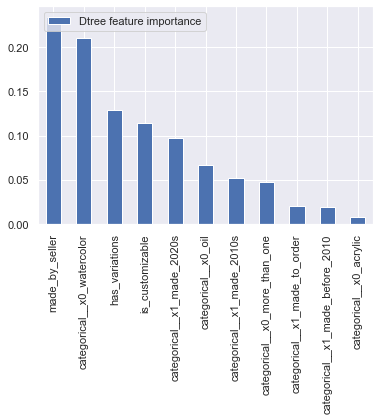

In [356]:
categorical_dtree_features_imp_df.plot(kind="bar").legend(loc="upper left");

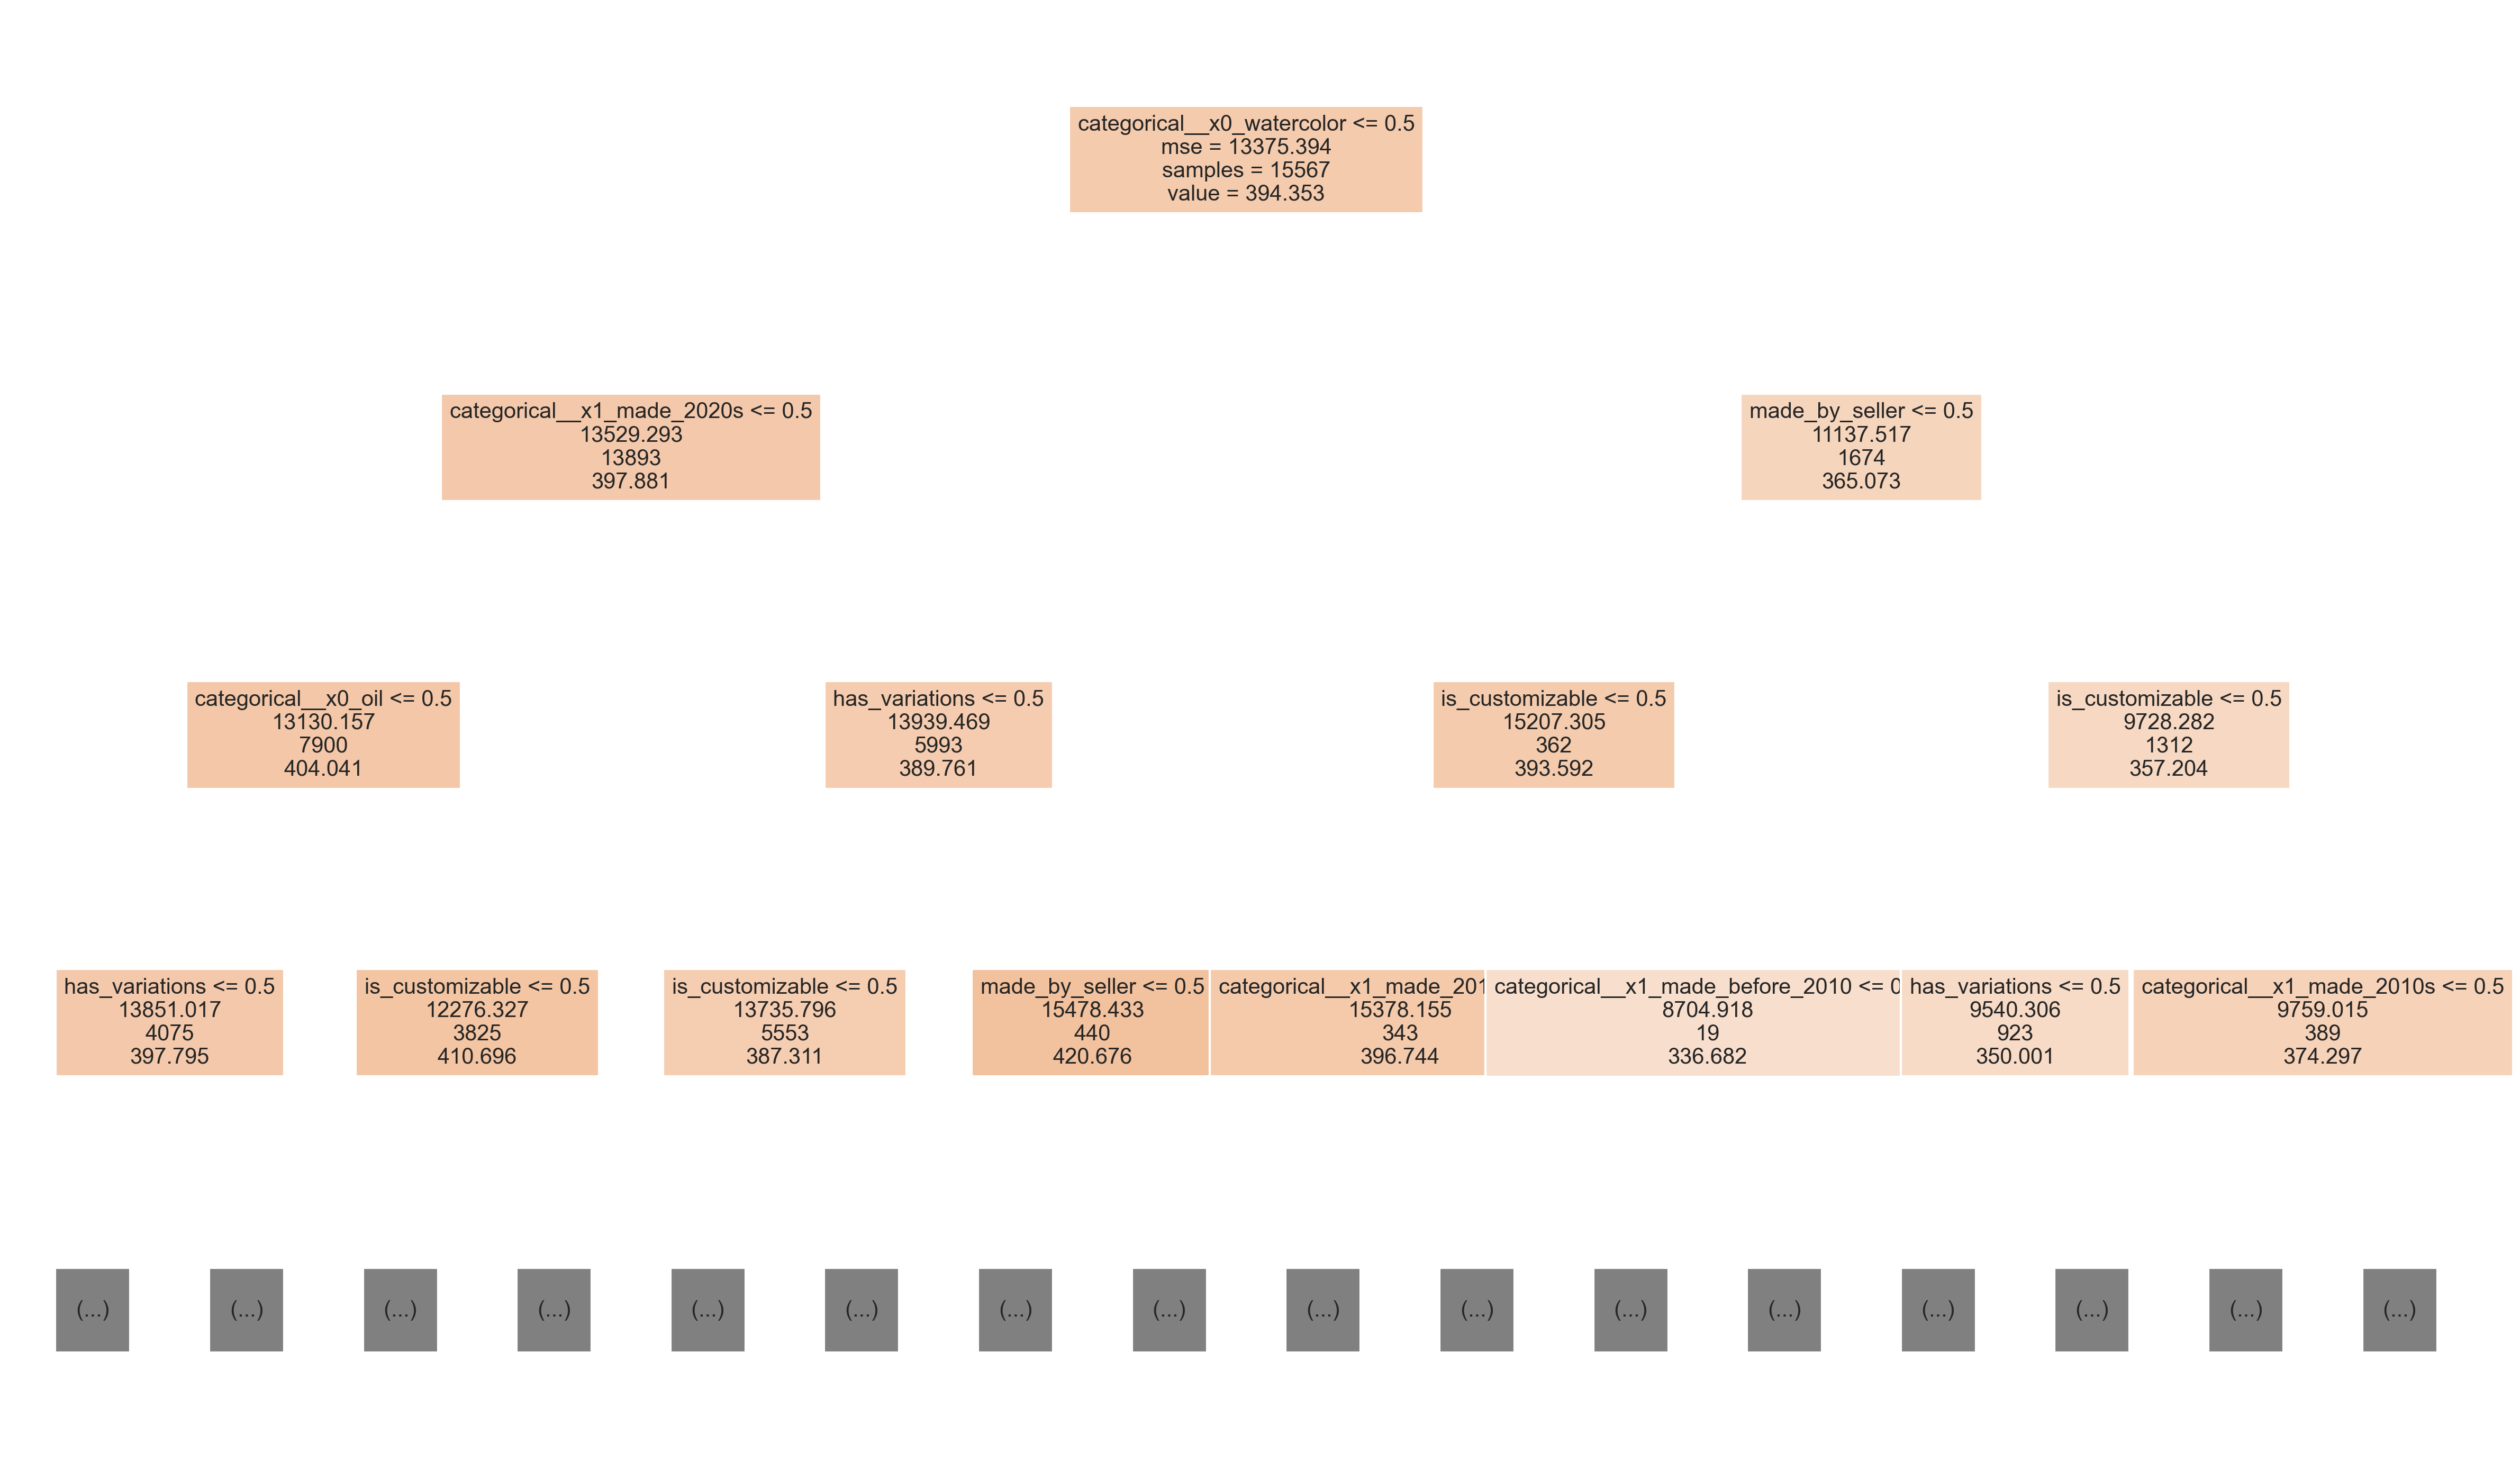

In [357]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
plt.figure(figsize=(20,12), dpi=300)
tree_viz = plot_tree(categorical_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_cat_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_categorical_only.png')

# #export_graphviz(categorical_tree_pipe['decision tree'],out_file=None)
# #graphviz.Source(tree.export_graphviz(tree_reg, out_file=None))

#### Model 2d) Random Forest using only categorical features

In [360]:
from sklearn.ensemble import RandomForestRegressor

In [369]:
categorical_rforest_pipe = Pipeline([
    ('categorical selector', categorical_selector_no_drop),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=categorical_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [370]:
categorical_rforest_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       max_samples=0.8, n_estimators=50,
                                       n_jobs=2, random_state=1))])

In [371]:
#Predict prices on training set:
prices_train_pred = categorical_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_rforest_pipe.score(paintings_df_train,prices_train)

0.038308221865903436

In [372]:
#Predict prices on test set:
prices_test_pred = categorical_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_rforest_pipe.score(paintings_df_test,prices_test)

0.03747304577470867

In [373]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using only categorical features')


Random Forest model using only categorical features:
Training R^2: 0.038308221865903436
Testing R^2: 0.03747304577470867
Training RMSE: USD 113.4151957176367
Testing RMSE: USD 113.3193481781654
Training MAE: USD 96.0780300623602
Testing MAE: USD 96.14941632195831


In [374]:
#what are the main features used for decision?
categorical_rforest_pipe['rforest'].feature_importances_

array([0.06365796, 0.0571211 , 0.09975706, 0.15106417, 0.05051517,
       0.07951721, 0.03072564, 0.02979286, 0.14717385, 0.1636893 ,
       0.12698568])

In [375]:
feature_names_cat_rforest = categorical_rforest_pipe['categorical selector'].get_feature_names()

categorical_rforest_features_imp_df = pd.DataFrame(categorical_rforest_pipe['rforest'].feature_importances_,feature_names_cat_rforest,columns=['Rforest feature importance'])
categorical_rforest_features_imp_df = categorical_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
categorical_rforest_features_imp_df

,Rforest feature importance
is_customizable,0.163689
categorical__x0_watercolor,0.151064
made_by_seller,0.147174
has_variations,0.126986
categorical__x0_oil,0.099757
categorical__x1_made_2020s,0.079517
categorical__x0_acrylic,0.063658
categorical__x0_more_than_one,0.057121
categorical__x1_made_2010s,0.050515
categorical__x1_made_before_2010,0.030726


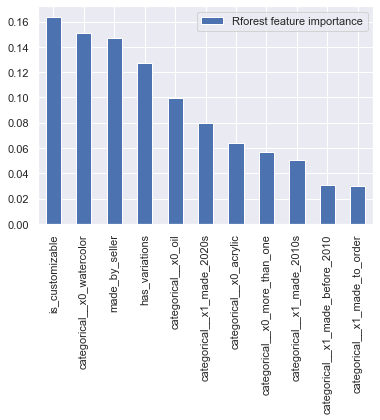

In [376]:
categorical_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 2e) Gradient Boosting Trees using only numerical features¶

In [243]:
from sklearn.ensemble import GradientBoostingRegressor

In [377]:
categorical_gboost_pipe = Pipeline([
    ('categorical selector', categorical_selector),
    ('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=categorical_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [378]:
categorical_gboost_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('categorical selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=6, n_estimators=50,
                                           random_state=1, subsample=0.5))])

In [379]:
#Predict prices on training set:
prices_train_pred = categorical_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
categorical_gboost_pipe.score(paintings_df_train,prices_train)

0.0383581131419658

In [380]:
#Predict prices on test set:
prices_test_pred = categorical_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
categorical_gboost_pipe.score(paintings_df_test,prices_test)

0.03524975736858005

In [381]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using only categorical features')


Gradient Boosting model using only categorical features:
Training R^2: 0.0383581131419658
Testing R^2: 0.03524975736858005
Training RMSE: USD 113.41225376556967
Testing RMSE: USD 113.45014777455265
Training MAE: USD 96.04119225455142
Testing MAE: USD 96.2133430579684


In [382]:
#what are the main features used for decision?
categorical_gboost_pipe['gboost'].feature_importances_

array([0.08473586, 0.09425396, 0.13618902, 0.12096009, 0.07076686,
       0.0675269 , 0.15783319, 0.11799427, 0.14973986])

In [383]:
feature_names_cat_gboost = categorical_gboost_pipe['categorical selector'].get_feature_names()

categorical_gboost_features_imp_df = pd.DataFrame(categorical_gboost_pipe['gboost'].feature_importances_,feature_names_cat_gboost,columns=['Gboost feature importance'])
categorical_gboost_features_imp_df = categorical_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
categorical_gboost_features_imp_df

,Gboost feature importance
made_by_seller,0.157833
has_variations,0.149740
categorical__x0_watercolor,0.136189
categorical__x1_made_2020s,0.120960
is_customizable,0.117994
categorical__x0_oil,0.094254
categorical__x0_more_than_one,0.084736
categorical__x1_made_before_2010,0.070767
categorical__x1_made_to_order,0.067527


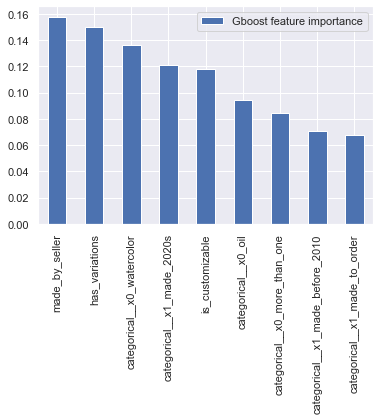

In [384]:
categorical_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 3) Models combining numerical and categorical features, but still no image information or style tags info

#### 3a) Linear regression combining numerical and categorical features

In [385]:
#Note that for numerical features, in this case I use MinMaxScaling instead of StandardScaling, 
#so that all the features are within the same [0,1] range (note that the categorical ones are already in [0,1] by construction)
#Also recall that for Linear Regression I need to drop the first hot-encoded value or I will have multicollinearity problems
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

variable_selector = ColumnTransformer([
    ('categorical', OneHotEncoder(drop='first'), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical',MinMaxScaler(),numerical_columns)
 ], remainder='drop')



In [386]:
preprocessed_variables = variable_selector.fit_transform(paintings_df_train)
preprocessed_variables

array([[0.        , 1.        , 0.        , ..., 0.02889755, 0.12425427,
        0.0057971 ],
       [0.        , 1.        , 0.        , ..., 0.02889755, 0.08743057,
        0.16521739],
       [0.        , 0.        , 0.        , ..., 0.02889755, 0.18041555,
        0.03478261],
       ...,
       [0.        , 0.        , 0.        , ..., 0.07237974, 0.56181856,
        0.0115942 ],
       [0.        , 0.        , 0.        , ..., 0.02889755, 0.17588973,
        0.22608696],
       [0.        , 0.        , 0.        , ..., 0.10136788, 0.31001851,
        0.09565217]])

In [387]:
#confirm all variables are between 0 and 1:
np.max(preprocessed_variables,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [388]:
np.min(preprocessed_variables,axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [389]:
#variable_selector.get_feature_names()
#variable_selector.output_indices_

In [390]:
variable_selector

ColumnTransformer(transformers=[('categorical', OneHotEncoder(drop='first'),
                                 ['painting_type', 'when_made']),
                                ('boolean', 'passthrough',
                                 ['made_by_seller', 'is_customizable',
                                  'has_variations']),
                                ('numerical', MinMaxScaler(),
                                 ['num_favorers', 'featured_rank',
                                  'max_dimension', 'aspect_ratio', 'area',
                                  'weight', 'days_from_original_creation',
                                  'days_from_last_modification'])])

In [391]:
#and then apply LinearRegression within a pipeline
from sklearn.pipeline import Pipeline

num_plus_cat_linreg_pipe = Pipeline([
    ('variable selector', variable_selector),
    ('linear reg', LinearRegression()),
])

In [392]:
#Train the model
num_plus_cat_linreg_pipe.fit(paintings_df_train,prices_train)

Pipeline(steps=[('variable selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('linear reg', LinearRegression())])

In [393]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_linreg_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_linreg_pipe.score(paintings_df_train,prices_train)

0.07920164003347108

In [394]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_linreg_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_linreg_pipe.score(paintings_df_test,prices_test)

0.09499891560248275

In [395]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using numerical features and categorical features with One-hot-encoding')


Linear regression model using numerical features and categorical features with One-hot-encoding:
Training R^2: 0.07920164003347108
Testing R^2: 0.09499891560248275
Training RMSE: USD 110.97766005820172
Testing RMSE: USD 109.8808897631926
Training MAE: USD 93.56759449260517
Testing MAE: USD 92.67704526026384


In [396]:
#Let's look at the coefficients of the model
# intercept
print(num_plus_cat_linreg_pipe['linear reg'].intercept_)

341.7139754187123


In [397]:
num_plus_cat_linreg_pipe['linear reg'].coef_

array([-6.22572415e+00,  2.09469545e+01, -5.47804467e+00, -1.52691271e+01,
       -8.29136280e+00, -1.64735485e+01,  5.81129907e+00, -1.43987923e-01,
        6.14221721e+00,  1.05620560e+02,  5.20586313e+01,  1.76228553e+01,
        2.27991825e+02,  2.97464482e+02,  1.16214054e+02, -2.02596115e+01,
        7.17042222e+00])

In [398]:
#coefficients for each variable:
coeff_df = pd.DataFrame(num_plus_cat_linreg_pipe['linear reg'].coef_,columns=['Lin Reg Coeff']) #categorical_feature_names,columns=['Lin Reg Coeff'])
coeff_df

,Lin Reg Coeff
0,-6.225724
1,20.946954
2,-5.478045
3,-15.269127
4,-8.291363
5,-16.473549
6,5.811299
7,-0.143988
8,6.142217
9,105.620560


#### 3b) Ridge regression combining numerical and categorical features with polynomial features

In [399]:
#For Ridge Regression, I don't really need to 'drop-first' categorical variables when doing OneHotEncoding, because the ridge term already prevents the problem from being ill-posed  
#Note that for numerical features, in this case I use MinMaxScaling instead of StandardScaling, 
#so that all the features are within the same [0,1] range (note that the categorical ones are already in [0,1] by construction)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

variable_selector_for_ridge = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical',MinMaxScaler(),numerical_columns)
 ], remainder='drop')

In [400]:
from sklearn.linear_model import Ridge

num_plus_cat_polyreg_ridge_pipe = Pipeline([('num and cat preproc', variable_selector_for_ridge),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

In [401]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
num_plus_cat_polyreg_ridge_CVmodel = GridSearchCV(num_plus_cat_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [402]:
#Train the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_polyreg_ridge_CVmodel_filename = './Git_exclude/models/num_plus_cat_polyreg_ridge_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_polyreg_ridge_CVmodel_filename, 'rb') as f:
        num_plus_cat_polyreg_ridge_CVmodel = load(f)
        print('Loaded joblib file with numerical-plus-categorical features, ridge regression with polynomial features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_polyreg_ridge_CVmodel_filename, 'wb') as f:
        dump(num_plus_cat_polyreg_ridge_CVmodel, num_plus_cat_polyreg_ridge_CVmodel_filename) 
        print('Saved joblib file with numerical-plus-categorical features, ridge regression with polynomial features.')


Loaded joblib file with numerical-plus-categorical features, ridge regression with polynomial features.


In [403]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_polyreg_ridge_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.15872958364840328

In [404]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_polyreg_ridge_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

0.15626894915230982

In [405]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression using numerical and categorical features with polynomial features')


Ridge regression using numerical and categorical features with polynomial features:
Training R^2: 0.15872958364840328
Testing R^2: 0.15626894915230982
Training RMSE: USD 106.07696940053594
Testing RMSE: USD 106.09615225142689
Training MAE: USD 87.60288125730291
Testing MAE: USD 87.75837286914967


### Model 3c) Decision Tree model combining numerical and categorical features

In [345]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [406]:
#I don't want to drop the first variable for tree-based models (whereas I needed to do those for linear-regression to prevent collinearity)
#and I don't need to scale the numerical variables

variable_selector_for_trees = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    ('boolean','passthrough', boolean_columns),
    ('numerical','passthrough',numerical_columns)
 ], remainder='drop')

In [407]:
num_plus_cat_dtree_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [408]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
num_plus_cat_dtree_CVmodel = GridSearchCV(num_plus_cat_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [535]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_dtree_CVmodel_filename = './Git_exclude/models/num_plus_cat_dtree_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_dtree_CVmodel_filename, 'rb') as f:
        num_plus_cat_dtree_CVmodel = load(f)
        print('Loaded joblib file with decision tree model for numerical-plus-categorical features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_dtree_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_dtree_CVmodel_filename, 'wb') as f:
        dump(num_plus_cat_dtree_CVmodel, num_plus_cat_dtree_CVmodel_filename) 
        print('Saved joblib file with decision tree model for numerical-plus-categorical features.')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    3.8s finished


Saved joblib file with decision tree model for numerical-plus-categorical features.


In [537]:
num_plus_cat_dtree_CVmodel.best_params_

{'dtree__max_depth': 7}

In [538]:
num_plus_cat_dtree_CVmodel

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('num and cat selector',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['painting_type',
                                                                          'when_made']),
                                                                        ('boolean',
                                                                         'passthrough',
                                                                         ['made_by_seller',
                                                                          'is_customizable',
                                                                          'has_variations']),
                                                                        ('numerical',
                                                                         'passthrough',
                                                                         ['num_favorers',
                                                                          'featured_rank',
                                                                          'max_dimension',
                                                                          'aspect_ratio',
                                                                          'area',
                                                                          'weight',
                                                                          'days_from_original_creation',
                                                                          'days_from_last_modification'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [411]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_dtree_CVmodel.score(paintings_df_train,prices_train)

0.1831335994848099

In [412]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_dtree_CVmodel.score(paintings_df_test,prices_test)

0.1551264877103924

In [413]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using numerical + categorical features')


Decision Tree model using numerical + categorical features:
Training R^2: 0.1831335994848099
Testing R^2: 0.1551264877103924
Training RMSE: USD 104.52707833679271
Testing RMSE: USD 106.16795816581914
Training MAE: USD 84.96525881147181
Testing MAE: USD 86.58115044768397


In [414]:
#what are the main features used for decision?
num_plus_cat_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.00282664, 0.        , 0.05079082, 0.        , 0.01017237,
       0.02308698, 0.00147569, 0.00492021, 0.04871086, 0.003343  ,
       0.00450674, 0.01259694, 0.02000393, 0.3985573 , 0.02108415,
       0.15295706, 0.14864621, 0.0648445 , 0.03147657])

In [415]:
feature_names_num_plus_cat_dtree = num_plus_cat_dtree_CVmodel.best_estimator_['num and cat selector'].get_feature_names()

num_plus_cat_dtree_features_imp_df = pd.DataFrame(num_plus_cat_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_num_plus_cat_dtree,columns=['Dtree feature importance'])
num_plus_cat_dtree_features_imp_df = num_plus_cat_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
num_plus_cat_dtree_features_imp_df

,Dtree feature importance
max_dimension,0.398557
area,0.152957
weight,0.148646
days_from_original_creation,0.064844
categorical__x0_oil,0.050791
made_by_seller,0.048711
days_from_last_modification,0.031477
categorical__x1_made_2020s,0.023087
aspect_ratio,0.021084
featured_rank,0.020004


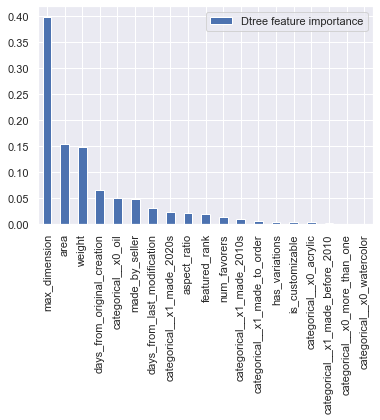

In [417]:
num_plus_cat_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

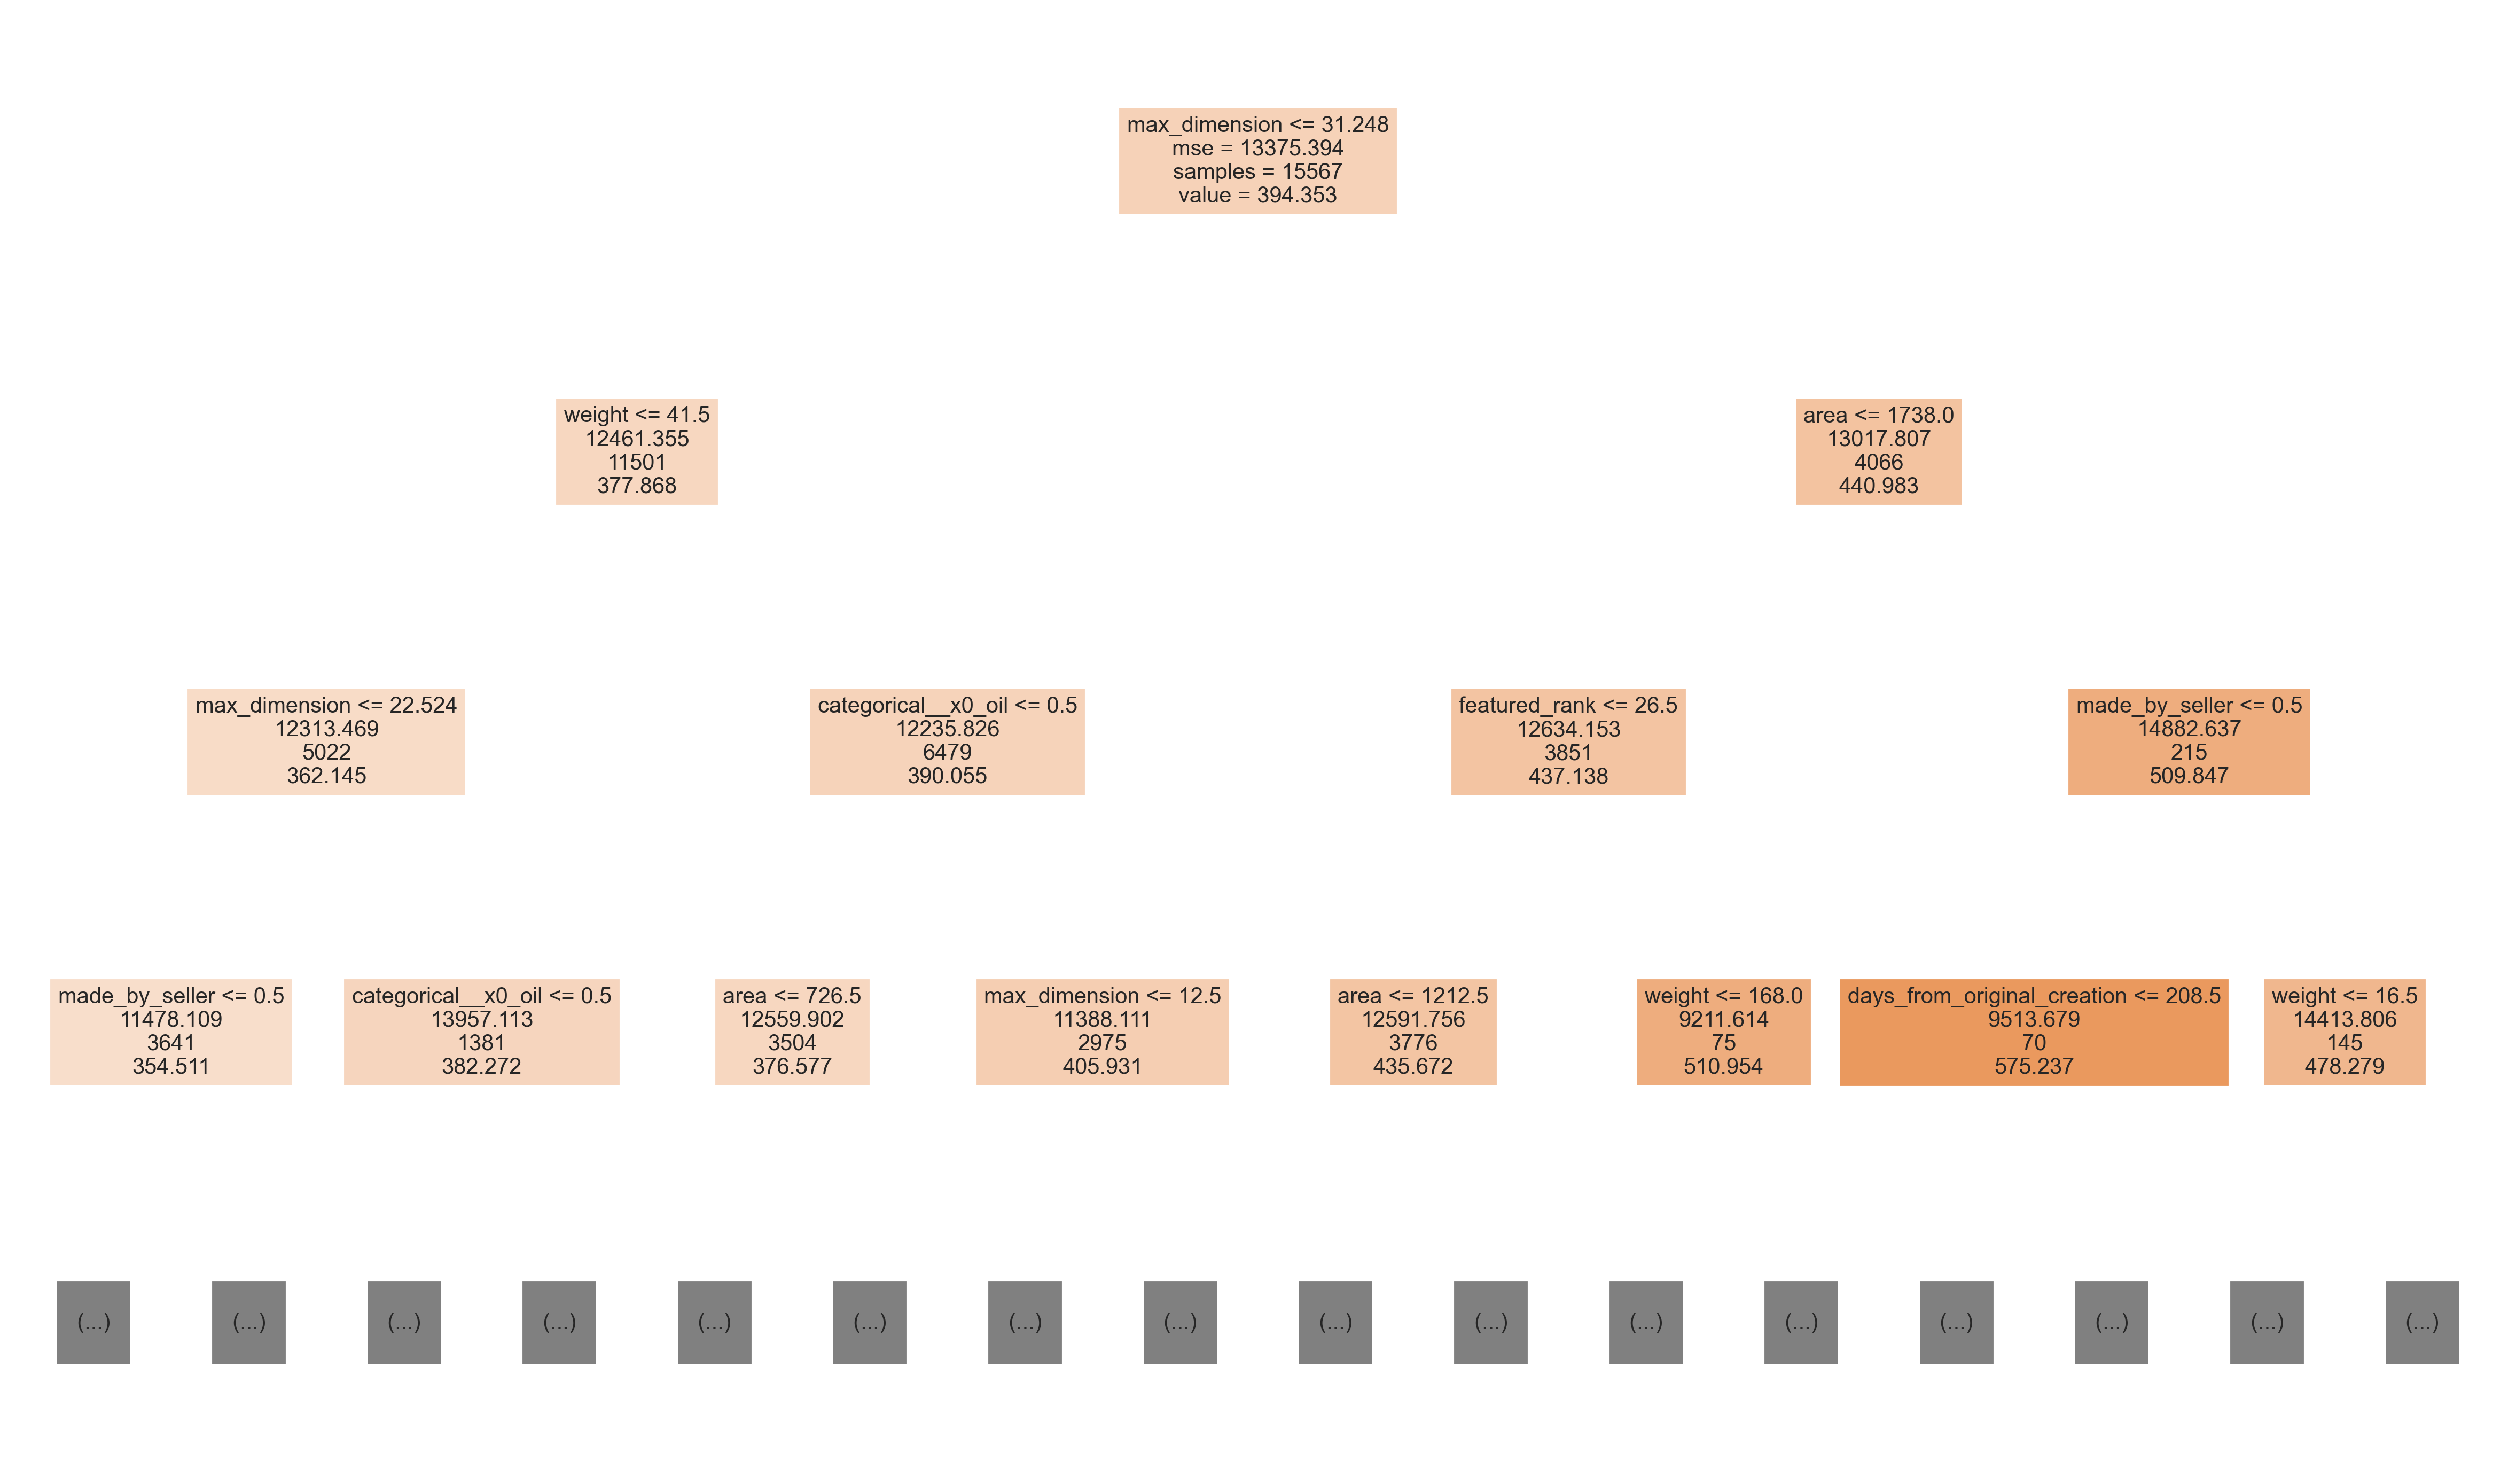

In [418]:
# Generate a plot of the decision tree
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,12), dpi=300)
plt.figure(figsize=(20,12), dpi=300)
tree_viz = plot_tree(num_plus_cat_dtree_CVmodel.best_estimator_['dtree'],max_depth=3,fontsize=10,label='root',filled=True,feature_names = feature_names_num_plus_cat_dtree)
fig.savefig('./Git_exclude/Figures/decision_tree_numerical_plus_categorical.png')

# #export_graphviz(categorical_tree_pipe['decision tree'],out_file=None)
# #graphviz.Source(tree.export_graphviz(tree_reg, out_file=None))

#### Model 3d) Random Forest combining numerical and categorical features

In [419]:
from sklearn.ensemble import RandomForestRegressor

In [434]:
num_plus_cat_rforest_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    ('rforest', RandomForestRegressor(n_estimators=50,max_features='sqrt',n_jobs=2,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']+1,random_state=1,max_samples=0.8))
])

In [542]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_rforest_pipe_filename = './Git_exclude/models/num_plus_cat_rforest_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_rforest_pipe_filename, 'rb') as f:
        num_plus_cat_rforest_pipe = load(f)
        print('Loaded joblib file with random forest model for numerical-plus-categorical features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_rforest_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_rforest_pipe_filename, 'wb') as f:
        dump(num_plus_cat_rforest_pipe, num_plus_cat_rforest_pipe_filename) 
        print('Saved joblib file with random forest model for numerical-plus-categorical features.')

Loaded joblib file with random forest model for numerical-plus-categorical features.


In [543]:
num_plus_cat_rforest_pipe

Pipeline(steps=[('num and cat selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('rforest',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       max_samples=0.8, n_estimators=50,
                                       n_jobs=2, random_state=1))])

In [544]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_rforest_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_rforest_pipe.score(paintings_df_train,prices_train)

0.22740261699457864

In [545]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_rforest_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_rforest_pipe.score(paintings_df_test,prices_test)

0.19740127984384515

In [546]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Random Forest model using numerical + categorical features')


Random Forest model using numerical + categorical features:
Training R^2: 0.22740261699457864
Testing R^2: 0.19740127984384515
Training RMSE: USD 101.65527308569912
Testing RMSE: USD 103.47771954394683
Training MAE: USD 83.91016642257489
Testing MAE: USD 85.6301295003132


In [439]:
#what are the main features used for decision?
num_plus_cat_rforest_pipe['rforest'].feature_importances_

array([0.01253024, 0.00551819, 0.0318036 , 0.01251242, 0.01507278,
       0.01590001, 0.01193429, 0.00516477, 0.01823589, 0.01134556,
       0.01521422, 0.03552467, 0.01895153, 0.1990323 , 0.08623826,
       0.23166927, 0.13299607, 0.07947179, 0.06088414])

In [440]:
feature_names_num_plus_cat_rforest = num_plus_cat_rforest_pipe['num and cat selector'].get_feature_names()

num_plus_cat_rforest_features_imp_df = pd.DataFrame(num_plus_cat_rforest_pipe['rforest'].feature_importances_,feature_names_num_plus_cat_rforest,columns=['Rforest feature importance'])
num_plus_cat_rforest_features_imp_df = num_plus_cat_rforest_features_imp_df.sort_values(by='Rforest feature importance',ascending=False)
num_plus_cat_rforest_features_imp_df

,Rforest feature importance
area,0.231669
max_dimension,0.199032
weight,0.132996
aspect_ratio,0.086238
days_from_original_creation,0.079472
days_from_last_modification,0.060884
num_favorers,0.035525
categorical__x0_oil,0.031804
featured_rank,0.018952
made_by_seller,0.018236


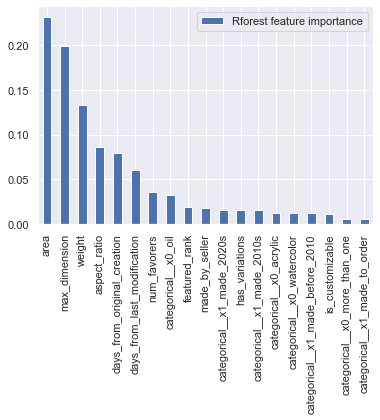

In [442]:
num_plus_cat_rforest_features_imp_df.plot(kind="bar").legend(loc="upper right");

#### Model 3e) Gradient Boosting Trees combining numerical and categorical features

In [443]:
from sklearn.ensemble import GradientBoostingRegressor

In [492]:
num_plus_cat_gboost_pipe = Pipeline([
    ('num and cat selector', variable_selector_for_trees),
    #('gboost', GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,subsample=0.75,max_depth=3,random_state=1))
    ('gboost', GradientBoostingRegressor(n_estimators=80,learning_rate=0.1,subsample=0.75,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']-3,random_state=1))
    #('gboost', GradientBoostingRegressor(n_estimators=50,learning_rate=0.1,subsample=0.5,max_depth=num_plus_cat_dtree_CVmodel.best_params_['dtree__max_depth']-1,random_state=1))
])

In [547]:
#Train and possibly save the model
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

num_plus_cat_gboost_pipe_filename = './Git_exclude/models/num_plus_cat_gboost_pipe.joblib'

#If the model file already exists, I load it:
try:
    with open(num_plus_cat_gboost_pipe_filename, 'rb') as f:
        num_plus_cat_gboost_pipe = load(f)
        print('Loaded joblib file with gradient boosting model for numerical-plus-categorical features.')
except: #if not, actually perform the fit then save the model for next time:
    
    num_plus_cat_gboost_pipe.fit(paintings_df_train,prices_train);
    
    with open(num_plus_cat_gboost_pipe_filename, 'wb') as f:
        dump(num_plus_cat_gboost_pipe, num_plus_cat_gboost_pipe_filename) 
        print('Saved joblib file with gradient boosting model for numerical-plus-categorical features.')

Saved joblib file with gradient boosting model for numerical-plus-categorical features.


In [548]:
num_plus_cat_gboost_pipe

Pipeline(steps=[('num and cat selector',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['painting_type',
                                                   'when_made']),
                                                 ('boolean', 'passthrough',
                                                  ['made_by_seller',
                                                   'is_customizable',
                                                   'has_variations']),
                                                 ('numerical', 'passthrough',
                                                  ['num_favorers',
                                                   'featured_rank',
                                                   'max_dimension',
                                                   'aspect_ratio', 'area',
                                                   'weight',
                                                   'days_from_original_creation',
                                                   'days_from_last_modification'])])),
                ('gboost',
                 GradientBoostingRegressor(max_depth=4, n_estimators=80,
                                           random_state=1, subsample=0.75))])

In [494]:
#Predict prices on training set:
prices_train_pred = num_plus_cat_gboost_pipe.predict(paintings_df_train)
#And return the R2 score as follows:
num_plus_cat_gboost_pipe.score(paintings_df_train,prices_train)

0.21853069043463902

In [495]:
#Predict prices on test set:
prices_test_pred = num_plus_cat_gboost_pipe.predict(paintings_df_test)
#And return the R2 score as follows:
num_plus_cat_gboost_pipe.score(paintings_df_test,prices_test)

0.19588634722632747

In [496]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Gradient Boosting model using numerical plus categorical features')


Gradient Boosting model using numerical plus categorical features:
Training R^2: 0.21853069043463902
Testing R^2: 0.19588634722632747
Training RMSE: USD 102.2372733452536
Testing RMSE: USD 103.57533237649564
Training MAE: USD 84.18704967590178
Testing MAE: USD 85.48800381260202


In [497]:
#what are the main features used for decision?
num_plus_cat_gboost_pipe['gboost'].feature_importances_

array([0.002253  , 0.00525118, 0.04871988, 0.0020959 , 0.01522949,
       0.00758489, 0.00688238, 0.00477778, 0.03651236, 0.01163264,
       0.01501816, 0.02355479, 0.01749566, 0.30676744, 0.0590663 ,
       0.1284971 , 0.1347326 , 0.10173462, 0.07219381])

In [498]:
feature_names_num_plus_cat_gboost = num_plus_cat_gboost_pipe['num and cat selector'].get_feature_names()

num_plus_cat_gboost_features_imp_df = pd.DataFrame(num_plus_cat_gboost_pipe['gboost'].feature_importances_,feature_names_num_plus_cat_gboost,columns=['Gboost feature importance'])
num_plus_cat_gboost_features_imp_df = num_plus_cat_gboost_features_imp_df.sort_values(by='Gboost feature importance',ascending=False)
num_plus_cat_gboost_features_imp_df

,Gboost feature importance
max_dimension,0.306767
weight,0.134733
area,0.128497
days_from_original_creation,0.101735
days_from_last_modification,0.072194
aspect_ratio,0.059066
categorical__x0_oil,0.048720
made_by_seller,0.036512
num_favorers,0.023555
featured_rank,0.017496


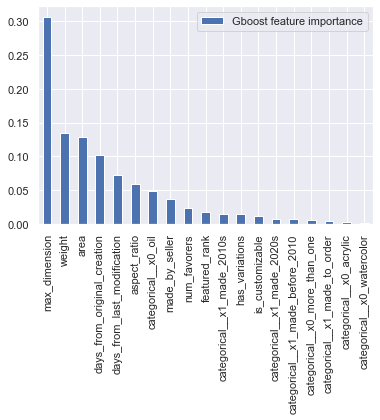

In [499]:
num_plus_cat_gboost_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 4) Models also using the mean colors in the painting as provided by Etsy (which may or may not be accurate)

### Model 4a) Linear regression using only mean image features

In [500]:
image_mean_selector = ColumnTransformer([
    ('image_mean', 'passthrough', image_columns),
], remainder='drop')

In [501]:
#and then do the scaling of part of a Pipeline, e.g.
from sklearn.pipeline import Pipeline

image_mean_preproc_pipe = Pipeline([
    ('image mean selector', image_mean_selector),
    ('minmax scaling', MinMaxScaler()),
])

In [502]:
from sklearn.linear_model import LinearRegression

meanimage_linreg_pipe = Pipeline([('image mean preproc', image_mean_preproc_pipe),
                      ('linear reg', LinearRegression())])

In [503]:
#Train the model
meanimage_linreg_pipe.fit(paintings_df_train,prices_train);

In [504]:
#Predict prices on training set:
prices_train_pred = meanimage_linreg_pipe.predict(paintings_df_train)

In [505]:
#And return the R2 score as follows:
meanimage_linreg_pipe.score(paintings_df_train,prices_train)

0.001928421065628072

In [506]:
#Predict prices on test set:
prices_test_pred = meanimage_linreg_pipe.predict(paintings_df_test)

In [507]:
#And return the R2 score as follows:
meanimage_linreg_pipe.score(paintings_df_test,prices_test)

-0.002898599914475275

In [508]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Linear regression model using only mean image info')

Linear regression model using only mean image info:
Training R^2: 0.001928421065628072
Testing R^2: -0.002898599914475275
Training RMSE: USD 115.54047254467004
Testing RMSE: USD 115.67143680855257
Training MAE: USD 98.67095082579894
Testing MAE: USD 98.95511700695512


### Model 4b) Polynomial regression using only mean image features

In [509]:
from sklearn.linear_model import Ridge

meanimage_polyreg_ridge_pipe = Pipeline([('image mean preproc', image_mean_preproc_pipe),
                      ('polynomial_trans', PolynomialFeatures(degree=3,include_bias=False)),            
                      ('ridge', Ridge(alpha=10))])

In [510]:
from sklearn.model_selection import GridSearchCV

#I will then need to search for the right alpha using Cross Validation:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
meanimage_polyreg_ridge_CVmodel = GridSearchCV(meanimage_polyreg_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [511]:
#Train the model
meanimage_polyreg_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   11.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('image mean preproc',
                                        Pipeline(steps=[('image mean selector',
                                                         ColumnTransformer(transformers=[('image_mean',
                                                                                          'passthrough',
                                                                                          ['image_red',
                                                                                           'image_green',
                                                                                           'image_blue',
                                                                                           'image_hue',
                                                                                           'image_saturation',
                                                                                           'image_brightness'])])),
                                                        ('minmax scaling',
                                                         MinMaxScaler())])),
                                       ('polynomial_trans',
                                        PolynomialFeatures(degree=3,
                                                           include_bi...
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [512]:
meanimage_polyreg_ridge_CVmodel.best_params_

{'ridge__alpha': 6.951927961775605}

In [513]:
#Predict prices on training set:
prices_train_pred = meanimage_polyreg_ridge_CVmodel.predict(paintings_df_train)

In [514]:
#And return the R2 score as follows:
meanimage_polyreg_ridge_CVmodel.score(paintings_df_train,prices_train)

0.003812846400373715

In [515]:
#Predict prices on test set:
prices_test_pred = meanimage_polyreg_ridge_CVmodel.predict(paintings_df_test)

In [516]:
#And return the R2 score as follows:
meanimage_polyreg_ridge_CVmodel.score(paintings_df_test,prices_test)

-0.0008211807788558456

In [517]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Polynomial ridge regression model using only mean image info')

Polynomial ridge regression model using only mean image info:
Training R^2: 0.003812846400373715
Testing R^2: -0.0008211807788558456
Training RMSE: USD 115.43134697375764
Testing RMSE: USD 115.55157293368704
Training MAE: USD 98.54669933465834
Testing MAE: USD 98.81018140580922


In [518]:
#So it doesn't look like the mean image colors - as provided by Etsy at least - are very useful at all - but let's also try with tree-based models to see if things change

### Model 4c) Decision tree model using only mean image features

In [519]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import pydot
#import graphviz

In [520]:
# #Recall that I already have the image mean selector, which need not change:
# image_mean_selector = ColumnTransformer([
#     ('image_mean', 'passthrough', image_columns),
# ], remainder='drop')

In [521]:
#there's no need to rescale for tree-based algorithms, so I can jump straight to the Pipeline performing the regression
from sklearn.pipeline import Pipeline

meanimage_dtree_pipe = Pipeline([
    ('image mean selector', image_mean_selector),
    ('dtree', DecisionTreeRegressor(max_depth=3)),
])

In [522]:
#Let's use GridSearchCV to try different tree depths
from sklearn.model_selection import GridSearchCV

param_grid = {'dtree__max_depth': range(2,11,1)} #np.linspace(0,10,1)} 
meanimage_dtree_CVmodel = GridSearchCV(meanimage_dtree_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [523]:
meanimage_dtree_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:    3.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('image mean selector',
                                        ColumnTransformer(transformers=[('image_mean',
                                                                         'passthrough',
                                                                         ['image_red',
                                                                          'image_green',
                                                                          'image_blue',
                                                                          'image_hue',
                                                                          'image_saturation',
                                                                          'image_brightness'])])),
                                       ('dtree',
                                        DecisionTreeRegressor(max_depth=3))]),
             n_jobs=2, param_grid={'dtree__max_depth': range(2, 11)},
             verbose=1)

In [524]:
meanimage_dtree_CVmodel.best_params_['dtree__max_depth']

2

In [525]:
#Predict prices on training set:
prices_train_pred = meanimage_dtree_CVmodel.predict(paintings_df_train)
#And return the R2 score as follows:
meanimage_dtree_CVmodel.score(paintings_df_train,prices_train)

0.002860441324474272

In [526]:
#Predict prices on test set:
prices_test_pred = meanimage_dtree_CVmodel.predict(paintings_df_test)
#And return the R2 score as follows:
meanimage_dtree_CVmodel.score(paintings_df_test,prices_test)

-8.715612748999568e-05

In [527]:
#Print results using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Decision Tree model using only mean image features (provided by Etsy)')


Decision Tree model using only mean image features (provided by Etsy):
Training R^2: 0.002860441324474272
Testing R^2: -8.715612748999568e-05
Training RMSE: USD 115.48651288134302
Testing RMSE: USD 115.50919110655713
Training MAE: USD 98.62087469333322
Testing MAE: USD 98.76552929212326


In [531]:
#it seems that the mean image (at least as provided by Etsy) has basically no predictive power, so there's no need to continue investigating this or to also try random forests
meanimage_dtree_CVmodel.best_estimator_['dtree'].feature_importances_

array([0.        , 0.        , 0.22005025, 0.2496953 , 0.        ,
       0.53025444])

In [532]:
feature_names_meanimage_dtree = meanimage_dtree_CVmodel.best_estimator_['image mean selector'].get_feature_names()

meanimage_dtree_features_imp_df = pd.DataFrame(meanimage_dtree_CVmodel.best_estimator_['dtree'].feature_importances_,feature_names_meanimage_dtree,columns=['Dtree feature importance'])
meanimage_dtree_features_imp_df = meanimage_dtree_features_imp_df.sort_values(by='Dtree feature importance',ascending=False)
meanimage_dtree_features_imp_df

,Dtree feature importance
image_brightness,0.530254
image_hue,0.249695
image_blue,0.220050
image_red,0.000000
image_green,0.000000
image_saturation,0.000000


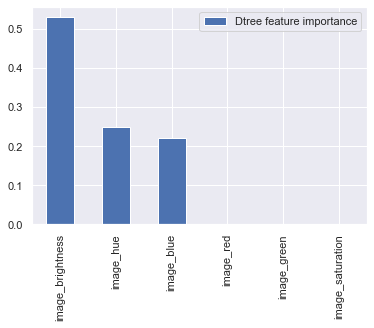

In [533]:
meanimage_dtree_features_imp_df.plot(kind="bar").legend(loc="upper right");

## 5) Models using only the 'style' tags

In [156]:
#Here I can't just use OneHotEncoding, because because there can be multiple tags for the same listing, i.e. the 'new_style_tags' for a painting could be a list like: ['Abstract','Contemporary','Modern']

In [157]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].iloc[1]

"['abstract', 'landscape']"

In [158]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].value_counts()

['abstract']                                                      1967
['landscape']                                                     1413
['contemporary art']                                              1071
['portrait']                                                       732
['abstract', 'modern']                                             585
                                                                  ... 
['impressionism', 'nude']                                            1
['mediterranean', 'impressionism', 'victorian']                      1
['avant garde', 'art nouveau']                                       1
['beach', 'art deco', 'abstract', 'contemporary', 'landscape']       1
['beach', 'mid century modern']                                      1
Name: style_tags_new, Length: 2327, dtype: int64

In [159]:
#I can use the 'DictVectorizer' provided by scikit-learn. 
#This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value 
#associated with it. Missing keys are filled with zeros. However, before I can use 'DictVectorizer' I need to convert my list of strings into array of dictionaries.
#I do that with a 'DictEncoder' defined as follows:

In [160]:
def stringlist_to_dict(stringlist):
    dict = {}
    for string in stringlist:
        dict[string]=1
    return dict

In [161]:
from sklearn.base import BaseEstimator, TransformerMixin
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series of strings representing lists of strings. Return a pandas series of dictionaries
        return X.apply(eval).apply(stringlist_to_dict)

In [162]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].apply(eval).apply(stringlist_to_dict)

0                                           {'vintage': 1}
1                          {'abstract': 1, 'landscape': 1}
2                       {'streetscape': 1, 'landscape': 1}
3        {'southwestern': 1, 'cityscape': 1, 'landscape...
4                                 {'modern': 1, 'folk': 1}
                               ...                        
19454                   {'abstract': 1, 'contemporary': 1}
19455                               {'impressionistic': 1}
19456                                     {'landscape': 1}
19457                       {'art deco': 1, 'abstract': 1}
19458                   {'expressionism': 1, 'vintage': 1}
Name: style_tags_new, Length: 19459, dtype: object

In [163]:
from sklearn.feature_extraction import DictVectorizer

pipe_style_tags_encoding = Pipeline([
    ('to dict series',DictEncoder()),
    ('to binary vectors',DictVectorizer())
])

In [164]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
style_tranform = ColumnTransformer([
    ('style tags vectorizer', pipe_style_tags_encoding, 'style_tags_new'),
], remainder='drop')

In [165]:
#Let's test this in isolation
style_tranform.fit_transform(paintings_df_train)

<15567x146 sparse matrix of type '<class 'numpy.float64'>'
	with 29378 stored elements in Compressed Sparse Row format>

### 5a) Ridge regression of style tags only, after vectorization

Since there are a large number of features, one for each category, cross validation is critical to prevent overfitting.

In [166]:
from sklearn.linear_model import Ridge

stlye_ridge_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('ridge',Ridge(alpha=10))
])

In [167]:
#Let's see if the pipeline works (i.e. can be fit successfully)
stlye_ridge_pipe.fit(paintings_df_train,prices_train)


Pipeline(steps=[('style tags vectorization',
                 ColumnTransformer(transformers=[('style tags vectorizer',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictEncoder()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'style_tags_new')])),
                ('ridge', Ridge(alpha=10))])

In [168]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
style_ridge_CVmodel = GridSearchCV(stlye_ridge_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [169]:
#Train the model
style_ridge_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   18.3s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('style tags vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'style_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [170]:
style_ridge_CVmodel.best_params_

{'ridge__alpha': 18.329807108324356}

In [171]:
#Predict prices on training set:
prices_train_pred = style_ridge_CVmodel.predict(paintings_df_train)

In [172]:
#And return the R2 score as follows:
style_ridge_CVmodel.score(paintings_df_train,prices_train)

0.0408812466215982

In [173]:
#Predict prices on test set:
prices_test_pred = style_ridge_CVmodel.predict(paintings_df_test)

In [174]:
#And return the R2 score as follows:
style_ridge_CVmodel.score(paintings_df_test,prices_test)

0.038452433829408106

In [175]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using the vectorized style tags')

Ridge regression model using the vectorized style tags:
Training R^2: 0.0408812466215982
Testing R^2: 0.038452433829408106
Training RMSE: USD 113.26337183444417
Testing RMSE: USD 113.26168129320132
Training MAE: USD 95.47771592343366
Testing MAE: USD 95.60624147056286


### 5b) Ridge regression of style tags only, after Tf-Idf vectorization 

In [176]:
from sklearn.feature_extraction.text import TfidfTransformer #TfidfVectorizer

In [177]:
from sklearn.linear_model import Ridge

stlye_ridge_w_tfidf_pipe = Pipeline([
    ('style tags vectorization', style_tranform),
    ('tfid', TfidfTransformer()), 
    ('ridge',Ridge(alpha=10))
])

In [178]:
#Let's see if the pipeline works (i.e. can be fit successfully)
stlye_ridge_w_tfidf_pipe.fit(paintings_df_train,prices_train)


Pipeline(steps=[('style tags vectorization',
                 ColumnTransformer(transformers=[('style tags vectorizer',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictEncoder()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'style_tags_new')])),
                ('tfid', TfidfTransformer()), ('ridge', Ridge(alpha=10))])

In [179]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ridge__alpha': np.logspace(0,8,20)} 
style_ridge_w_tfidf_CVmodel = GridSearchCV(stlye_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [180]:
#Train the model
style_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   18.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('style tags vectorization',
                                        ColumnTransformer(transformers=[('style '
                                                                         'tags '
                                                                         'vectorizer',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictEncoder()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'style_tags_new')])),
                                       ('tfid', TfidfTransformer()),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e+00, 2.63665090e+00, 6.95192796e+00, 1.83298071e+01,
       4.83293024e+01, 1.27427499e+02, 3.35981829e+02, 8.85866790e+02,
       2.33572147e+03, 6.15848211e+03, 1.62377674e+04, 4.28133240e+04,
       1.12883789e+05, 2.97635144e+05, 7.84759970e+05, 2.06913808e+06,
       5.45559478e+06, 1.43844989e+07, 3.79269019e+07, 1.00000000e+08])},
             verbose=1)

In [181]:
style_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 6.951927961775605}

In [182]:
#Predict prices on training set:
prices_train_pred = style_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [183]:
#And return the R2 score as follows:
style_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.0399729530705244

In [184]:
#Predict prices on test set:
prices_test_pred = style_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [185]:
#And return the R2 score as follows:
style_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.03579343449025474

In [186]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized style tags with Tf-Idf')

Ridge regression model using vectorized style tags with Tf-Idf:
Training R^2: 0.0399729530705244
Testing R^2: 0.03579343449025474
Training RMSE: USD 113.3169898276131
Testing RMSE: USD 113.41817631739755
Training MAE: USD 95.70598265497095
Testing MAE: USD 95.89999444826387


### A different method of implementing Tf-Idf - instead of going through the DictVectorizer - is to use more traditional NLP techniques with TfIdfVectorizer, that enables to also use n-grams (i.e. sequences of words in addition to individual words) 
#### The TfIdfVectorizer takes a single string per document (row), so I need to first process the 'tags' column as follows (essentially joining the strings in the list)

In [187]:
from sklearn.base import BaseEstimator, TransformerMixin
class TagsEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series of strings representing lists of strings. Return a pandas series of single strings containing all individual strings joined by a space
        return X.apply(eval).apply(lambda stringlist:' '.join(stringlist))

In [188]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].iloc[1]

"['abstract', 'landscape']"

In [189]:
paintings_with_style_tags_and_image_info_df['style_tags_new'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0                                 vintage
1                      abstract landscape
2                   streetscape landscape
3        southwestern cityscape landscape
4                             modern folk
                       ...               
19454               abstract contemporary
19455                     impressionistic
19456                           landscape
19457                   art deco abstract
19458               expressionism vintage
Name: style_tags_new, Length: 19459, dtype: object

In [190]:
#A TfIdfVectorizer should then follow, where I can even try to count n-grams of 2 words

In [191]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipe_tags_encoding = Pipeline([
    ('to single string',TagsEncoder()),
    ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
])

In [457]:
#now I can run the 'style_tags_new' column through this Encoder-Vectorizer sequence of steps
style_tags_tranform = ColumnTransformer([
    ('style tags tfidf', pipe_tags_encoding, 'style_tags_new'),
], remainder='drop')

In [193]:
#the above transformation gives a sparse matrix with non-zero elements contained between 0 and 1
style_tags_tranform.fit_transform(paintings_with_style_tags_and_image_info_df).max(axis=0).max()

1.0

In [194]:
style_tags_tranform.fit_transform(paintings_with_style_tags_and_image_info_df).min(axis=0).max()

0.0

In [195]:
style_tags_tranform.fit_transform(paintings_with_style_tags_and_image_info_df).max(axis=0).mean()

0.6286321512915763

In [196]:
style_tags_tranform.named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()[:10]

['21st',
 '21st century',
 'abstr',
 'abstract',
 'abstract architectural',
 'abstract art',
 'abstract artistic',
 'abstract asian',
 'abstract beach',
 'abstract contemporary']

In [197]:
style_tags_tranform.named_transformers_['style tags tfidf']['to tfidf n-grams'].idf_

array([ 8.57353126,  8.57353126, 10.18296918, ...,  9.26667844,
        9.77750407,  8.10352763])

In [198]:
#Here is the new version of the pipeline

In [199]:
from sklearn.linear_model import Ridge

style_tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', style_tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [200]:
#Let's see if the pipeline works (i.e. can be fit successfully)
style_tags_ridge_w_tfidf_pipe.fit(paintings_df_train,prices_train)


Pipeline(steps=[('tags tfidf vectorization',
                 ColumnTransformer(transformers=[('tags tfidf',
                                                  Pipeline(steps=[('to single '
                                                                   'string',
                                                                   TagsEncoder()),
                                                                  ('to tfidf '
                                                                   'n-grams',
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'style_tags_new')])),
                ('ridge', Ridge(alpha=10))])

In [201]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
style_tags_ridge_w_tfidf_CVmodel = GridSearchCV(style_tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [202]:
#Train the model
style_tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   12.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'style_tags_new')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [203]:
style_tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 4.0}

In [204]:
#What are the style words or word combos that are weighted the most by the regressor?
np.argmax(style_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_)

138

In [205]:
style_tags_tranform.named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()[138]

'art vintage'

In [206]:
#Predict prices on training set:
prices_train_pred = style_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [207]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.09855760669179703

In [208]:
#Predict prices on test set:
prices_test_pred = style_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [209]:
#And return the R2 score as follows:
style_tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.05900534805253366

In [210]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf (n-grams up to 2)')

Ridge regression model using vectorized tags with Tf-Idf (n-grams up to 2):
Training R^2: 0.09855760669179703
Testing R^2: 0.05900534805253366
Training RMSE: USD 109.80504245276518
Testing RMSE: USD 112.04466830290326
Training MAE: USD 91.43434920871508
Testing MAE: USD 93.53941806069851


In [211]:
style_tags_ridge_w_tfidf_CVmodel.best_estimator_[0]

ColumnTransformer(transformers=[('tags tfidf',
                                 Pipeline(steps=[('to single string',
                                                  TagsEncoder()),
                                                 ('to tfidf n-grams',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)))]),
                                 'style_tags_new')])

## 6) Models using other tags in place of style

### 6a) Model using the 'regular' tags, that have more than style information

In [306]:
paintings_with_style_tags_and_image_info_df['tags'].iloc[1]

"['original painting', 'surreal', 'surrealism', 'mouth', 'eye', 'canvas', 'abstract', 'landscape', 'dark', 'shapeshifter', 'madness', 'face', 'morph']"

In [307]:
paintings_with_style_tags_and_image_info_df['tags'].value_counts()

['Oil painting', 'original', 'framed', 'canvas', 'antique', 'vintage', 'wall art', 'picture']                                                                                                                                                                           44
['Oil painting', 'original', 'framed', 'canvas', 'antique', 'vintage', 'wall art', 'picture', 'signed', 'modern', 'abstract']                                                                                                                                           40
['modern', 'impressionism', 'abstract', 'painting', 'art', 'expressionism', 'expressionist', 'contemporary', 'signed', 'artist', 'landscape', 'sky', 'clouds']                                                                                                          29
[]                                                                                                                                                                                                     

In [308]:
#Here, I will certainly need to use more traditional NLP with TfIdfVEctorizer (as in the last version of the style tags regressor). 
' '.join(eval(paintings_with_style_tags_and_image_info_df['tags'].iloc[1]))

'original painting surreal surrealism mouth eye canvas abstract landscape dark shapeshifter madness face morph'

In [309]:
paintings_with_style_tags_and_image_info_df['tags'].apply(eval).apply(lambda stringlist:' '.join(stringlist))

0        toys plane vintage children nursery baby decor...
1        original painting surreal surrealism mouth eye...
2        original painting landscape japan kanazawa str...
3        landscape adobe santa fe new mexico historic a...
4        custom portrait Pet portrait Custom pet portra...
                               ...                        
19454    abstract turquoise black big wall art large wa...
19455    Original wall art paint pouring impressionisti...
19456    field red flower petal yellow green pink white...
19457    abstract art abstract art deco wall deco acryl...
19458    canvas art paint artist expressionism Charlest...
Name: tags, Length: 19459, dtype: object

In [310]:
#A TfIdfVectorizer should then follow, where I can even try to count n-grams of 2 words


In [311]:
#I run the 'tags' column through the Encoder-TfIdf Vectorizer sequence of steps discussed above 
tags_tranform = ColumnTransformer([
    ('tags tfidf', pipe_tags_encoding, 'tags'),
], remainder='drop')

In [312]:
from sklearn.linear_model import Ridge

tags_ridge_w_tfidf_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [313]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
tags_ridge_w_tfidf_CVmodel = GridSearchCV(tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [314]:
#Train the model
tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   27.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   30.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'tags')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [315]:
tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 2.0}

In [316]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [317]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.5395285649625197

In [318]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [319]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.20103283824300555

In [320]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf')

Ridge regression model using vectorized tags with Tf-Idf:
Training R^2: 0.5395285649625197
Testing R^2: 0.20103283824300555
Training RMSE: USD 78.47921352708043
Testing RMSE: USD 103.2433487305987
Training MAE: USD 63.86997025820401
Testing MAE: USD 83.72063358125749


In [321]:
#What are the style words or word combos that are weighted the most by the regressor?
np.argmax(tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_)

46642

In [323]:
tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()[46642]
#tags_tranform.named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()[46642]

'large'

In [324]:
len(tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_)

90295

In [325]:
import heapq
max_10_ridge_coefficients = heapq.nlargest(10,tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_)
max_10_ridge_coefficients

[172.74164743461742,
 171.61761722792593,
 157.48110054988567,
 147.42427571515384,
 140.8100740713622,
 139.8725076247224,
 126.55941087867068,
 125.48045504827721,
 125.36733485532316,
 124.01871271652462]

In [326]:
#find the indices of the 10 largest coefficients
max_10_indices = np.argpartition(tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_, -10)[-10:]

In [327]:
max_10_indices

array([ 7579, 24237, 43232, 85424, 19580, 46642,  5710, 19073, 38312,
        6099], dtype=int64)

In [328]:
#the top 10 need to then be sorted
max_10_indices = max_10_indices[np.argsort(tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_[max_10_indices])]

In [329]:
max_10_indices = max_10_indices[::-1]

In [330]:
max_10_indices

array([46642, 19073,  5710,  6099, 85424, 38312, 19580, 43232, 24237,
        7579], dtype=int64)

In [331]:
tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_[max_10_indices]

array([172.74164743, 171.61761723, 157.48110055, 147.42427572,
       140.81007407, 139.87250762, 126.55941088, 125.48045505,
       125.36733486, 124.01871272])

In [332]:
#so what are the words/pairs of words corresponding to these indices?
for i in range(0,10,1):
    print(tags_ridge_w_tfidf_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()[max_10_indices[i]])

large
coa contemporary
art collectibles
art for
vivid
handpainting
collectibles
ireland
decor home
art vintage


#### Let's try a few things to reduce the overfitting of the training set (note that R^2 in training set is much better than test set)

In [239]:
#First option was to try LASSO instead of Ridge Regression (as this would tend to send more weights to 0) but the training was taking too long 

In [240]:
#Second option is to reduce the max number of features considered in TfIdf, which right now are:
len(tags_tranform.named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names())

90295

In [333]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipe_tags_max_encoding = Pipeline([
    ('to single string',TagsEncoder()),
    ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2),max_features=5000))
])

In [334]:
tags_max_tranform = ColumnTransformer([
    ('tags tfidf', pipe_tags_max_encoding, 'tags'),
], remainder='drop')

In [335]:
from sklearn.linear_model import Ridge

tags_ridge_w_tfidf_max_pipe = Pipeline([
    ('tags tfidf vectorization', tags_max_tranform),
    ('ridge',Ridge(alpha=10))
])

In [336]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,20)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
tags_ridge_w_tfidf_max_CVmodel = GridSearchCV(tags_ridge_w_tfidf_max_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [337]:
#Train the model
tags_ridge_w_tfidf_max_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   26.5s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   28.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(max_features=5000,
                                                                                                          ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'tags')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [338]:
tags_ridge_w_tfidf_max_CVmodel.best_params_

{'ridge__alpha': 4.0}

In [339]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_max_CVmodel.predict(paintings_df_train)

In [340]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_max_CVmodel.score(paintings_df_train,prices_train)

0.29465881221271795

In [341]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_max_CVmodel.predict(paintings_df_test)

In [342]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_max_CVmodel.score(paintings_df_test,prices_test)

0.16076451198337072

In [343]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf (max 5000 features)')

Ridge regression model using vectorized tags with Tf-Idf (max 5000 features):
Training R^2: 0.29465881221271795
Testing R^2: 0.16076451198337072
Training RMSE: USD 97.12989459232735
Testing RMSE: USD 105.81312429318159
Training MAE: USD 79.38873580238695
Testing MAE: USD 86.938211306506


In [344]:
#What are the style words or word combos that are weighted the most by the regressor?
np.argmax(tags_ridge_w_tfidf_max_CVmodel.best_estimator_['ridge'].coef_)

1174

In [345]:
tags_ridge_w_tfidf_max_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()[1174]

'coa contemporary'

In [346]:
len(tags_ridge_w_tfidf_max_CVmodel.best_estimator_['ridge'].coef_)

5000

In [347]:
import heapq
max_10_ridge_coefficients = heapq.nlargest(10,tags_ridge_w_tfidf_max_CVmodel.best_estimator_['ridge'].coef_)
max_10_ridge_coefficients

[136.08577344305473,
 130.19374960590255,
 119.33587971529671,
 117.74188508597972,
 117.65585623117613,
 115.13580422251196,
 103.98245225622331,
 103.29563372675078,
 102.0693698864317,
 101.78087114587024]

In [348]:
#find the indices of the 10 largest coefficients
max_10_indices = np.argpartition(tags_ridge_w_tfidf_max_CVmodel.best_estimator_['ridge'].coef_, -10)[-10:]

In [349]:
max_10_indices

array([2122, 4751, 1194,   46, 1174,  399, 2471, 2654,  349, 2226],
      dtype=int64)

In [350]:
#the top 10 need to then be sorted
max_10_indices = max_10_indices[np.argsort(tags_ridge_w_tfidf_max_CVmodel.best_estimator_['ridge'].coef_[max_10_indices])]

In [351]:
max_10_indices = max_10_indices[::-1]

In [352]:
max_10_indices

array([1174, 2654,  399, 2471,  349, 2226,   46, 1194, 4751, 2122],
      dtype=int64)

In [353]:
tags_ridge_w_tfidf_max_CVmodel.best_estimator_['ridge'].coef_[max_10_indices]

array([136.08577344, 130.19374961, 119.33587972, 117.74188509,
       117.65585623, 115.13580422, 103.98245226, 103.29563373,
       102.06936989, 101.78087115])

In [356]:
#so what are the words/pairs of words corresponding to these indices?
for i in range(0,10,1):
    print(tags_ridge_w_tfidf_max_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()[max_10_indices[i]])

coa contemporary
large
art for
ireland
art collectibles
handpainting
48
collectibles
vivid
gorgeous


In [357]:
tags_ridge_w_tfidf_max_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()[:10]

['11', '11 14', '11x14', '12', '14', '16', '16 20', '16x20', '18', '18 24']

In [358]:
tags_ridge_w_tfidf_max_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].idf_[:10]

array([7.51747859, 7.76260105, 7.65724053, 7.12661228, 7.47491897,
       6.68268089, 7.43409698, 6.78177179, 7.09762474, 7.65724053])

In [ ]:
#Third option is to add a dimensionality reduction step after the tf-idf but before the regressor

In [360]:
from sklearn.decomposition import NMF

#Note: I use the original version of tf-idf (without limiting the number of features)
#but then add non-negative matrix factorization before ridge regression

tags_ridge_w_tfidf_NMF_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('NMF', NMF(n_components=3)),
    ('ridge',Ridge(alpha=10))
])

In [369]:
param_grid = {'ridge__alpha': np.linspace(1,10,10), 'NMF__n_components': [2,4,8,16]} 
tags_ridge_w_tfidf_NMF_CVmodel = GridSearchCV(tags_ridge_w_tfidf_NMF_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [370]:
#Train the model
tags_ridge_w_tfidf_NMF_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   38.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 14.0min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed: 14.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('tags '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'tags')])),
                                       ('NMF', NMF(n_components=3)),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'NMF__n_components': [2, 4, 8, 16],
                         'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [371]:
tags_ridge_w_tfidf_NMF_CVmodel.best_params_

{'NMF__n_components': 16, 'ridge__alpha': 1.0}

In [372]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_NMF_CVmodel.predict(paintings_df_train)

In [373]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_NMF_CVmodel.score(paintings_df_train,prices_train)

0.02960967074165677

In [374]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_NMF_CVmodel.predict(paintings_df_test)

In [375]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_NMF_CVmodel.score(paintings_df_test,prices_test)

0.03528315151087624

In [376]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf followed by NMF')

Ridge regression model using vectorized tags with Tf-Idf followed by NMF:
Training R^2: 0.02960967074165677
Testing R^2: 0.03528315151087624
Training RMSE: USD 113.92696419118262
Testing RMSE: USD 113.4481842595432
Training MAE: USD 96.46231410255125
Testing MAE: USD 96.41454063648187


In [ ]:
tags_ridge_w_tfidf_NMF_CVmodel

In [ ]:
#Let's try Truncated SVD instead

In [378]:
from sklearn.decomposition import TruncatedSVD

#Note: I use the original version of tf-idf (without limiting the number of features)
#but then add non-negative matrix factorization before ridge regression

tags_ridge_w_tfidf_SVD_pipe = Pipeline([
    ('tags tfidf vectorization', tags_tranform),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [409]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,10,10), 'SVD__n_components': range(10,400,10)} 
tags_ridge_w_tfidf_SVD_CVmodel = RandomizedSearchCV(tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=20)
#tags_ridge_w_tfidf_SVD_CVmodel = GridSearchCV(tags_ridge_w_tfidf_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [410]:
#Train the model
tags_ridge_w_tfidf_SVD_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  8.9min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tags tfidf vectorization',
                                              ColumnTransformer(transformers=[('tags '
                                                                               'tfidf',
                                                                               Pipeline(steps=[('to '
                                                                                                'single '
                                                                                                'string',
                                                                                                TagsEncoder()),
                                                                                               ('to '
                                                                                                'tfidf '
                                                                                                'n-grams',
                                                                                                TfidfVectorizer(ngram_range=(1,
                                                                                                                             2)))]),
                                                                               'tags')])),
                                             ('SVD',
                                              TruncatedSVD(n_components=8)),
                                             ('ridge', Ridge(alpha=10))]),
                   n_iter=20, n_jobs=2,
                   param_distributions={'SVD__n_components': range(10, 400, 10),
                                        'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
                   verbose=1)

In [411]:
tags_ridge_w_tfidf_SVD_CVmodel.best_params_

{'ridge__alpha': 3.0, 'SVD__n_components': 300}

In [412]:
#Predict prices on training set:
prices_train_pred = tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_train)

In [413]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_train,prices_train)

0.13548784295410476

In [414]:
#Predict prices on test set:
prices_test_pred = tags_ridge_w_tfidf_SVD_CVmodel.predict(paintings_df_test)

In [415]:
#And return the R2 score as follows:
tags_ridge_w_tfidf_SVD_CVmodel.score(paintings_df_test,prices_test)

0.12945402151428864

In [416]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized tags with Tf-Idf followed by SVD')

Ridge regression model using vectorized tags with Tf-Idf followed by SVD:
Training R^2: 0.13548784295410476
Testing R^2: 0.12945402151428864
Training RMSE: USD 107.53227831957317
Testing RMSE: USD 107.76890607079626
Training MAE: USD 88.78145758104375
Testing MAE: USD 89.27868301584101


In [418]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [419]:
tags_feature_names = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['tags tfidf vectorization'].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [421]:
# Get Singular values and Components 
Sigma = tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].singular_values_ 
Sigma

array([21.19577918, 14.82223066, 10.34661736,  9.0171529 ,  8.41347416,
        8.15762547,  7.5901856 ,  7.31647885,  7.19901073,  7.00040566,
        6.89641649,  6.61340722,  6.56638088,  6.48036527,  6.40542291,
        6.17017583,  6.11509692,  6.02714694,  5.99311215,  5.95947131,
        5.78621339,  5.70283577,  5.59171727,  5.53645794,  5.47587145,
        5.42528575,  5.30632667,  5.24296396,  5.17212711,  5.13222991,
        5.06452975,  4.9763638 ,  4.95886009,  4.94161783,  4.87418984,
        4.76755687,  4.7330921 ,  4.68865391,  4.67815882,  4.65811176,
        4.55417266,  4.54102056,  4.52078373,  4.46050155,  4.41874885,
        4.39943526,  4.34210891,  4.32291116,  4.31300827,  4.27620423,
        4.26888577,  4.25734963,  4.2081091 ,  4.18589434,  4.17004822,
        4.15768807,  4.1392289 ,  4.11095357,  4.08583123,  4.05252213,
        4.04652595,  4.03135806,  3.99443743,  3.97431284,  3.9564661 ,
        3.94835893,  3.92787998,  3.91590316,  3.90494549,  3.89

In [422]:
for index, component in enumerate(tags_ridge_w_tfidf_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(tags_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['art', 'painting', 'abstract', 'wall', 'modern']
Topic 1:  ['modern impressionism', 'impressionism abstract', 'rectangle modern', 'rectangle', 'expressionism']
Topic 2:  ['oil', 'painting', 'oil painting', 'landscape', 'vintage']
Topic 3:  ['art picture', 'canvas antique', 'antique vintage', 'framed canvas', 'vintage wall']
Topic 4:  ['landscape', 'wall', 'decor', 'art', 'wall art']
Topic 5:  ['landscape', 'abstract', 'canvas', 'large', 'air']
Topic 6:  ['wall', 'canvas', 'guitar', 'wall art', 'painting']
Topic 7:  ['decor', 'landscape', 'home', 'wall', 'art expressionism']
Topic 8:  ['guitar', 'landscape', 'music', 'art expressionism', 'for']
Topic 9:  ['guitar', 'acrylic', 'music', 'abstract', 'gift']
Topic 10:  ['portrait', 'acrylic', 'landscape', 'custom', 'woman']
Topic 11:  ['acrylic', 'acrylic painting', 'canvas', 'floral', 'still']
Topic 12:  ['oil', 'contemporary', 'oil painting', 'on', 'oil on']
Topic 13:  ['beach', 'ocean', 'acrylic', 'seascape', 'canvas']
Topic 1

### 6b) Model using the 'materials' tags to see if they have much predictive value

In [431]:
#I run the 'tags' column through the Encoder-TfIdf Vectorizer sequence of steps discussed above 
materials_tags_tranform = ColumnTransformer([
    ('materials tfidf', pipe_tags_encoding, 'materials'),
], remainder='drop')

In [432]:
from sklearn.linear_model import Ridge

materials_tags_ridge_w_tfidf_pipe = Pipeline([
    ('materials tags tfidf vectorization', materials_tags_tranform),
    ('ridge',Ridge(alpha=10))
])

In [433]:
from sklearn.model_selection import GridSearchCV

#At the beginning I tried:
#param_grid = {'ridge__alpha': np.logspace(-4,8,24)} 
#Then I narrowed down my search to:
param_grid = {'ridge__alpha': np.linspace(1,10,10)} 
materials_tags_ridge_w_tfidf_CVmodel = GridSearchCV(materials_tags_ridge_w_tfidf_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [434]:
#Train the model
materials_tags_ridge_w_tfidf_CVmodel.fit(paintings_df_train,prices_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   10.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('materials tags tfidf vectorization',
                                        ColumnTransformer(transformers=[('materials '
                                                                         'tfidf',
                                                                         Pipeline(steps=[('to '
                                                                                          'single '
                                                                                          'string',
                                                                                          TagsEncoder()),
                                                                                         ('to '
                                                                                          'tfidf '
                                                                                          'n-grams',
                                                                                          TfidfVectorizer(ngram_range=(1,
                                                                                                                       2)))]),
                                                                         'materials')])),
                                       ('ridge', Ridge(alpha=10))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
             verbose=1)

In [435]:
materials_tags_ridge_w_tfidf_CVmodel.best_params_

{'ridge__alpha': 2.0}

In [436]:
#Predict prices on training set:
prices_train_pred = materials_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_train)

In [437]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_CVmodel.score(paintings_df_train,prices_train)

0.1433885348431151

In [440]:
#Predict prices on test set:
prices_test_pred = materials_tags_ridge_w_tfidf_CVmodel.predict(paintings_df_test)

In [441]:
#And return the R2 score as follows:
materials_tags_ridge_w_tfidf_CVmodel.score(paintings_df_test,prices_test)

0.0731446176996261

In [442]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using vectorized material tags with Tf-Idf')

Ridge regression model using vectorized material tags with Tf-Idf:
Training R^2: 0.1433885348431151
Testing R^2: 0.0731446176996261
Training RMSE: USD 107.0397870524162
Testing RMSE: USD 111.19969749495225
Training MAE: USD 88.54400382158143
Testing MAE: USD 92.56467590971842


In [443]:
#What are the material words or word combos that are weighted the most by the regressor?
np.argmax(materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_)

396

In [445]:
materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['materials tags tfidf vectorization'].named_transformers_['materials tfidf']['to tfidf n-grams'].get_feature_names()[396]
#tags_tranform.named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()[46642]

'acrylic oil'

In [446]:
len(materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_)

9001

In [447]:
import heapq
max_10_ridge_coefficients = heapq.nlargest(10,materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_)
max_10_ridge_coefficients

[185.6884523480389,
 143.1241668855532,
 138.98876534661753,
 133.9959401453165,
 121.4857043067005,
 120.0193199390181,
 119.14148145105287,
 117.93657325372963,
 107.07308572868871,
 101.97478818650596]

In [448]:
#find the indices of the 10 largest coefficients
max_10_indices = np.argpartition(materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_, -10)[-10:]

In [449]:
max_10_indices

array([6987, 1815, 1709, 1428, 5840, 5508, 6456,  396, 1254, 8351],
      dtype=int64)

In [450]:
#the top 10 need to then be sorted
max_10_indices = max_10_indices[np.argsort(materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_[max_10_indices])]

In [451]:
max_10_indices = max_10_indices[::-1]

In [452]:
max_10_indices

array([ 396, 6456, 5840, 8351, 1254, 1428, 5508, 1709, 1815, 6987],
      dtype=int64)

In [453]:
materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['ridge'].coef_[max_10_indices]

array([185.68845235, 143.12416689, 138.98876535, 133.99594015,
       121.48570431, 120.01931994, 119.14148145, 117.93657325,
       107.07308573, 101.97478819])

In [454]:
#so what are the words/pairs of words corresponding to these indices?
for i in range(0,10,1):
    print(materials_tags_ridge_w_tfidf_CVmodel.best_estimator_['materials tags tfidf vectorization'].named_transformers_['materials tfidf']['to tfidf n-grams'].get_feature_names()[max_10_indices[i]])

acrylic oil
paper wood
paint paper
varnish wood
board canvas
brush varnish
on gallery
canvas oil
canvas wire
professional quality


In [ ]:
#So it does look that the 'materials' tags also have some predictive power. Let's now combine all the tags together - using SVD for dimensionality reduction and preventing overfitting

## 7) Model combining all the tags of interest: general 'tags', 'style-specific tags', 'material-specific tags'

In [ ]:
#Recall that:

# pipe_tags_encoding = Pipeline([
#     ('to single string',TagsEncoder()),
#     ('to tfidf n-grams',TfidfVectorizer(ngram_range=(1, 2)))
# ])

# tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'tags'),
# ], remainder='drop')

# style_tags_tranform = ColumnTransformer([
#     ('tags tfidf', pipe_tags_encoding, 'style_tags_new'),
# ], remainder='drop')

# materials_tags_tranform = ColumnTransformer([
#     ('materials tfidf', pipe_tags_encoding, 'materials'),
# ], remainder='drop')



In [458]:
#I need a FetureUnion of the three :
from sklearn.pipeline import FeatureUnion

tags_info_union = FeatureUnion([("tags tf-idf", tags_tranform),
                                ("style tags tf-idf", style_tags_tranform),
                                ("materials tags tf-idf", materials_tags_tranform),
                               ])


In [459]:
# #Check that I can train this FeatureUnion
#tags_info_union.fit(paintings_df_train)

FeatureUnion(transformer_list=[('tags tf-idf',
                                ColumnTransformer(transformers=[('tags tfidf',
                                                                 Pipeline(steps=[('to '
                                                                                  'single '
                                                                                  'string',
                                                                                  TagsEncoder()),
                                                                                 ('to '
                                                                                  'tfidf '
                                                                                  'n-grams',
                                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                                               2)))]),
                                                                 'tags')])),
                               ('style tags tf-idf',
                                ColumnTransformer(transformers=[('style tags '
                                                                 'tfidf',
                                                                 Pipeline(steps=[('to '
                                                                                  'single '
                                                                                  'string',
                                                                                  TagsEncoder()),
                                                                                 ('to '
                                                                                  'tfidf '
                                                                                  'n-grams',
                                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                                               2)))]),
                                                                 'style_tags_new')])),
                               ('materials tags tf-idf',
                                ColumnTransformer(transformers=[('materials '
                                                                 'tfidf',
                                                                 Pipeline(steps=[('to '
                                                                                  'single '
                                                                                  'string',
                                                                                  TagsEncoder()),
                                                                                 ('to '
                                                                                  'tfidf '
                                                                                  'n-grams',
                                                                                  TfidfVectorizer(ngram_range=(1,
                                                                                                               2)))]),
                                                                 'materials')]))])

In [460]:
from sklearn.decomposition import TruncatedSVD

#add non-negative matrix factorization before ridge regression

tags_union_SVD_pipe = Pipeline([
    ('all tags tfidf vectorization', tags_info_union),
    ('SVD', TruncatedSVD(n_components=8)),
    ('ridge',Ridge(alpha=10))
])

In [461]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'ridge__alpha': np.linspace(1,10,10), 'SVD__n_components': range(10,600,10)} 
tags_union_SVD_CVmodel = RandomizedSearchCV(tags_union_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1, n_iter=30)
#tags_union_SVD_CVmodel = GridSearchCV(tags_union_SVD_pipe, param_grid, cv=5, n_jobs=2, verbose=1)

In [ ]:
#Train the model (unless it was already done so - note that this takes as much as 30 minutes)
#I will save the model with joblib after fitting the model the first time, then I will load it from memory the following times
from joblib import dump, load

tags_union_SVD_CVmodel_filename = './Git_exclude/models/tags_union_SVD_CVmodel.joblib'

#If the model file already exists, I load it:
try:
    with open(tags_union_SVD_CVmodel_filename, 'rb') as f:
        tags_union_SVD_CVmodel = load(f)
        print('Loaded joblib file with ridge regression using SVD-reduced tags (general+style+materials).')
except: #if not, actually perform the fit then save the model for next time:
    
    tags_union_SVD_CVmodel.fit(paintings_df_train,prices_train);
    
    with open(tags_union_SVD_CVmodel_filename, 'wb') as f:
        dump(tags_union_SVD_CVmodel, tags_union_SVD_CVmodel_filename) 
        print('Saved joblib file with ridge regression using SVD-reduced tags (general+style+materials).')

In [522]:
tags_union_SVD_CVmodel.best_params_

{'ridge__alpha': 3.0, 'SVD__n_components': 530}

In [464]:
#Predict prices on training set:
prices_train_pred = tags_union_SVD_CVmodel.predict(paintings_df_train)

In [465]:
#And return the R2 score as follows:
tags_union_SVD_CVmodel.score(paintings_df_train,prices_train)

0.17094282088258117

In [466]:
#Predict prices on test set:
prices_test_pred = tags_union_SVD_CVmodel.predict(paintings_df_test)

In [467]:
#And return the R2 score as follows:
tags_union_SVD_CVmodel.score(paintings_df_test,prices_test)

0.1400756082573228

In [468]:
#Print results, using the function defined earlier:

print_all_scores_train_test(prices_train,prices_train_pred,prices_test,prices_test_pred,model_name='Ridge regression model using all tags vectorized with Tf-Idf followed by SVD')

Ridge regression model using all tags vectorized with Tf-Idf followed by SVD:
Training R^2: 0.17094282088258117
Testing R^2: 0.1400756082573228
Training RMSE: USD 105.30416219165556
Testing RMSE: USD 107.10944072078091
Training MAE: USD 85.98218302803535
Testing MAE: USD 87.8952852614015


In [418]:
#Let's check what the SVD components, often interpreted as 'topics' are:

In [504]:
tags_union_feature_names = tags_union_SVD_CVmodel.best_estimator_['all tags tfidf vectorization'].transformer_list[0][1].named_transformers_['tags tfidf']['to tfidf n-grams'].get_feature_names()

In [505]:
tags_union_feature_names[:10]

['10',
 '10 10',
 '10 20',
 '10 floral',
 '10 inches',
 '10 oil',
 '10 painting',
 '10 year',
 '100',
 '100 happy']

In [507]:
style_tags_union_feature_names = tags_union_SVD_CVmodel.best_estimator_['all tags tfidf vectorization'].transformer_list[1][1].named_transformers_['style tags tfidf']['to tfidf n-grams'].get_feature_names()

In [508]:
style_tags_union_feature_names[:10]

['21st',
 '21st century',
 'abstr',
 'abstract',
 'abstract architectural',
 'abstract art',
 'abstract artistic',
 'abstract asian',
 'abstract beach',
 'abstract contemporary']

In [511]:
materials_tags_union_feature_names = tags_union_SVD_CVmodel.best_estimator_['all tags tfidf vectorization'].transformer_list[2][1].named_transformers_['materials tfidf']['to tfidf n-grams'].get_feature_names()

In [515]:
materials_tags_union_feature_names[:10]

['10',
 '100cotton',
 '100cotton pine',
 '10th',
 '10th anniversary',
 '10x20',
 '10x30',
 '10x30 landscape',
 '11',
 '11 14']

In [516]:
all_tags_union_feature_names = tags_union_feature_names + style_tags_union_feature_names + materials_tags_union_feature_names

In [517]:
for index, component in enumerate(tags_union_SVD_CVmodel.best_estimator_['SVD'].components_):
    zipped = zip(all_tags_union_feature_names, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:5]
    top_terms_list=list(dict(top_terms_key).keys())
    if index<10:
        print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['stretched canvas', 'stretched', 'canvas', 'abstract', 'contemporary']
Topic 1:  ['abstract', 'paper', 'paint', 'acrylic', 'modern']
Topic 2:  ['landscape', 'paper', 'contemporary', 'contemporary art', 'art']
Topic 3:  ['contemporary', 'contemporary art', 'art', 'paper']
Topic 4:  ['canvas board', 'board', 'oil paint', 'oil', 'canvas oil']
Topic 5:  ['landscape', 'wood hardboard', 'hardboard', 'wood', 'contemporary art']
Topic 6:  ['wood hardboard', 'hardboard', 'wood', 'portrait', 'paper']
Topic 7:  ['portrait', 'canvas board', 'board', 'abstract', 'art']
Topic 8:  ['portrait', 'modern', 'abstract modern', 'acrylic', 'landscape']
Topic 9:  ['canvas board', 'board', 'modern', 'abstract modern', 'modern contemporary']


## n) Nearest Neighbors Regression

Now, let's feed the output of the transformer in to a `KNeighborsRegressor`. As a sanity check, we'll test it with the first 5 rows.

In [34]:
from sklearn.neighbors import KNeighborsRegressor

# Training the model
data_transform = to_data_frame.transform(data)
data_transform = selector.fit_transform(data_transform)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)

# Making predictions
test_data = data[:5]
test_data_transform = to_data_frame.transform(test_data)
test_data_transform = selector.transform(test_data_transform)
knn.predict(test_data_transform)

array([4. , 4.2, 4. , 3.8, 4.2])

We are not ready to submit to the grader; there are two things we still need to do:
1. Wrap all the steps necessary to go from our data (list of dictionaries) to predicted ratings
1. Determine the optimal value for our predictor's hyperparameter

For the first point, we will use a pipeline, ensuring that our model applies all the required transformations given the form of the input data. Remember that a pipeline is made with a list of `(step_name, estimator)` tuples.

In [35]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('to dataframe', ToDataFrame()),
    ('lat long selector', selector),
    ('regressor',KNeighborsRegressor(n_neighbors=5))
])



In [36]:
from sklearn import set_config
set_config(display='diagram')

pipe


Pipeline(steps=[('to dataframe', ToDataFrame()),
                ('lat long selector',
                 ColumnTransformer(transformers=[('lat_long', 'passthrough',
                                                  ['latitude', 'longitude']),
                                                 ('other', 'drop',
                                                  ['business_id',
                                                   'full_address', 'hours',
                                                   'open', 'categories', 'city',
                                                   'review_count', 'name',
                                                   'neighborhoods', 'state',
                                                   'stars', 'attributes',
                                                   'type'])])),
                ('regressor', KNeighborsRegressor())])

In [37]:
#can access the steps by name:
pipe.named_steps

{'to dataframe': ToDataFrame(),
 'lat long selector': ColumnTransformer(transformers=[('lat_long', 'passthrough',
                                  ['latitude', 'longitude']),
                                 ('other', 'drop',
                                  ['business_id', 'full_address', 'hours',
                                   'open', 'categories', 'city', 'review_count',
                                   'name', 'neighborhoods', 'state', 'stars',
                                   'attributes', 'type'])]),
 'regressor': KNeighborsRegressor()}

In [38]:
#and see the parameters with (I guess only after fitting..)
pipe.get_params()

{'memory': None,
 'steps': [('to dataframe', ToDataFrame()),
  ('lat long selector',
   ColumnTransformer(transformers=[('lat_long', 'passthrough',
                                    ['latitude', 'longitude']),
                                   ('other', 'drop',
                                    ['business_id', 'full_address', 'hours',
                                     'open', 'categories', 'city', 'review_count',
                                     'name', 'neighborhoods', 'state', 'stars',
                                     'attributes', 'type'])])),
  ('regressor', KNeighborsRegressor())],
 'verbose': False,
 'to dataframe': ToDataFrame(),
 'lat long selector': ColumnTransformer(transformers=[('lat_long', 'passthrough',
                                  ['latitude', 'longitude']),
                                 ('other', 'drop',
                                  ['business_id', 'full_address', 'hours',
                                   'open', 'categories', 'city', 'rev

Now let's fit and predict.

In [39]:
pipe.fit(data, star_ratings)
pipe.predict(data[:5])

array([4. , 4.2, 4. , 3.8, 4.2])

Let's now focus on the second point. The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction. There is no reason to believe that 5 is the optimum value. We will need to determine a better value for this hyperparameter. A common approach is to use a hyperparameter searching tool such as [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). You may need to refer back to the notebooks about the ways to interface searching tools and pipelines.

You should consider whether the data needs to be shuffled as it might not have been randomized. For example, the data could be ordered by a certain feature or by the labels. If you perform a train/test split with [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), the data is shuffled by default. However, when using `GridSearchCV`, the folds are not shuffled when you use the default K-folds cross-validation.

The code below will plot a rolling mean of the star ratings. Do you need to shuffle the data?

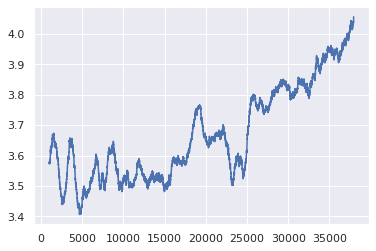

In [40]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean());

Once you've found a good value of `n_neighbors`, submit the model to the grader. Note, "good" is a relative measure here. The reference solution has an $R^2$ score of only 0.02. There is just rather little signal available for modeling.

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {'regressor__n_neighbors': range(1, 80, 2)} 
lat_long_model = GridSearchCV(pipe, param_grid, cv=5, n_jobs=2, verbose=1)

#Doing the following directly, without reshuffling the data, gave crappy results so I am commenting it now 
#lat_long_model.fit(data, star_ratings)

In [42]:
len(df.index)

37938

In [43]:
#Let's try to train the pipeline on shuffled data, since the estimator was performly so poorly 
#(as it would have picked up the monotonic relation in the training set, which would then make it perform
#poorly on the test data that don't have that monotonic relation)

In [44]:
shuffle_rows_idx = np.random.RandomState(seed=101).permutation(len(df.index))

In [45]:
len(shuffle_rows_idx)

37938

In [46]:
shuffle_rows_idx[:10]

array([27749, 37472, 27631,  6094, 13092, 17414, 18069, 28532, 12465,
        4666])

In [47]:
#Apply the same reshuffling to the rows of the 'data' dataframe and the array of labels

In [48]:
data_shuffled = [data[i] for i in shuffle_rows_idx]

In [49]:
data_shuffled[0]

{'business_id': 'yaMFJWd8aDipVDRNZjxaPA',
 'full_address': 'The Balmoral Hotel\n1 Princes St\nOld Town\nEdinburgh EH2 2EQ',
 'hours': {'Monday': {'close': '00:00', 'open': '09:00'},
  'Tuesday': {'close': '00:00', 'open': '09:00'},
  'Friday': {'close': '00:00', 'open': '09:00'},
  'Wednesday': {'close': '00:00', 'open': '09:00'},
  'Thursday': {'close': '00:00', 'open': '09:00'},
  'Sunday': {'close': '00:00', 'open': '09:00'},
  'Saturday': {'close': '00:00', 'open': '09:00'}},
 'open': True,
 'categories': ['Food', 'Coffee & Tea'],
 'city': 'Edinburgh',
 'review_count': 5,
 'name': 'Palm Court',
 'neighborhoods': ['Old Town'],
 'longitude': -3.189613,
 'state': 'EDH',
 'stars': 4.0,
 'latitude': 55.9526566,
 'attributes': {'Wi-Fi': 'paid',
  'Price Range': 4,
  'Alcohol': 'full_bar',
  'Coat Check': True,
  'Happy Hour': False,
  'Outdoor Seating': False,
  'Parking': {'garage': False,
   'street': False,
   'validated': False,
   'lot': False,
   'valet': False},
  'Accepts Credit 

In [50]:
data[27749]

{'business_id': 'yaMFJWd8aDipVDRNZjxaPA',
 'full_address': 'The Balmoral Hotel\n1 Princes St\nOld Town\nEdinburgh EH2 2EQ',
 'hours': {'Monday': {'close': '00:00', 'open': '09:00'},
  'Tuesday': {'close': '00:00', 'open': '09:00'},
  'Friday': {'close': '00:00', 'open': '09:00'},
  'Wednesday': {'close': '00:00', 'open': '09:00'},
  'Thursday': {'close': '00:00', 'open': '09:00'},
  'Sunday': {'close': '00:00', 'open': '09:00'},
  'Saturday': {'close': '00:00', 'open': '09:00'}},
 'open': True,
 'categories': ['Food', 'Coffee & Tea'],
 'city': 'Edinburgh',
 'review_count': 5,
 'name': 'Palm Court',
 'neighborhoods': ['Old Town'],
 'longitude': -3.189613,
 'state': 'EDH',
 'stars': 4.0,
 'latitude': 55.9526566,
 'attributes': {'Wi-Fi': 'paid',
  'Price Range': 4,
  'Alcohol': 'full_bar',
  'Coat Check': True,
  'Happy Hour': False,
  'Outdoor Seating': False,
  'Parking': {'garage': False,
   'street': False,
   'validated': False,
   'lot': False,
   'valet': False},
  'Accepts Credit 

In [51]:
star_ratings_shuffled = star_ratings.copy()

for i, i_shuf in enumerate(shuffle_rows_idx):
    star_ratings_shuffled[i] = star_ratings[i_shuf]

In [52]:
star_ratings_shuffled[0]

4.0

In [53]:
star_ratings[27749]

4.0

In [54]:
star_ratings_shuffled[2]

4.0

In [55]:
star_ratings[27631]

4.0

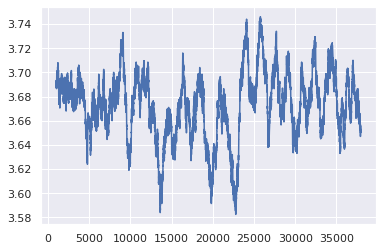

In [56]:
#Shuffle seems to have worked, as confirmed by this plot:
plt.plot(Series.rolling(Series(star_ratings_shuffled), window=1000).mean());


### This is the step that does the fitting, which is time consuming so once I got it working well I saved the model with 'dill' and in the following iterations I just loaded the model from memory


In [57]:
#I will save the model with dill after fitting the model the first time, then I will load it from memory the following times
import dill

#If the model file already exists, I load it:
try:
    with open('lat_long_model.dill', 'rb') as f:
        lat_long_model = dill.load(f)
        print('Loaded pickle file with lat-long model.')
except: #if not, actually perform the fit then save the model for next time:
    
    lat_long_model.fit(data_shuffled, star_ratings_shuffled)
    
    with open('lat_long_model.dill', 'wb') as f:
        dill.dump(lat_long_model, f)
    print('Saved pickle file with lat-long model.')


Loaded pickle file with lat-long model.


In [58]:
lat_long_model.cv_results_

{'mean_fit_time': array([0.31031671, 0.25429988, 0.25634913, 0.30448503, 0.30310516,
        0.30763321, 0.28803892, 0.25615807, 0.28948727, 0.28568292,
        0.27822719, 0.30068026, 0.26416235, 0.26170411, 0.29616361,
        0.28795762, 0.28720355, 0.29786735, 0.29280725, 0.281423  ,
        0.25811419, 0.28116522, 0.2710392 , 0.28757052, 0.27150102,
        0.25751028, 0.27196698, 0.28942199, 0.26810493, 0.2644876 ,
        0.27520437, 0.29240789, 0.22081633, 0.24692397, 0.23243327,
        0.31394067, 0.27959347, 0.25400114, 0.2340641 , 0.22626362]),
 'std_fit_time': array([0.00763525, 0.04732071, 0.0513129 , 0.00750896, 0.03243072,
        0.01948195, 0.04078417, 0.04947574, 0.04119073, 0.03643361,
        0.05114815, 0.03856726, 0.05773887, 0.05347444, 0.03395494,
        0.04051516, 0.04191097, 0.03537533, 0.03453338, 0.04976126,
        0.05986515, 0.04840777, 0.05288595, 0.0448675 , 0.04768975,
        0.04939519, 0.04781436, 0.03921592, 0.05080988, 0.04748003,
        0.060

In [59]:
#The performance (as assessed in the 'mean_test_score' for the max index, which is 2 before the last) of this model
#is in the R^2=0.02 range, so it's comparable to what was mentioned earlier as the goal

In [60]:
lat_long_model.best_params_

{'regressor__n_neighbors': 75}

In [61]:
##Note: without shuffling the training data, and only looking at 1-10 neighbors, the pipeline gave a terrible score on the test set: -0.922 

##With shuffling the data but only looking at 1-10 neighbors, the score was just slightly better: -0.7959

##Only when I increased the number of possible neighbors to 50-80 did I get sufficient performances

#grader.score('ml__lat_long_model', lat_long_model.predict)  # Edit to appropriate name

## Question 4: category_model

While location is important, we could also try seeing how predictive the
venue's category is. Build an estimator that considers only the `'categories'` field of the data.

The categories come as a list of strings, but the scikit-learn's predictors all need numeric input. We ultimately want to create a column in our feature matrix to represent every category. For a given row, only the columns that represent the categories it contains will be filled with a one, otherwise, it will be filled with a zero. The described method is similar to **one-hot encoding**, however, an observation/row can contain more than one "hot", non-zero, column.

To achieve our encoding plan, we need to use scikit-learn's provides [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer). This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it. Missing keys are filled with zeros. However, we need to build a transformer that takes an array of strings and returns an array of dictionaries with keys given by those strings and values of one. For example, it should transform `X_in` into `X_out`.

In [62]:
X_in = pd.Series([['a'], ['b', 'c']])
X_out = pd.Series([{'a': 1}, {'b': 1, 'c': 1}])

print(X_in)
print(X_out)

0       [a]
1    [b, c]
dtype: object
0            {'a': 1}
1    {'b': 1, 'c': 1}
dtype: object


In [63]:
def stringlist_to_dict(stringlist):
    dict = {}
    for string in stringlist:
        dict[string]=1
    return dict

stringlist_to_dict(['a'])

{'a': 1}

In [64]:
stringlist_to_dict(['b','c'])

{'b': 1, 'c': 1}

In [65]:
pd.Series([stringlist_to_dict(string_list) for string_list in X_in])

0            {'a': 1}
1    {'b': 1, 'c': 1}
dtype: object

In [66]:
#df.head()
df['categories'].iloc[:5]

0                          [Doctors, Health & Medical]
1                                        [Restaurants]
2                [American (Traditional), Restaurants]
3    [Food, Ice Cream & Frozen Yogurt, Fast Food, R...
4                               [Chinese, Restaurants]
Name: categories, dtype: object

In [67]:
df['categories'].apply(stringlist_to_dict)

0                    {'Doctors': 1, 'Health & Medical': 1}
1                                       {'Restaurants': 1}
2          {'American (Traditional)': 1, 'Restaurants': 1}
3        {'Food': 1, 'Ice Cream & Frozen Yogurt': 1, 'F...
4                         {'Chinese': 1, 'Restaurants': 1}
                               ...                        
37933    {'Bars': 1, 'Hookah Bars': 1, 'Nightlife': 1, ...
37934    {'Active Life': 1, 'Barre Classes': 1, 'Pilate...
37935                {'Yelp Events': 1, 'Local Flavor': 1}
37936    {'Kosher': 1, 'Italian': 1, 'Pizza': 1, 'Resta...
37937    {'Food': 1, 'Ethnic Food': 1, 'Grocery': 1, 'S...
Name: categories, Length: 37938, dtype: object

In [68]:
X_in.apply(stringlist_to_dict)

0            {'a': 1}
1    {'b': 1, 'c': 1}
dtype: object

In [69]:
class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        return X.apply(stringlist_to_dict)

Now let's test out that our `DictEncoder` works out as expected.

In [70]:
# Check that DictEncoder transforms a series of list of strings into the expected series of dictionaries
grader.check((DictEncoder().fit_transform(X_in) == X_out).all())

True

Now, create a pipeline object of the two step transformation for the categories data. Afterwards, create a `ColumnTransformer` object that will use the aforementioned pipeline object to transform the `'categories'` field.

In [71]:
from sklearn.feature_extraction import DictVectorizer

pipe_categ_encoding = Pipeline([
    ('to dict series',DictEncoder()),
    ('to binary vectors',DictVectorizer())
])

In [72]:
#test the little pipeline first:
pipe_categ_encoding.fit_transform(X_in)

<2x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [73]:
#to visualize how these columns look like:
pipe_categ_encoding.fit_transform(X_in).toarray()


array([[1., 0., 0.],
       [0., 1., 1.]])

In [74]:
#this is not really needed, but I just have it here to visualize the other columns I will not be using
other_columns = [column for column in df.columns if column != 'categories']
other_columns


['business_id',
 'full_address',
 'hours',
 'open',
 'city',
 'review_count',
 'name',
 'neighborhoods',
 'longitude',
 'state',
 'stars',
 'latitude',
 'attributes',
 'type']

In [75]:
#note: here 'categories' should not be bracketed (['categories']) because our transformer expects a series 
#(a one-dimensional object) and would give error if you try to do ['categories'] which returns a 2-dim object

# #Old version:
# categ_tranform = ColumnTransformer([
#     ('categories', pipe_categ_encoding, 'categories'),
#     ('other', 'drop', other_columns)
# ])

#This is a cleaner version to clarify I am dropping all other columns (although 'drop' is the default anyway):
categ_tranform = ColumnTransformer([
    ('categories', pipe_categ_encoding, 'categories'),
], remainder='drop')

In [76]:
#Let's test this in isolation
categ_tranform.fit_transform(df)

<37938x706 sparse matrix of type '<class 'numpy.float64'>'
	with 108205 stored elements in Compressed Sparse Row format>

Finally, create a pipeline object that will
1. Convert our list of dictionaries into a data frame
1. Select the `'categories'` column and encode the data
1. Train a regularized linear model such as `Ridge`

There will be a large number of features, one for each category, so there is a significant danger of overfitting. Use cross validation to choose the best regularization parameter.

In [77]:
from sklearn.linear_model import Ridge

pipe_categ = Pipeline([
    ('to dataframe', ToDataFrame()),
    ('categories selection and encoding', categ_tranform),
    ('regressor',Ridge(alpha=0.001))
])

In [78]:
#Let's see if the pipeline works (i.e. can be fit successfully)
pipe_categ.fit(data_shuffled, star_ratings_shuffled)


Pipeline(steps=[('to dataframe', ToDataFrame()),
                ('categories selection and encoding',
                 ColumnTransformer(transformers=[('categories',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictEncoder()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'categories')])),
                ('regressor', Ridge(alpha=0.001))])

In [79]:
pipe_categ.get_params()

{'memory': None,
 'steps': [('to dataframe', ToDataFrame()),
  ('categories selection and encoding',
   ColumnTransformer(transformers=[('categories',
                                    Pipeline(steps=[('to dict series',
                                                     DictEncoder()),
                                                    ('to binary vectors',
                                                     DictVectorizer())]),
                                    'categories')])),
  ('regressor', Ridge(alpha=0.001))],
 'verbose': False,
 'to dataframe': ToDataFrame(),
 'categories selection and encoding': ColumnTransformer(transformers=[('categories',
                                  Pipeline(steps=[('to dict series',
                                                   DictEncoder()),
                                                  ('to binary vectors',
                                                   DictVectorizer())]),
                                  'categories')]),
 '

In [80]:
#import np
#from sklearn.model_selection import GridSearchCV

param_grid = {'regressor__alpha': np.logspace(-5,5,10)} 
category_model = GridSearchCV(pipe_categ, param_grid, cv=5, n_jobs=2, verbose=1)


### This is the step that does the fitting, which is time consuming so once I got it working well I saved the model with 'dill' and in the following iterations I just loaded the model from memory

In [81]:
#I will save the model with dill after fitting the model the first time, then I will load it from memory the following times
import dill

#If the model file already exists, I load it:
try:
    with open('category_model.dill', 'rb') as f:
        category_model = dill.load(f)
        print('Loaded pickle file with category model.')
except: #if not, actually perform the fit then save the model for next time:
    
    category_model.fit(data_shuffled, star_ratings_shuffled)
    
    with open('category_model.dill', 'wb') as f:
        dill.dump(category_model, f)
    print('Saved pickle file with category model.')

Loaded pickle file with category model.


In [82]:
category_model.best_params_

{'regressor__alpha': 3.593813663804626}

In [83]:
#Let's see how was the performance of this model on the different folds
category_model.cv_results_

{'mean_fit_time': array([0.48531518, 0.51297684, 0.50246615, 0.54530277, 0.52666807,
        0.47363896, 0.40665159, 0.38662996, 0.43180146, 0.309513  ]),
 'std_fit_time': array([0.08905216, 0.08792356, 0.08278589, 0.08225683, 0.03501576,
        0.06665968, 0.0740036 , 0.07943187, 0.07294974, 0.015022  ]),
 'mean_score_time': array([0.07652116, 0.08809199, 0.08513875, 0.08997145, 0.08667512,
        0.09187498, 0.08175406, 0.08113384, 0.09276829, 0.06228304]),
 'std_score_time': array([0.01854407, 0.01870421, 0.01923949, 0.01607151, 0.01710597,
        0.01655862, 0.02161346, 0.01652238, 0.01797501, 0.00216464]),
 'param_regressor__alpha': masked_array(data=[1e-05, 0.0001291549665014884, 0.0016681005372000592,
                    0.021544346900318846, 0.2782559402207126,
                    3.593813663804626, 46.41588833612782,
                    599.4842503189421, 7742.636826811277, 100000.0],
              mask=[False, False, False, False, False, False, False, False,
              

In [84]:
#It's around 0.16-0.17 on the test folds. The best score (the mean of scores on test folds for the best choice of parameter)
#can be looked at with:
category_model.best_score_

0.17526931271462565

In [85]:
#grader.score('ml__category_model', category_model.predict)  # Edit to appropriate name

**Extension:** Some categories (e.g., Restaurants) are not very specific. Others (Japanese sushi) are much more so.  One way to deal with this is with an measure call term frequency-inverse document frequency (tf-idf). Add in a [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) between the `DictVectorizer` and the linear model, and see if that improves performance.

In [86]:
#Define category_model_improved as described above

## Question 5: attribute_model

There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```python
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them in the same manner as our categories data using the `DictVectorizer`. Before we do so, we need to flatten the dictionary to a single level:
```python
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```
Build a custom transformer that flattens the dictionary for the `'attributes'` field. Similar to what was done before, create a model that properly encodes the attribute data and learns to predict the ratings.

You may find it difficult to find a single regressor that does well enough. A common solution is to use a linear model to fit the linear part of some data, and use a non-linear model to fit the residual that the linear model can't fit. Build a custom predictor that takes as an argument two other predictors. It should use the first to fit the raw data and the second to fit the residuals of the first.

In [87]:
df.iloc[:5]['attributes']

0                        {'By Appointment Only': True}
1    {'Take-out': True, 'Good For': {'dessert': Fal...
2    {'Take-out': True, 'Good For': {'dessert': Fal...
3    {'Take-out': True, 'Wi-Fi': 'free', 'Takes Res...
4    {'Take-out': True, 'Has TV': False, 'Outdoor S...
Name: attributes, dtype: object

In [88]:
df.iloc[1]['attributes']

{'Take-out': True,
 'Good For': {'dessert': False,
  'latenight': False,
  'lunch': True,
  'dinner': False,
  'breakfast': False,
  'brunch': False},
 'Caters': False,
 'Noise Level': 'average',
 'Takes Reservations': False,
 'Delivery': False,
 'Ambience': {'romantic': False,
  'intimate': False,
  'touristy': False,
  'hipster': False,
  'divey': False,
  'classy': False,
  'trendy': False,
  'upscale': False,
  'casual': False},
 'Parking': {'garage': False,
  'street': False,
  'validated': False,
  'lot': True,
  'valet': False},
 'Has TV': True,
 'Outdoor Seating': False,
 'Attire': 'casual',
 'Alcohol': 'none',
 'Waiter Service': True,
 'Accepts Credit Cards': True,
 'Good for Kids': True,
 'Good For Groups': True,
 'Price Range': 1}

In [89]:
df.iloc[1]['attributes']['Good For'].items()

dict_items([('dessert', False), ('latenight', False), ('lunch', True), ('dinner', False), ('breakfast', False), ('brunch', False)])

In [90]:
def flatten_dict(nested_dict):
    flat_dict={}
    for key,val in nested_dict.items():
        if isinstance(val,bool):
            flat_dict[key] = int(val)
        else: #in this case the value of the first dict is a dict itself or is a single, non-boolean, value (string, number, etc.) 
            #print(val)
            try: 
                for inner_key, inner_val in nested_dict[key].items():
                    extend_key = '_'.join([key,inner_key])
                    flat_dict[extend_key] = int(inner_val)

            except: #case of a single value but not boolean
                extend_key = '_'.join([key,str(val)])
                flat_dict[extend_key] = 1
    return flat_dict
        

In [91]:
flatten_dict(df.iloc[1]['attributes'])

{'Take-out': 1,
 'Good For_dessert': 0,
 'Good For_latenight': 0,
 'Good For_lunch': 1,
 'Good For_dinner': 0,
 'Good For_breakfast': 0,
 'Good For_brunch': 0,
 'Caters': 0,
 'Noise Level_average': 1,
 'Takes Reservations': 0,
 'Delivery': 0,
 'Ambience_romantic': 0,
 'Ambience_intimate': 0,
 'Ambience_touristy': 0,
 'Ambience_hipster': 0,
 'Ambience_divey': 0,
 'Ambience_classy': 0,
 'Ambience_trendy': 0,
 'Ambience_upscale': 0,
 'Ambience_casual': 0,
 'Parking_garage': 0,
 'Parking_street': 0,
 'Parking_validated': 0,
 'Parking_lot': 1,
 'Parking_valet': 0,
 'Has TV': 1,
 'Outdoor Seating': 0,
 'Attire_casual': 1,
 'Alcohol_none': 1,
 'Waiter Service': 1,
 'Accepts Credit Cards': 1,
 'Good for Kids': 1,
 'Good For Groups': 1,
 'Price Range_1': 1}

In [92]:
class DictFlattener(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas column made of nested dictionaries. Return a pandas series of flattened dictionaries
        return X.apply(flatten_dict)

In [93]:
test_flattener = DictFlattener()
test_flattened_attributes = test_flattener.fit_transform(df['attributes'])
test_flattened_attributes

0                               {'By Appointment Only': 1}
1        {'Take-out': 1, 'Good For_dessert': 0, 'Good F...
2        {'Take-out': 1, 'Good For_dessert': 0, 'Good F...
3        {'Take-out': 1, 'Wi-Fi_free': 1, 'Takes Reserv...
4        {'Take-out': 1, 'Has TV': 0, 'Outdoor Seating'...
                               ...                        
37933    {'Alcohol_none': 1, 'Good For Dancing': 1, 'No...
37934                                                   {}
37935                                 {'Good for Kids': 0}
37936    {'Take-out': 1, 'Wi-Fi_no': 1, 'Good For_desse...
37937    {'Parking_garage': 0, 'Parking_street': 0, 'Pa...
Name: attributes, Length: 37938, dtype: object

In [94]:
from sklearn.feature_extraction import DictVectorizer

pipe_attrib_encoding = Pipeline([
    ('to dict series',DictFlattener()),
    ('to binary vectors',DictVectorizer())
])

In [95]:
attrib_tranform = ColumnTransformer([
    ('attributes', pipe_attrib_encoding, 'attributes'),
], remainder='drop')

In [96]:
#Let's see how the attribute columns look like at this point
pipe_attrib_before_reg = Pipeline([
    ('to dataframe', ToDataFrame()),
    ('attributes selection and encoding', attrib_tranform),
])

In [97]:
test_vectorizer = DictVectorizer()
test_vectorized_attributes = test_vectorizer.fit_transform(test_flattened_attributes)
test_vectorized_attributes

<37938x96 sparse matrix of type '<class 'numpy.float64'>'
	with 531447 stored elements in Compressed Sparse Row format>

In [98]:
test_vectorizer.feature_names_

['Accepts Credit Cards',
 'Accepts Insurance',
 'Ages Allowed_18plus',
 'Ages Allowed_21plus',
 'Ages Allowed_allages',
 'Alcohol_beer_and_wine',
 'Alcohol_full_bar',
 'Alcohol_none',
 'Ambience_casual',
 'Ambience_classy',
 'Ambience_divey',
 'Ambience_hipster',
 'Ambience_intimate',
 'Ambience_romantic',
 'Ambience_touristy',
 'Ambience_trendy',
 'Ambience_upscale',
 'Attire_casual',
 'Attire_dressy',
 'Attire_formal',
 'BYOB',
 'BYOB/Corkage_no',
 'BYOB/Corkage_yes_corkage',
 'BYOB/Corkage_yes_free',
 'By Appointment Only',
 'Caters',
 'Coat Check',
 'Corkage',
 'Delivery',
 'Dietary Restrictions_dairy-free',
 'Dietary Restrictions_gluten-free',
 'Dietary Restrictions_halal',
 'Dietary Restrictions_kosher',
 'Dietary Restrictions_soy-free',
 'Dietary Restrictions_vegan',
 'Dietary Restrictions_vegetarian',
 'Dogs Allowed',
 'Drive-Thru',
 'Good For Dancing',
 'Good For Groups',
 'Good For Kids',
 'Good For_breakfast',
 'Good For_brunch',
 'Good For_dessert',
 'Good For_dinner',
 'Go

In [99]:
attribute_columns = pipe_attrib_before_reg.fit_transform(data_shuffled)

In [100]:
attribute_columns

<37938x96 sparse matrix of type '<class 'numpy.float64'>'
	with 531447 stored elements in Compressed Sparse Row format>

In [101]:
attribute_columns_df = pd.DataFrame(attribute_columns.todense(),columns=test_vectorizer.feature_names_)
attribute_columns_df

,Accepts Credit Cards,Accepts Insurance,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,Alcohol_beer_and_wine,Alcohol_full_bar,Alcohol_none,Ambience_casual,Ambience_classy,...,Smoking_no,Smoking_outdoor,Smoking_yes,Take-out,Takes Reservations,Waiter Service,Wheelchair Accessible,Wi-Fi_free,Wi-Fi_no,Wi-Fi_paid
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37935,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
37936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
#LEt's check if the data is correct
df.iloc[shuffle_rows_idx[0]]['attributes']

{'Wi-Fi': 'paid',
 'Price Range': 4,
 'Alcohol': 'full_bar',
 'Coat Check': True,
 'Happy Hour': False,
 'Outdoor Seating': False,
 'Parking': {'garage': False,
  'street': False,
  'validated': False,
  'lot': False,
  'valet': False},
 'Accepts Credit Cards': True,
 'Wheelchair Accessible': True}

In [103]:
from sklearn.linear_model import Ridge

pipe_attrib = Pipeline([
    ('to dataframe', ToDataFrame()),
    ('attributes selection and encoding', attrib_tranform),
    ('regressor',Ridge(alpha=0.001))
])

In [104]:
pipe_attrib

Pipeline(steps=[('to dataframe', ToDataFrame()),
                ('attributes selection and encoding',
                 ColumnTransformer(transformers=[('attributes',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictFlattener()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'attributes')])),
                ('regressor', Ridge(alpha=0.001))])

In [105]:
#Because all these attribute features are 0 or 1, there really is no need to do any scaling, etc.

In [106]:
#Let's do a cross validation as before and see how well does this model perform:
param_grid = {'regressor__alpha': np.logspace(-5,5,10)} 
attribute_model_linear = GridSearchCV(pipe_attrib, param_grid, cv=5, n_jobs=2, verbose=1)

In [107]:
#I will save the model with dill after fitting the model the first time, then I will load it from memory the following times
import dill

#If the model file already exists, I load it:
try:
    with open('attribute_model_linear.dill', 'rb') as f:
        attribute_model_linear = dill.load(f)
        print('Loaded pickle file with attribute model PURELY LINEAR.')
except: #if not, actually perform the fit then save the model for next time:
    
    attribute_model_linear.fit(data_shuffled, star_ratings_shuffled)
    
    with open('attribute_model_linear.dill', 'wb') as f:
        dill.dump(attribute_model_linear, f)
    print('Saved pickle file with attribute model PURELY LINEAR.')

Loaded pickle file with attribute model PURELY LINEAR.


In [108]:
#Let's check the optimized 'alpha' to make sure I am not at the edge of the search space
attribute_model_linear.best_params_

{'regressor__alpha': 3.593813663804626}

In [109]:
#and check for the performance of this model
attribute_model_linear.cv_results_

{'mean_fit_time': array([0.91598926, 0.91220169, 1.01593409, 0.89907689, 0.88850031,
        0.89570875, 0.89332337, 0.79154811, 0.84176702, 0.81857204]),
 'std_fit_time': array([0.1403404 , 0.21749226, 0.14260783, 0.18129673, 0.14922617,
        0.13580751, 0.16494217, 0.09178925, 0.17068837, 0.16452408]),
 'mean_score_time': array([0.17948961, 0.14176545, 0.19908466, 0.17052131, 0.20418367,
        0.20438395, 0.17782383, 0.21418939, 0.15639744, 0.15324898]),
 'std_score_time': array([0.04748012, 0.00251481, 0.04235872, 0.03393325, 0.04377204,
        0.05108225, 0.04253237, 0.03912811, 0.00689144, 0.01274317]),
 'param_regressor__alpha': masked_array(data=[1e-05, 0.0001291549665014884, 0.0016681005372000592,
                    0.021544346900318846, 0.2782559402207126,
                    3.593813663804626, 46.41588833612782,
                    599.4842503189421, 7742.636826811277, 100000.0],
              mask=[False, False, False, False, False, False, False, False,
              

In [110]:
attribute_model_linear.best_score_

0.06989510915561545

In [111]:
## Let's check how badly does the purely linear model on the grader test set
#grader.score('ml__attribute_model', attribute_model_linear.predict)  

In [112]:
#Not that bad: around 0.75, but of course it's insufficient to pass the 0.9 threshold

In [113]:
#I now need to add a nonliner predictor at the end. First let's assess how the residuals from the linear predictor 
#look like for a random subset of the training data, and see if we can infer anything on 
#how to design the nonlinear model

In [114]:
#recall that data_shuffled (like data) is a list of dictionaries
data_shuffled[0]

{'business_id': 'yaMFJWd8aDipVDRNZjxaPA',
 'full_address': 'The Balmoral Hotel\n1 Princes St\nOld Town\nEdinburgh EH2 2EQ',
 'hours': {'Monday': {'close': '00:00', 'open': '09:00'},
  'Tuesday': {'close': '00:00', 'open': '09:00'},
  'Friday': {'close': '00:00', 'open': '09:00'},
  'Wednesday': {'close': '00:00', 'open': '09:00'},
  'Thursday': {'close': '00:00', 'open': '09:00'},
  'Sunday': {'close': '00:00', 'open': '09:00'},
  'Saturday': {'close': '00:00', 'open': '09:00'}},
 'open': True,
 'categories': ['Food', 'Coffee & Tea'],
 'city': 'Edinburgh',
 'review_count': 5,
 'name': 'Palm Court',
 'neighborhoods': ['Old Town'],
 'longitude': -3.189613,
 'state': 'EDH',
 'stars': 4.0,
 'latitude': 55.9526566,
 'attributes': {'Wi-Fi': 'paid',
  'Price Range': 4,
  'Alcohol': 'full_bar',
  'Coat Check': True,
  'Happy Hour': False,
  'Outdoor Seating': False,
  'Parking': {'garage': False,
   'street': False,
   'validated': False,
   'lot': False,
   'valet': False},
  'Accepts Credit 

In [115]:
len(data_shuffled)

37938

In [116]:
len(star_ratings_shuffled)

37938

In [117]:
#Let's pick every 8-th element (roughly 5000 points) as a temporary test set to look at
data_shuffled_test = data_shuffled[::8]
star_ratings_shuffled_test = star_ratings_shuffled[::8]

In [118]:
star_ratings_predicted_test = attribute_model_linear.predict(data_shuffled_test)

In [119]:
attribute_model_linear.score(data_shuffled_test,np.array(star_ratings_shuffled_test))

0.06345590812350554

Text(0, 0.5, 'predicted with linear model')

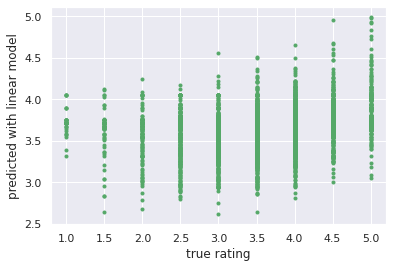

In [120]:
plt.plot(star_ratings_shuffled_test,star_ratings_predicted_test,'g.')
plt.xlabel('true rating')
plt.ylabel('predicted with linear model')

### Here starts the analysis of the analysis and fitting of the residuals after the linear modeling

In [121]:
res_linear_model_test = star_ratings_shuffled_test - star_ratings_predicted_test 

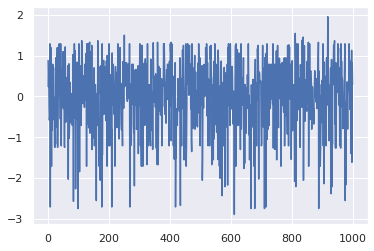

In [122]:
plt.plot(res_linear_model_test[:1000])

Text(0, 0.5, 'linear model error')

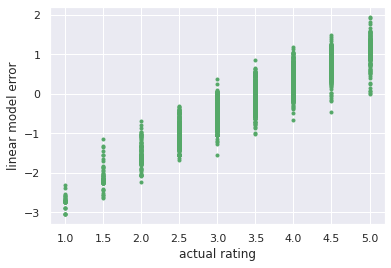

In [123]:
#Let's see where we make the most errors, by plotting residuals as a function of star rating
plt.plot(star_ratings_shuffled_test,res_linear_model_test,'g.')
plt.xlabel('actual rating')
plt.ylabel('linear model error')

/opt/conda/envs/data3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

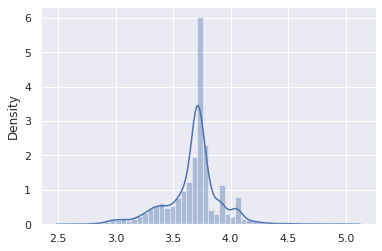

In [124]:
#It looks we are mostly predicting a star rating of 3-4 no-matter the actual rating... let's check if that's the case
sns.distplot(star_ratings_predicted_test)

<AxesSubplot:ylabel='Count'>

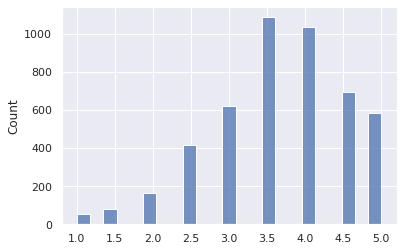

In [125]:
#Whereas the actual star ratings are more spread-out
sns.histplot(star_ratings_shuffled_test)

### Start with a polynomial model (order 2 or 3)

In [126]:
#Since we have errors in both directions (negative and positive), fitting a third order polynomial 
#or something like that to the residual error should work

In [127]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

second_order_residual_pipe = Pipeline([('to dataframe', ToDataFrame()),
    ('attributes selection and encoding', attrib_tranform),                                                                    
    ('polynomial_trans', PolynomialFeatures(degree=2,include_bias=False)),
    ('ridge', Ridge(alpha=1)) 
    ])

# I also tried 3rd order but gave worse results (probably it was overfitting, and I could only fit it on some of the data
# as it was taking too long to train)
#
# third_order_residual_pipe = Pipeline([('to dataframe', ToDataFrame()),
#     ('attributes selection and encoding', attrib_tranform),                                                                    
#     ('polynomial_trans', PolynomialFeatures(3,include_bias=False)),
#     ('ridge', Ridge(alpha=100)) #('ridge', Ridge(alpha=1)) #('ridge', Ridge(alpha=0.001))
#     ])


#I also tried order 4 but it crashed when fitting because it ran out of memory

In [128]:
np.array(res_linear_model_test).shape

(4743,)

In [129]:
#let's first see how the model does on just the 'test' subset of residuals

second_order_residual_pipe.fit(data_shuffled_test,np.array(res_linear_model_test))

#third_order_residual_pipe.fit(data_shuffled_test,np.array(res_linear_model_test))

Pipeline(steps=[('to dataframe', ToDataFrame()),
                ('attributes selection and encoding',
                 ColumnTransformer(transformers=[('attributes',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictFlattener()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'attributes')])),
                ('polynomial_trans', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=1))])

In [130]:
second_order_residual_pipe_pred = second_order_residual_pipe.predict(data_shuffled_test)
second_order_residual_pipe_pred

#third_order_residual_pipe_pred = third_order_residual_pipe.predict(data_shuffled_test)
#third_order_residual_pipe_pred

array([ 0.79011618,  0.09837049, -0.00653432, ..., -0.02523548,
        0.53139525, -0.02523548])

In [131]:
second_order_residual_pipe_pred.min()
#third_order_residual_pipe_pred.min()

-2.145824847150685

In [132]:
second_order_residual_pipe_pred.max()
#third_order_residual_pipe_pred.max()

1.4604716118543917

Text(0, 0.5, 'predicted with nonlinear residual model')

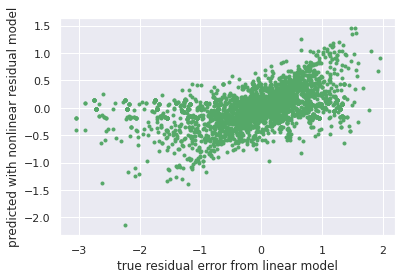

In [133]:
plt.plot(res_linear_model_test,second_order_residual_pipe_pred,'g.')
plt.xlabel('true residual error from linear model')
plt.ylabel('predicted with 2nd order nonlinear residual model')

#plt.plot(res_linear_model_test,third_order_residual_pipe_pred,'g.')
#plt.xlabel('true residual error from linear model')
#plt.ylabel('predicted with 3rd order nonlinear residual model')

In [134]:
#Although just on training data, the nonlinear predictor seems to be performing ok at least on some of the points. 
#Let's quantify:
second_order_residual_pipe.score(data_shuffled_test,res_linear_model_test)
#third_order_residual_pipe.score(data_shuffled_test,res_linear_model_test)

0.14250370238212984

In [135]:
second_order_residual_pipe.get_params()
#third_order_residual_pipe.get_params()

{'memory': None,
 'steps': [('to dataframe', ToDataFrame()),
  ('attributes selection and encoding',
   ColumnTransformer(transformers=[('attributes',
                                    Pipeline(steps=[('to dict series',
                                                     DictFlattener()),
                                                    ('to binary vectors',
                                                     DictVectorizer())]),
                                    'attributes')])),
  ('polynomial_trans', PolynomialFeatures(include_bias=False)),
  ('ridge', Ridge(alpha=1))],
 'verbose': False,
 'to dataframe': ToDataFrame(),
 'attributes selection and encoding': ColumnTransformer(transformers=[('attributes',
                                  Pipeline(steps=[('to dict series',
                                                   DictFlattener()),
                                                  ('to binary vectors',
                                                   DictVectorizer

In [136]:
#What are the coefficients of the final ridge predictor?
second_order_residual_pipe[-1].coef_
#third_order_residual_pipe[-1].coef_

array([ 0.08651004,  0.08129538,  0.01358685, ..., -0.32824648,
        0.        , -0.05797433])

In [137]:
#Let's try with cross validation to check for robustness of this result, and extend to the whole set of residuals
param_grid = {'ridge__alpha': np.logspace(-2,4,10)} 
second_order_residual_only_model = GridSearchCV(second_order_residual_pipe, param_grid, cv=5, n_jobs=2, verbose=15)

#param_grid = {'ridge__alpha': np.logspace(-2,4,10)} 
#third_order_residual_only_model = GridSearchCV(third_order_residual_pipe, param_grid, cv=5, n_jobs=2, verbose=15)

# #I first tried the following, but the very small values of alpha took a long time to converge, and the best value ended up 
# #being much higher - around 100-1000, so I focused on that region more afterwards
# param_grid = {'ridge__alpha': np.logspace(-5,5,10)} 
# third_order_residual_only_model = GridSearchCV(third_order_residual_pipe, param_grid, cv=5, n_jobs=2, verbose=15)

In [138]:
second_order_residual_only_model.fit(data_shuffled,star_ratings_shuffled-np.array(attribute_model_linear.predict(data_shuffled)))
    
   

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   44.8s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   46.0s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:  4.0min
[Parallel(

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('to dataframe', ToDataFrame()),
                                       ('attributes selection and encoding',
                                        ColumnTransformer(transformers=[('attributes',
                                                                         Pipeline(steps=[('to '
                                                                                          'dict '
                                                                                          'series',
                                                                                          DictFlattener()),
                                                                                         ('to '
                                                                                          'binary '
                                                                                          'vectors',
                                                                                          DictVectorizer())]),
                                                                         'attributes')])),
                                       ('polynomial_trans',
                                        PolynomialFeatures(include_bias=False)),
                                       ('ridge', Ridge(alpha=1))]),
             n_jobs=2,
             param_grid={'ridge__alpha': array([1.00000000e-02, 4.64158883e-02, 2.15443469e-01, 1.00000000e+00,
       4.64158883e+00, 2.15443469e+01, 1.00000000e+02, 4.64158883e+02,
       2.15443469e+03, 1.00000000e+04])},
             verbose=15)

In [139]:
#I will save the model with dill after fitting the model the first time, then I will load it from memory the following times

import dill

#If the model file already exists, I load it:
try:
    with open('attribute_model_2ndorder_residuals_only.dill', 'rb') as f:
        second_order_residual_only_model = dill.load(f)
        print('Loaded pickle file with attribute model 2nd degree polynomial for RESIDUALS ONLY.')
except: #if not, actually perform the fit then save the model for next time:
    
    second_order_residual_only_model.fit(data_shuffled,star_ratings_shuffled-np.array(attribute_model_linear.predict(data_shuffled)))
    
    with open('attribute_model_2ndorder_residuals_only.dill', 'wb') as f:
        dill.dump(second_order_residual_only_model, f)
    print('Saved pickle file with attribute model 2nd degree polynomial for RESIDUALS ONLY.')

    
#For the 3rd order, I had to limit myself to fitting on my smaller test set:
#third_order_residual_only_model.fit(data_shuffled_test,res_linear_model_test)
# #For some reason, this never converged with the full dataset when I used the 3rd order polynomial... probably too many points perhaps
#third_order_residual_only_model.fit(data_shuffled,star_ratings_shuffled-np.array(attribute_model_linear.predict(data_shuffled)))
          
# #If the model file already exists, I load it:
# try:
#     with open('attribute_model_3rdorder_residuals_only.dill', 'rb') as f:
#         third_order_residual_only_model = dill.load(f)
#         print('Loaded pickle file with attribute model 3rd degree polynomial for RESIDUALS ONLY.')
# except: #if not, actually perform the fit then save the model for next time:
    
#     third_order_residual_only_model.fit(data_shuffled_test,star_ratings_shuffled_test-np.array(attribute_model_linear.predict(data_shuffled_test)))
    
#     with open('attribute_model_3rdorder_residuals_only.dill', 'wb') as f:
#         dill.dump(third_order_residual_only_model, f)
#     print('Saved pickle file with attribute model 3rd degree polynomial for RESIDUALS ONLY.')

In [142]:
second_order_residual_only_model.best_params_
#third_order_residual_only_model.best_params_

{'ridge__alpha': 100.0}

In [143]:
second_order_residual_only_model.best_score_
#third_order_residual_only_model.best_score_

0.020390562206198594

In [144]:
#So I expect this predictor to perform ok when combined with the linear one in the fashion suggested in the problem

In [145]:
#Build a custom predictor that takes as an argument two other predictors. 
#It should use the first to fit the raw data and the second to fit the residuals of the first.

In [146]:
class CascadePredictor(BaseEstimator, RegressorMixin):
  def __init__(self, Predictor1, Predictor2):
    # initialization code
    self.predictor1 = Predictor1
    self.predictor2 = Predictor2

  def fit(self, X, y):
    # fit the model:
    self.predictor1.fit(X, y)
    res = y - np.array(self.predictor1.predict(X))
    self.predictor2.fit(X, res)
    return self

  def predict(self, X):
    # make predictions 
    return np.array(self.predictor1.predict(X)) + np.array(self.predictor2.predict(X))

  #def score(self, X, y):
  #  # custom score implementation
  #  # this is optional, if not defined default is R^2
  #  return ...

In [147]:
attribute_pipe = CascadePredictor(Predictor1=pipe_attrib,Predictor2=second_order_residual_pipe)
#attribute_pipe = CascadePredictor(Predictor1=pipe_attrib,Predictor2=third_order_residual_pipe)

In [148]:
attribute_pipe.predictor1.get_params()

{'memory': None,
 'steps': [('to dataframe', ToDataFrame()),
  ('attributes selection and encoding',
   ColumnTransformer(transformers=[('attributes',
                                    Pipeline(steps=[('to dict series',
                                                     DictFlattener()),
                                                    ('to binary vectors',
                                                     DictVectorizer())]),
                                    'attributes')])),
  ('regressor', Ridge(alpha=0.001))],
 'verbose': False,
 'to dataframe': ToDataFrame(),
 'attributes selection and encoding': ColumnTransformer(transformers=[('attributes',
                                  Pipeline(steps=[('to dict series',
                                                   DictFlattener()),
                                                  ('to binary vectors',
                                                   DictVectorizer())]),
                                  'attributes')])

In [149]:
params_dict1 = {'regressor__alpha':3.6}
attribute_pipe.predictor1.set_params(**params_dict1) #based on what found for the linear model alone

Pipeline(steps=[('to dataframe', ToDataFrame()),
                ('attributes selection and encoding',
                 ColumnTransformer(transformers=[('attributes',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictFlattener()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'attributes')])),
                ('regressor', Ridge(alpha=3.6))])

In [150]:
#for 2nd order version:
params_dict2 = {'ridge__alpha':100} 
attribute_pipe.predictor2.set_params(**params_dict2)
#for 3rd order version:
#params_dict2 = {'ridge__alpha':1000} #{'ridge__alpha':0.001} #{'ridge__alpha':1e-05}

Pipeline(steps=[('to dataframe', ToDataFrame()),
                ('attributes selection and encoding',
                 ColumnTransformer(transformers=[('attributes',
                                                  Pipeline(steps=[('to dict '
                                                                   'series',
                                                                   DictFlattener()),
                                                                  ('to binary '
                                                                   'vectors',
                                                                   DictVectorizer())]),
                                                  'attributes')])),
                ('polynomial_trans', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=100))])

In [ ]:
#I will save the model with dill after fitting the model the first time, then I will load it from memory the following times

import dill

#If the model file already exists, I load it:
try:
    with open('attribute_model_linear_plus_2nddorder.dill', 'rb') as f:
        attribute_pipe = dill.load(f)
        print('Loaded pickle file with attribute model linear + 2nd degree polynomial on the residuals.')
except: #if not, actually perform the fit then save the model for next time:
    
    attribute_pipe.fit(data_shuffled,star_ratings_shuffled-np.array(attribute_model_linear.predict(data_shuffled)))
    
    with open('attribute_model_linear_plus_2nddorder.dill', 'wb') as f:
        dill.dump(attribute_pipe, f)
    print('Saved pickle file with attribute model linear + 2nd degree polynomial on the residuals.')

# # For the 3rd order polynomial this did not work:
# #attribute_pipe.fit(data_shuffled, star_ratings_shuffled)
# # and I instead had to use:
# #attribute_pipe.fit(data_shuffled_test,star_ratings_shuffled_test)
    
# try:
#     with open('attribute_model_linear_plus_3rddorder.dill', 'rb') as f:
#         attribute_pipe = dill.load(f)
#         print('Loaded pickle file with attribute model linear + 3rd degree polynomial on the residuals.')
# except: #if not, actually perform the fit then save the model for next time:
    
#     attribute_pipe.fit(data_shuffled_test,star_ratings_shuffled_test-np.array(attribute_model_linear.predict(data_shuffled_test)))
    
#     with open('attribute_model_linear_plus_3rddorder.dill', 'wb') as f:
#         dill.dump(attribute_pipe, f)
#     print('Saved pickle file with attribute model linear + 3rd degree polynomial on the residuals.')    

In [ ]:
attribute_pipe.predict(data_shuffled_test)

In [ ]:
attribute_pipe.score(data_shuffled_test,star_ratings_shuffled_test)

In [ ]:
attribute_pipe.predict(data_shuffled)

In [ ]:
attribute_pipe.score(data_shuffled,star_ratings_shuffled)

In [ ]:
#Let's check the grader on this:
#grader.score('ml__attribute_model', attribute_pipe.predict)

In [158]:
#What if I let GridSearch look for the best combination of regressor__alpha and ridge__alpha?

In [159]:
attribute_pipe.get_params().keys()

/opt/conda/envs/data3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


dict_keys(['Predictor1', 'Predictor2'])

In [160]:
#This doesn't seem to work:
#Let's try with cross validation to check for robustness of this result, and extend to the whole set of residuals
param_grid = {'Predictor1.regressor__alpha':np.logspace(-5,5,10),'Predictor2.ridge__alpha': np.logspace(-2,4,10)} 
attribute_cascade_model = GridSearchCV(attribute_pipe, param_grid, cv=5, n_jobs=2, verbose=1)


In [161]:
attribute_cascade_model.fit(data_shuffled, star_ratings_shuffled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Invalid parameter Predictor1.regressor for estimator CascadePredictor(Predictor1=None, Predictor2=None). Check the list of available parameters with `estimator.get_params().keys()`.

In [164]:
#This doesn't seem to work either:
pipe_attrib_list = [pipe_attrib.set_params(**{'regressor__alpha':n}) for n in np.logspace(-5,5,10)]

third_order_residual_pipe_list = [third_order_residual_pipe.set_params(**{'ridge__alpha':n}) for n in np.logspace(-2,4,10)]

param_grid = {'Predictor1':pipe_attrib_list,'Predictor2': third_order_residual_pipe_list} 
attribute_cascade_model = GridSearchCV(attribute_pipe, param_grid, cv=5, n_jobs=1, verbose=1)

In [165]:
attribute_cascade_model.fit(data_shuffled, star_ratings_shuffled)

/opt/conda/envs/data3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/envs/data3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/data3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-146-7904274ec013>", line 9, in fit
    self.predictor1.fit(X, y)
AttributeError: 'NoneType' object has no attribute 'fit'

  warnings.warn("Estimator fit fail

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   12.5s finished


RuntimeError: Cannot clone object CascadePredictor(Predictor1=Pipeline(steps=[('to dataframe', ToDataFrame()),
                                            ('attributes selection and '
                                             'encoding',
                                             ColumnTransformer(transformers=[('attributes',
                                                                              Pipeline(steps=[('to '
                                                                                               'dict '
                                                                                               'series',
                                                                                               DictFlattener()),
                                                                                              ('to '
                                                                                               'binary '
                                                                                               'vectors',
                                                                                               DictVectorizer())]),
                                                                              'attributes')])),
                                            ('regressor',
                                             Ridge(alpha=100000.0))]),
                 Predictor2=Pipeline(steps=[('to dataframe', ToDataFrame()),
                                            ('attributes selection and '
                                             'encoding',
                                             ColumnTransformer(transformers=[('attributes',
                                                                              Pipeline(steps=[('to '
                                                                                               'dict '
                                                                                               'series',
                                                                                               DictFlattener()),
                                                                                              ('to '
                                                                                               'binary '
                                                                                               'vectors',
                                                                                               DictVectorizer())]),
                                                                              'attributes')])),
                                            ('polynomial_trans',
                                             PolynomialFeatures(include_bias=False)),
                                            ('ridge', Ridge(alpha=10000.0))])), as the constructor either does not set or modifies parameter Predictor1

In [ ]:
#grader.score('ml__attribute_model', attribute_cascade_model.predict) 

## Question 6: full_model

So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to a predictor, we will have to turn them into transformers; a predictor can only be in the final step of a pipeline. Build a custom `ModelTransformer` class that takes a predictor as an argument. When `fit` is called, the predictor should be fit. When `transform` is called, the predictor's `predict` method should be called, and its results returned as the transformation.

Note that the output of the `transform` method should be a 2-D array with a single column in order for it to work well with the scikit-learn pipeline. If you're using NumPy arrays, you can use `.reshape(-1, 1)` to create a column vector. If you are just using Python lists, you will want a list of lists of single elements.

In [166]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        self.predictor = model
            
    def fit(self, X, y):
        # Fit the stored predictor.
        self.predictor.fit(X, y)
        return self
    
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # Be sure to return a 2-D array.
        return np.array(self.predictor.predict(X)).reshape(-1,1)
    

Let's now test it out on our `city_model`.

In [167]:
city_trans = ModelTransformer(city_model)
city_trans.fit(data, star_ratings)
X_t = city_trans.transform(data[:5])

# Check that the transformation output is a 2-D array with one column
grader.check(np.array(X_t).shape[-1] == 1)

True

In [168]:
#sanity check: the results should also look like those obtained earlier, which were:
#array([3.67029039, 3.75      , 3.75      , 3.75      , 3.75      ])
#That's what the next line tests

In [169]:
y_pred = np.array(city_model.predict(data[:5]))

# Check that the transformation output is the same as the model's predictions
grader.check((y_pred.reshape(-1, 1) == X_t).all())

True

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [170]:
#Latitude-Longitude Model

#Recall that:
#lat_long_model = GridSearchCV(pipe, param_grid, cv=5, n_jobs=2, verbose=1)
#so it may take a bit to compute
lat_long_trans = ModelTransformer(lat_long_model)

# #For debug:
#lat_long_trans.fit(data, star_ratings)
#Y_t = lat_long_trans.transform(data[:5])
#print(Y_t)
##compare with the results of actually running that model
#print(lat_long_model.predict(data[:5]))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   46.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  3.2min finished


In [174]:
#Category Model:

#Recall that:
#param_grid = {'regressor__alpha': np.logspace(-5,5,10)} 
#category_model = GridSearchCV(pipe_categ, param_grid, cv=5, n_jobs=2, verbose=1)

category_trans = ModelTransformer(category_model)

# #For debug:
#category_trans.fit(data_shuffled, star_ratings_shuffled)
#Z_t = category_trans.transform(data[:5])
#print(Z_t)
##compare with the results of actually running that model
#print(category_model.predict(data[:5]))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   50.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   53.6s finished


In [177]:
#Attribute model (linear + nonlinear):

# #Recall that:
# attribute_pipe = CascadePredictor(Predictor1=pipe_attrib,Predictor2=second_order_residual_pipe)
# #attribute_pipe = CascadePredictor(Predictor1=pipe_attrib,Predictor2=third_order_residual_pipe)

# params_dict1 = {'regressor__alpha':3.6}
# attribute_pipe.predictor1.set_params(**params_dict1) #based on what found for the linear model alone

# #for 2nd order version:
# params_dict2 = {'ridge__alpha':100} 
# attribute_pipe.predictor2.set_params(**params_dict2)
# #for 3rd order version:
# #params_dict2 = {'ridge__alpha':1000} #{'ridge__alpha':0.001} #{'ridge__alpha':1e-05}

attribute_trans = ModelTransformer(attribute_pipe)

# #For debug:
#attribute_trans.fit(data_shuffled, star_ratings_shuffled)
#K_t = attribute_trans.transform(data[:5])
#print(K_t)
##compare with the results of actually running that model
#print(attribute_pipe.predict(data[:5]))

In [180]:
#All the individual transformers behave as expected. Let's now make their union.

In [182]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
        # FeatureUnion uses the same syntax as Pipeline
        ('city model',city_trans),
        ('lat long model', lat_long_trans),
        ('category model', category_trans),
        ('attribute model', attribute_trans)
    ])

In [183]:
union

/opt/conda/envs/data3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


FeatureUnion(transformer_list=[('city model', ModelTransformer(model=None)),
                               ('lat long model', ModelTransformer(model=None)),
                               ('category model', ModelTransformer(model=None)),
                               ('attribute model',
                                ModelTransformer(model=None))])

Our `FeatureUnion` object should return a feature matrix with four columns.

In [184]:
union.fit(data_shuffled, star_ratings_shuffled)
X_t = union.transform(data[:5])

# Transformed data should have 5 rows and 4 columns
grader.check(X_t.shape == (5, 4))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   45.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  3.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   47.7s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   51.0s finished


True

Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [185]:
from sklearn.linear_model import LinearRegression

#note: there is no need of scaling because the output of each transformer is a rating prediction in this case,
#and thus all columns are in the same unit and comparable with each other.
#Moreover, I am using linear regression that technicaly does not need rescaling since it has a closed form solution

full_model = Pipeline([
    ('individual models', union),
    ('linear combination', LinearRegression())
],memory=full_model_cachedir)
full_model

/opt/conda/envs/data3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pipeline(steps=[('individual models',
                 FeatureUnion(transformer_list=[('city model',
                                                 ModelTransformer(model=None)),
                                                ('lat long model',
                                                 ModelTransformer(model=None)),
                                                ('category model',
                                                 ModelTransformer(model=None)),
                                                ('attribute model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', LinearRegression())])

In [186]:
full_model.fit(data_shuffled, star_ratings_shuffled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   45.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  3.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   48.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   51.4s finished
/opt/conda/envs/data3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pipeline(steps=[('individual models',
                 FeatureUnion(transformer_list=[('city model',
                                                 ModelTransformer(model=None)),
                                                ('lat long model',
                                                 ModelTransformer(model=None)),
                                                ('category model',
                                                 ModelTransformer(model=None)),
                                                ('attribute model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', LinearRegression())])

In [188]:
#grader.score('ml__full_model', full_model.predict)
#Score for this was 0.9079

In [191]:
full_model.named_steps

{'individual models': FeatureUnion(transformer_list=[('city model', ModelTransformer(model=None)),
                                ('lat long model', ModelTransformer(model=None)),
                                ('category model', ModelTransformer(model=None)),
                                ('attribute model',
                                 ModelTransformer(model=None))]),
 'linear combination': LinearRegression()}

In [196]:
#Here are the weights learnt for each of the 4 individual models:
full_model['linear combination'].coef_

array([0.25461241, 0.63292679, 0.91057331, 0.39377044])

In [197]:
#Here is the score of the full model on the training data (the whole dataset):
full_model.score(data_shuffled, star_ratings_shuffled)

0.22857107047077152

In [198]:
#sanity check:
full_model.score(data, star_ratings)

0.2285710704707714

In [199]:
#Let me now try with the RandomForestRegressor in place of linear regression as the last step

In [205]:
from sklearn.ensemble import RandomForestRegressor

forest_model_cachedir='./forest_model_cachedir'

forest_model = Pipeline([
    ('individual models', union),
    ('random forest', RandomForestRegressor())
]) #,memory=forest_model_cachedir)
forest_model

Pipeline(steps=[('individual models',
                 FeatureUnion(transformer_list=[('city model',
                                                 ModelTransformer(model=None)),
                                                ('lat long model',
                                                 ModelTransformer(model=None)),
                                                ('category model',
                                                 ModelTransformer(model=None)),
                                                ('attribute model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', RandomForestRegressor())])

In [206]:
forest_model.fit(data_shuffled, star_ratings_shuffled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   46.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:  3.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   47.9s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   51.1s finished
/opt/conda/envs/data3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pipeline(steps=[('individual models',
                 FeatureUnion(transformer_list=[('city model',
                                                 ModelTransformer(model=None)),
                                                ('lat long model',
                                                 ModelTransformer(model=None)),
                                                ('category model',
                                                 ModelTransformer(model=None)),
                                                ('attribute model',
                                                 ModelTransformer(model=None))])),
                ('linear combination', RandomForestRegressor())])

In [210]:
#Here is the score of the forest model on the training data (the whole dataset):
forest_model.score(data_shuffled, star_ratings_shuffled)

0.8640414845612089

In [211]:
##Let's see how it does on the grader:
#grader.score('ml__full_model', forest_model.predict)

Your score: 0.6455


**Extension:** Try a non-linear model such as [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) to blend the predictions of the four models. Are you able to get better results? If so, what do you think it's learning how to do?

*Copyright &copy; 2021 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*